In [1]:
"""
Do Woo et al 2016 analysis: moments etc.

Author: Alan Nguyen

24-06-2020
"""

'\nDo Woo et al 2016 analysis: moments etc.\n\nAuthor: Alan Nguyen\n\n24-06-2020\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v9 import *
from general_functions_v1 import *
import matplotlib.patches as mpatches

In [3]:
hdul = fits.open('AGN_results_files\zbin1_results_v2.fits')

zbin1_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin2_results_v2.fits')

zbin2_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin3_results_v2.fits')

zbin3_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin4_results_v2.fits')

zbin4_results = hdul[1].data

hdul.close()

In [4]:
zbin1_dict = {}

for row in zbin1_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin1_dict.update({key:[parameters, scale, parameters_err, flag]})

In [5]:
zbin2_dict = {}

for row in zbin2_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin2_dict.update({key:[parameters, scale, parameters_err, flag]})

In [6]:
zbin3_dict = {}

for row in zbin3_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin3_dict.update({key:[parameters, scale, parameters_err, flag]})

In [7]:
zbin4_dict = {}

for row in zbin4_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin4_dict.update({key:[parameters, scale, parameters_err, flag]})

In [8]:
def double_gaussian( x, params ):
    (amp1, vel1, vel_sigma1, amp2, vel2, vel_sigma2) = params
    return gaussian(x, [amp1, vel1, vel_sigma1]) + gaussian(x,  [amp2, vel2, vel_sigma2])

In [9]:
hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin1_v2.fits')

zbin1_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin2_v2.fits')

zbin2_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin3_v2.fits')

zbin3_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin4_v2.fits')

zbin4_data = hdul[1].data

hdul.close()


In [10]:
##################################################################################
################################################################################## LOOKING FOR AVERAGE CONTINUUM SN
##################################################################################
##################################################################################

In [11]:
specs_zbin1 ={}
count = 0

for row in zbin1_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin1_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin1.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin1_data)), end = "") #progress bar to keep track of progress

Complete: 23/820

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 820/820

In [12]:
specs_zbin2 ={}
count = 0

for row in zbin2_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin2_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin2.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin2_data)), end = "") #progress bar to keep track of progress

Complete: 23/1282

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1282/1282

In [13]:
specs_zbin3 ={}
count = 0

for row in zbin3_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin3_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin3.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin3_data)), end = "") #progress bar to keep track of progress

Complete: 16/1659

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1659/1659

In [14]:
specs_zbin4 ={}
count = 0

for row in zbin4_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin4_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin4.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin4_data)), end = "") #progress bar to keep track of progress

Complete: 5/1258

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1258/1258

In [15]:
##############################################################
############################################################## START CALCULATE MOMENTS
##############################################################

In [16]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin1 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin1: #for every spectrum generated in previous block
    wave = specs_zbin1[key][0] #extract wavelength array
    fluxden = specs_zbin1[key][1] #extract flux density array
    k = specs_zbin1[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin1[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin1.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin1)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin1.pop(key, None)

Complete: 820/820

In [17]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin2 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin2: #for every spectrum generated in previous block
    wave = specs_zbin2[key][0] #extract wavelength array
    fluxden = specs_zbin2[key][1] #extract flux density array
    k = specs_zbin2[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin2[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin2.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin2)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin2.pop(key, None)

Complete: 1282/1282

In [18]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin3 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin3: #for every spectrum generated in previous block
    wave = specs_zbin3[key][0] #extract wavelength array
    fluxden = specs_zbin3[key][1] #extract flux density array
    k = specs_zbin3[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin3[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin3.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin3)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin3.pop(key, None)

Complete: 1659/1659

In [19]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin4 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin4: #for every spectrum generated in previous block
    wave = specs_zbin4[key][0] #extract wavelength array
    fluxden = specs_zbin4[key][1] #extract flux density array
    k = specs_zbin4[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin4[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin4.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin4)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin4.pop(key, None)

Complete: 1258/1258

In [20]:
# for key in zbin1_dict:
    
#     parameters     = zbin1_dict[key][0]
#     fluxden_scale  = zbin1_dict[key][1]
#     parameters_err = zbin1_dict[key][2]
#     flag           = zbin1_dict[key][3]
    
#     wave = trimmed_specs_zbin1[key][0]
#     norm_fluxden = trimmed_specs_zbin1[key][1]

#     comp1 = gaussian(wave, parameters[3:6])
#     comp2 = gaussian(wave, parameters[0:3])
    
#     comp1 *= fluxden_scale
#     comp2 *= fluxden_scale

#     true_fluxden = fluxden_scale * norm_fluxden
    
#     plt.plot(wave, true_fluxden, 'k-')
    
#     plt.plot(wave, comp1, 'g--', label = 'wing')
#     plt.plot(wave, comp2, 'b--', label = 'core')
    
#     plt.ylabel(r'Flux Density (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', fontsize = 16)
#     plt.xlabel(r'Wavelength ($\AA$)', fontsize = 16)
    
#     plt.legend()
    
#     plt.show()
#     plt.clf()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\ANguyen\MyWorks\BOSS_func_v9.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return amp * np.exp( - (x - to_angstrom_OIII(vel))**2.0 / (2.0 * (line_width_OIII(vel_sigma))**2.0) )
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\si

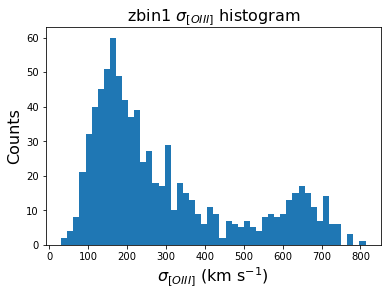

    Original Count:   820
             Count:   814
              Mean:   297.6659831039919
            Median:   222.80076779838964
Standard Deviation:   190.99880451436502
           Minimum:   30.271987433335408
           Maximum:   813.0853544280399


In [21]:
OIII_sigma_list_zbin1 = []
OIII_sigma_err_list_zbin1 = []

OIII_vel_list_zbin1 = []
OIII_vel_err_list_zbin1 = []

for key in zbin1_dict:
    
    temp_sigma_list = []
    temp_vel_list = []
    
    parameters     = zbin1_dict[key][0]
    fluxden_scale  = zbin1_dict[key][1]
    parameters_err = zbin1_dict[key][2]
    flag           = zbin1_dict[key][3]
    
    wave = trimmed_specs_zbin1[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err)
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )
        
        temp_vel_list.append(to_vel_OIII(first_moment))
        temp_sigma_list.append(temp_OIII_sigma)
        
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin1.append(OIII_sigma)
    OIII_sigma_err_list_zbin1.append(OIII_sigma_err)
    
    clean_temp_vel_list = [x for x in temp_vel_list if str(x) != 'nan']
    
    OIII_vel = np.mean(np.array(clean_temp_vel_list))
    OIII_vel_err = np.std(np.array(clean_temp_vel_list))
    
    OIII_vel_list_zbin1.append(OIII_vel)
    OIII_vel_err_list_zbin1.append(OIII_vel_err)

OIII_sigma_array_zbin1 = np.array(OIII_sigma_list_zbin1)
OIII_sigma_err_array_zbin1 = np.array(OIII_sigma_err_list_zbin1)

OIII_vel_array_zbin1 = np.array(OIII_vel_list_zbin1)
OIII_vel_err_array_zbin1 = np.array(OIII_vel_err_list_zbin1)

fractional_error_zbin1_sig = OIII_sigma_err_array_zbin1 / OIII_sigma_array_zbin1
select_good_zbin1 = ( OIII_sigma_array_zbin1 > 30 ) & ( fractional_error_zbin1_sig < 1 ) & ~np.isnan(fractional_error_zbin1_sig)
OIII_sigma_array_zbin1_good = OIII_sigma_array_zbin1[select_good_zbin1]

OIII_vel_array_zbin1_good = OIII_vel_array_zbin1[select_good_zbin1]

plt.hist(OIII_sigma_array_zbin1_good, bins = 50)

plt.title(r'zbin1 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin1_dict)))
array_summary(OIII_sigma_array_zbin1_good)

In [22]:
len(OIII_vel_err_array_zbin1[select_good_zbin1])

814

In [23]:
array_summary(OIII_vel_array_zbin1_good)

             Count:   814
              Mean:   28611.989687403915
            Median:   29569.069123539542
Standard Deviation:   8923.776043333091
           Minimum:   124.90199267899943
           Maximum:   44992.17462739665


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in float_scalars


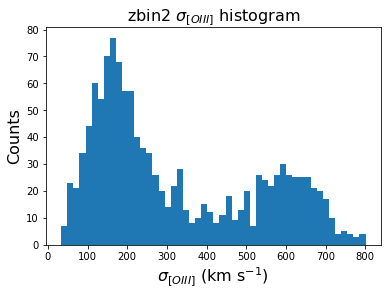

    Original Count:   1282
             Count:   1253
              Mean:   321.92305966288154
            Median:   240.04768556915224
Standard Deviation:   204.32414720679864
           Minimum:   33.421315748785446
           Maximum:   800.2880392653133


In [24]:
OIII_sigma_list_zbin2 = []
OIII_sigma_err_list_zbin2 = []

OIII_vel_list_zbin2 = []
OIII_vel_err_list_zbin2 = []

for key in zbin2_dict:
    
    temp_sigma_list = []
    temp_vel_list = []
    
    parameters     = zbin2_dict[key][0]
    fluxden_scale  = zbin2_dict[key][1]
    parameters_err = zbin2_dict[key][2]
    flag           = zbin2_dict[key][3]
    
    wave = trimmed_specs_zbin2[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err)
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )
        
        temp_vel_list.append(to_vel_OIII(first_moment))
        temp_sigma_list.append(temp_OIII_sigma)
        
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin2.append(OIII_sigma)
    OIII_sigma_err_list_zbin2.append(OIII_sigma_err)
    
    clean_temp_vel_list = [x for x in temp_vel_list if str(x) != 'nan']
    
    OIII_vel = np.mean(np.array(clean_temp_vel_list))
    OIII_vel_err = np.std(np.array(clean_temp_vel_list))
    
    OIII_vel_list_zbin2.append(OIII_vel)
    OIII_vel_err_list_zbin2.append(OIII_vel_err)

OIII_sigma_array_zbin2 = np.array(OIII_sigma_list_zbin2)
OIII_sigma_err_array_zbin2 = np.array(OIII_sigma_err_list_zbin2)

OIII_vel_array_zbin2 = np.array(OIII_vel_list_zbin2)
OIII_vel_err_array_zbin2 = np.array(OIII_vel_err_list_zbin2)

fractional_error_zbin2_sig = OIII_sigma_err_array_zbin2 / OIII_sigma_array_zbin2
select_good_zbin2 = ( OIII_sigma_array_zbin2 > 30 ) & ( fractional_error_zbin2_sig < 1 ) & ~np.isnan(fractional_error_zbin2_sig)
OIII_sigma_array_zbin2_good = OIII_sigma_array_zbin2[select_good_zbin2]

OIII_vel_array_zbin2_good = OIII_vel_array_zbin2[select_good_zbin2]

plt.hist(OIII_sigma_array_zbin2_good, bins = 50)

plt.title(r'zbin2 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin2_dict)))
array_summary(OIII_sigma_array_zbin2_good)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in float_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


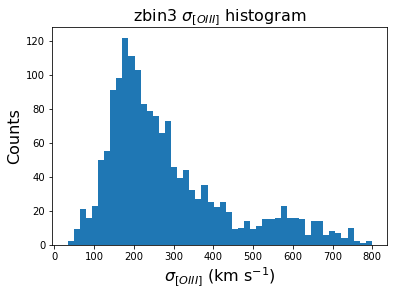

    Original Count:   1659
             Count:   1635
              Mean:   284.8267096196812
            Median:   238.5440519428812
Standard Deviation:   154.6112703270714
           Minimum:   33.27098737240381
           Maximum:   798.8784479966853


In [25]:
OIII_sigma_list_zbin3 = []
OIII_sigma_err_list_zbin3 = []

OIII_vel_list_zbin3 = []
OIII_vel_err_list_zbin3 = []

for key in zbin3_dict:
    
    temp_sigma_list = []
    temp_vel_list = []
    
    parameters     = zbin3_dict[key][0]
    fluxden_scale  = zbin3_dict[key][1]
    parameters_err = zbin3_dict[key][2]
    flag           = zbin3_dict[key][3]
    
    wave = trimmed_specs_zbin3[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err)
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )
        
        temp_vel_list.append(to_vel_OIII(first_moment))
        temp_sigma_list.append(temp_OIII_sigma)
        
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin3.append(OIII_sigma)
    OIII_sigma_err_list_zbin3.append(OIII_sigma_err)
    
    clean_temp_vel_list = [x for x in temp_vel_list if str(x) != 'nan']
    
    OIII_vel = np.mean(np.array(clean_temp_vel_list))
    OIII_vel_err = np.std(np.array(clean_temp_vel_list))
    
    OIII_vel_list_zbin3.append(OIII_vel)
    OIII_vel_err_list_zbin3.append(OIII_vel_err)

OIII_sigma_array_zbin3 = np.array(OIII_sigma_list_zbin3)
OIII_sigma_err_array_zbin3 = np.array(OIII_sigma_err_list_zbin3)

OIII_vel_array_zbin3 = np.array(OIII_vel_list_zbin3)
OIII_vel_err_array_zbin3 = np.array(OIII_vel_err_list_zbin3)

fractional_error_zbin3_sig = OIII_sigma_err_array_zbin3 / OIII_sigma_array_zbin3
select_good_zbin3 = ( OIII_sigma_array_zbin3 > 30 ) & ( fractional_error_zbin3_sig < 1 ) & ~np.isnan(fractional_error_zbin3_sig)
OIII_sigma_array_zbin3_good = OIII_sigma_array_zbin3[select_good_zbin3]

OIII_vel_array_zbin3_good = OIII_vel_array_zbin3[select_good_zbin3]

plt.hist(OIII_sigma_array_zbin3_good, bins = 50)

plt.title(r'zbin3 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin3_dict)))
array_summary(OIII_sigma_array_zbin3_good)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in float_scalars


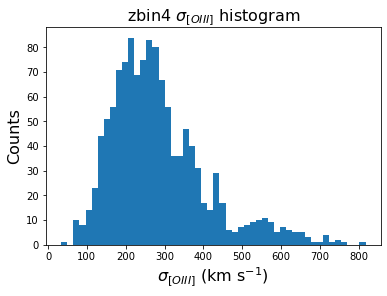

    Original Count:   1258
             Count:   1240
              Mean:   283.19566741446874
            Median:   260.12390610412695
Standard Deviation:   123.64482569098479
           Minimum:   33.677983210590824
           Maximum:   818.0552971316501


In [26]:
OIII_sigma_list_zbin4 = []
OIII_sigma_err_list_zbin4 = []

OIII_vel_list_zbin4 = []
OIII_vel_err_list_zbin4 = []

for key in zbin4_dict:
    
    temp_sigma_list = []
    temp_vel_list = []
    
    parameters     = zbin4_dict[key][0]
    fluxden_scale  = zbin4_dict[key][1]
    parameters_err = zbin4_dict[key][2]
    flag           = zbin4_dict[key][3]
    
    wave = trimmed_specs_zbin4[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err)
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )
        
        temp_vel_list.append(to_vel_OIII(first_moment))
        temp_sigma_list.append(temp_OIII_sigma)
        
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin4.append(OIII_sigma)
    OIII_sigma_err_list_zbin4.append(OIII_sigma_err)
    
    clean_temp_vel_list = [x for x in temp_vel_list if str(x) != 'nan']
    
    OIII_vel = np.mean(np.array(clean_temp_vel_list))
    OIII_vel_err = np.std(np.array(clean_temp_vel_list))
    
    OIII_vel_list_zbin4.append(OIII_vel)
    OIII_vel_err_list_zbin4.append(OIII_vel_err)

OIII_sigma_array_zbin4 = np.array(OIII_sigma_list_zbin4)
OIII_sigma_err_array_zbin4 = np.array(OIII_sigma_err_list_zbin4)

OIII_vel_array_zbin4 = np.array(OIII_vel_list_zbin4)
OIII_vel_err_array_zbin4 = np.array(OIII_vel_err_list_zbin4)

fractional_error_zbin4_sig = OIII_sigma_err_array_zbin4 / OIII_sigma_array_zbin4
select_good_zbin4 = ( OIII_sigma_array_zbin4 > 30 ) & ( fractional_error_zbin4_sig < 1 ) & ~np.isnan(fractional_error_zbin4_sig)
OIII_sigma_array_zbin4_good = OIII_sigma_array_zbin4[select_good_zbin4]

OIII_vel_array_zbin4_good = OIII_vel_array_zbin4[select_good_zbin4]

plt.hist(OIII_sigma_array_zbin4_good, bins = 50)

plt.title(r'zbin4 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin4_dict)))
array_summary(OIII_sigma_array_zbin4_good)

In [27]:
fe = OIII_vel_err_array_zbin4 / OIII_vel_array_zbin4

len(fe[fe>=1])

0

In [28]:
##############################################################
############################################################## END CALCULATE MOMENTS
##############################################################

In [29]:
##############################################################
############################################################## START LUMINOSITY, EDDINGTON RATIOS
##############################################################

In [30]:
zbin1_data_v2 = zbin1_data[select_good_zbin1] # cut data for wing frac error etc.
zbin2_data_v2 = zbin2_data[select_good_zbin2]
zbin3_data_v2 = zbin3_data[select_good_zbin3]
zbin4_data_v2 = zbin4_data[select_good_zbin4]

In [31]:
##################################################################################

zbin1_OIII_flux = zbin1_data_v2['FLUX'][:, 17]
zbin1_redshift  = zbin1_data_v2['Z']

zbin2_OIII_flux = zbin2_data_v2['FLUX'][:, 17]
zbin2_redshift  = zbin2_data_v2['Z']

zbin3_OIII_flux = zbin3_data_v2['FLUX'][:, 17]
zbin3_redshift  = zbin3_data_v2['Z']

zbin4_OIII_flux = zbin4_data_v2['FLUX'][:, 17]
zbin4_redshift  = zbin4_data_v2['Z']

##################################################################################

zbin1_lum_dis = cosmo.luminosity_distance(zbin1_redshift)
zbin1_lum_dis = zbin1_lum_dis.to(u.cm)
zbin1_OIII_flux_correct_units = zbin1_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin1_OIII_lum = 4 * np.pi * zbin1_OIII_flux_correct_units * (zbin1_lum_dis ** 2)

##################################################################################

zbin2_lum_dis = cosmo.luminosity_distance(zbin2_redshift)
zbin2_lum_dis = zbin2_lum_dis.to(u.cm)
zbin2_OIII_flux_correct_units = zbin2_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin2_OIII_lum = 4 * np.pi * zbin2_OIII_flux_correct_units * (zbin2_lum_dis ** 2)

##################################################################################

zbin3_lum_dis = cosmo.luminosity_distance(zbin3_redshift)
zbin3_lum_dis = zbin3_lum_dis.to(u.cm)
zbin3_OIII_flux_correct_units = zbin3_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin3_OIII_lum = 4 * np.pi * zbin3_OIII_flux_correct_units * (zbin3_lum_dis ** 2)

##################################################################################

zbin4_lum_dis = cosmo.luminosity_distance(zbin4_redshift)
zbin4_lum_dis = zbin4_lum_dis.to(u.cm)
zbin4_OIII_flux_correct_units = zbin4_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin4_OIII_lum = 4 * np.pi * zbin4_OIII_flux_correct_units * (zbin4_lum_dis ** 2)

##################################################################################

zbin1_OIII_lum_array = np.array(zbin1_OIII_lum)
zbin2_OIII_lum_array = np.array(zbin2_OIII_lum)
zbin3_OIII_lum_array = np.array(zbin3_OIII_lum)
zbin4_OIII_lum_array = np.array(zbin4_OIII_lum)

##################################################################################

zbin1_OIII_log_lum_array = np.log10(zbin1_OIII_lum_array)
zbin2_OIII_log_lum_array = np.log10(zbin2_OIII_lum_array)
zbin3_OIII_log_lum_array = np.log10(zbin3_OIII_lum_array)
zbin4_OIII_log_lum_array = np.log10(zbin4_OIII_lum_array)

##################################################################################

In [32]:
len(zbin1_OIII_log_lum_array)

814

In [33]:
# select_zbin1_lum_cut = (zbin1_OIII_log_lum_array <= 43) & (zbin1_OIII_log_lum_array >=38)
# select_zbin2_lum_cut = (zbin2_OIII_log_lum_array <= 43) & (zbin2_OIII_log_lum_array >=38)
# select_zbin3_lum_cut = (zbin3_OIII_log_lum_array <= 43) & (zbin3_OIII_log_lum_array >=38)
# select_zbin4_lum_cut = (zbin4_OIII_log_lum_array <= 43) & (zbin4_OIII_log_lum_array >=38)

In [34]:
bol_correction = 3500 # Heckman 2004

zbin1_bol_lum_array = bol_correction * zbin1_OIII_lum_array
zbin2_bol_lum_array = bol_correction * zbin2_OIII_lum_array
zbin3_bol_lum_array = bol_correction * zbin3_OIII_lum_array
zbin4_bol_lum_array = bol_correction * zbin4_OIII_lum_array

In [35]:
zbin1_sigma_stars = zbin1_data_v2['SIGMA_STARS']
zbin2_sigma_stars = zbin2_data_v2['SIGMA_STARS']
zbin3_sigma_stars = zbin3_data_v2['SIGMA_STARS']
zbin4_sigma_stars = zbin4_data_v2['SIGMA_STARS']

In [36]:
zbin1_data_v2.columns

ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'Z'; format = 'E'
    name = 'Z_ERR'; format = 'E'
    name = 'ZNUM'; format = 'J'
    name = 'VEL_STARS'; format = 'E'
    name = 'REDSHIFT'; format = 'E'
    name = 'SIGMA_STARS'; format = 'E'
    name = 'SIGMA_STARS_ERR'; format = 'E'
    name = 'CHISQ'; format = 'E'
    name = 'FILENAME'; format = '30A'
    name = 'BPT'; format = '13A'
    name = 'NAME'; format = '3136A'; dim = '(112,28)'
    name = 'LAMBDA'; format = '28E'
    name = 'KIND'; format = '1344A'; dim = '(48,28)'
    name = 'A'; format = '28E'
    name = 'V'; format = '28E'
    name = 'V_ERR'; format = '28E'
    name = 'SIG'; format = '28E'
    name = 'SIG_ERR'; format = '28E'
    name = 'AMPLITUDE'; format = '28E'
    name = 'AMPLITUDE_ERR'; format = '28E'
    name = 'FLUX'; format = '28E'
    name = 'FLUX_ERR'; format = '28E'
    name = 'EW

In [37]:
M_sun = 1.9885 * 10 ** 30 # kg
L_sun = 3.8280 * 10 ** 33 # erg/s

zbin1_sigma_stars_float64 = (zbin1_sigma_stars).astype('float64')
zbin2_sigma_stars_float64 = (zbin2_sigma_stars).astype('float64')
zbin3_sigma_stars_float64 = (zbin3_sigma_stars).astype('float64')
zbin4_sigma_stars_float64 = (zbin4_sigma_stars).astype('float64')

zbin1_M_BH = ( 10 ** 8.12 ) * ( ( zbin1_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin2_M_BH = ( 10 ** 8.12 ) * ( ( zbin2_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin3_M_BH = ( 10 ** 8.12 ) * ( ( zbin3_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin4_M_BH = ( 10 ** 8.12 ) * ( ( zbin4_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )

zbin1_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin1_M_BH / M_sun )
zbin2_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin2_M_BH / M_sun )
zbin3_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin3_M_BH / M_sun )
zbin4_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin4_M_BH / M_sun )


In [38]:
len(zbin1_lum_edd)

814

In [39]:
zbin1_edd_ratio = zbin1_bol_lum_array / zbin1_lum_edd
zbin2_edd_ratio = zbin2_bol_lum_array / zbin2_lum_edd
zbin3_edd_ratio = zbin3_bol_lum_array / zbin3_lum_edd
zbin4_edd_ratio = zbin4_bol_lum_array / zbin4_lum_edd

select_zbin1_edd_cut = (zbin1_edd_ratio < 10)
select_zbin2_edd_cut = (zbin2_edd_ratio < 10)
select_zbin3_edd_cut = (zbin3_edd_ratio < 10)
select_zbin4_edd_cut = (zbin4_edd_ratio < 10)

# zbin1_edd_ratio = zbin1_edd_ratio[select_zbin1_lum_cut & select_zbin1_edd_cut]
# zbin2_edd_ratio = zbin2_edd_ratio[select_zbin2_lum_cut & select_zbin2_edd_cut]
# zbin3_edd_ratio = zbin3_edd_ratio[select_zbin3_lum_cut & select_zbin3_edd_cut]
# zbin4_edd_ratio = zbin4_edd_ratio[select_zbin4_lum_cut & select_zbin4_edd_cut]

# zbin1_OIII_log_lum_array = zbin1_OIII_log_lum_array[select_zbin1_lum_cut & select_zbin1_edd_cut]
# zbin2_OIII_log_lum_array = zbin2_OIII_log_lum_array[select_zbin2_lum_cut & select_zbin2_edd_cut]
# zbin3_OIII_log_lum_array = zbin3_OIII_log_lum_array[select_zbin3_lum_cut & select_zbin3_edd_cut]
# zbin4_OIII_log_lum_array = zbin4_OIII_log_lum_array[select_zbin4_lum_cut & select_zbin4_edd_cut]

# OIII_sigma_array_zbin1_good = OIII_sigma_array_zbin1_good[select_zbin1_lum_cut & select_zbin1_edd_cut]
# OIII_sigma_array_zbin2_good = OIII_sigma_array_zbin2_good[select_zbin2_lum_cut & select_zbin2_edd_cut]
# OIII_sigma_array_zbin3_good = OIII_sigma_array_zbin3_good[select_zbin3_lum_cut & select_zbin3_edd_cut]
# OIII_sigma_array_zbin4_good = OIII_sigma_array_zbin4_good[select_zbin4_lum_cut & select_zbin4_edd_cut]

# zbin1_data_v2 = zbin1_data_v2[select_zbin1_lum_cut & select_zbin1_edd_cut] # cut data for wing frac error etc.
# zbin2_data_v2 = zbin2_data_v2[select_zbin2_lum_cut & select_zbin2_edd_cut]
# zbin3_data_v2 = zbin3_data_v2[select_zbin3_lum_cut & select_zbin3_edd_cut]
# zbin4_data_v2 = zbin4_data_v2[select_zbin4_lum_cut & select_zbin4_edd_cut]

# zbin1_sigma_stars = zbin1_sigma_stars[select_zbin1_lum_cut & select_zbin1_edd_cut]
# zbin2_sigma_stars = zbin2_sigma_stars[select_zbin2_lum_cut & select_zbin2_edd_cut]
# zbin3_sigma_stars = zbin3_sigma_stars[select_zbin3_lum_cut & select_zbin3_edd_cut]
# zbin4_sigma_stars = zbin4_sigma_stars[select_zbin4_lum_cut & select_zbin4_edd_cut]

zbin1_edd_ratio = zbin1_edd_ratio[select_zbin1_edd_cut]
zbin2_edd_ratio = zbin2_edd_ratio[select_zbin2_edd_cut]
zbin3_edd_ratio = zbin3_edd_ratio[select_zbin3_edd_cut]
zbin4_edd_ratio = zbin4_edd_ratio[select_zbin4_edd_cut]

zbin1_OIII_log_lum_array = zbin1_OIII_log_lum_array[select_zbin1_edd_cut]
zbin2_OIII_log_lum_array = zbin2_OIII_log_lum_array[select_zbin2_edd_cut]
zbin3_OIII_log_lum_array = zbin3_OIII_log_lum_array[select_zbin3_edd_cut]
zbin4_OIII_log_lum_array = zbin4_OIII_log_lum_array[select_zbin4_edd_cut]

OIII_sigma_array_zbin1_good = OIII_sigma_array_zbin1_good[select_zbin1_edd_cut]
OIII_sigma_array_zbin2_good = OIII_sigma_array_zbin2_good[select_zbin2_edd_cut]
OIII_sigma_array_zbin3_good = OIII_sigma_array_zbin3_good[select_zbin3_edd_cut]
OIII_sigma_array_zbin4_good = OIII_sigma_array_zbin4_good[select_zbin4_edd_cut]

zbin1_data_v2 = zbin1_data_v2[select_zbin1_edd_cut] # cut data for wing frac error etc.
zbin2_data_v2 = zbin2_data_v2[select_zbin2_edd_cut]
zbin3_data_v2 = zbin3_data_v2[select_zbin3_edd_cut]
zbin4_data_v2 = zbin4_data_v2[select_zbin4_edd_cut]

zbin1_sigma_stars = zbin1_sigma_stars[select_zbin1_edd_cut]
zbin2_sigma_stars = zbin2_sigma_stars[select_zbin2_edd_cut]
zbin3_sigma_stars = zbin3_sigma_stars[select_zbin3_edd_cut]
zbin4_sigma_stars = zbin4_sigma_stars[select_zbin4_edd_cut]

In [40]:
zbin1_results_v2 = zbin1_results[select_good_zbin1]
zbin2_results_v2 = zbin2_results[select_good_zbin2]
zbin3_results_v2 = zbin3_results[select_good_zbin3]
zbin4_results_v2 = zbin4_results[select_good_zbin4]

zbin1_results_v2 = zbin1_results_v2[select_zbin1_edd_cut]
zbin2_results_v2 = zbin2_results_v2[select_zbin2_edd_cut]
zbin3_results_v2 = zbin3_results_v2[select_zbin3_edd_cut]
zbin4_results_v2 = zbin4_results_v2[select_zbin4_edd_cut]

In [262]:
Table(zbin1_data_v2)

PLATE,MJD,FIBERID,RA,DEC,Z,Z_ERR,ZNUM,VEL_STARS,REDSHIFT,SIGMA_STARS,SIGMA_STARS_ERR,CHISQ,FILENAME,BPT,NAME [28],LAMBDA [28],KIND [28],A [28],V [28],V_ERR [28],SIG [28],SIG_ERR [28],AMPLITUDE [28],AMPLITUDE_ERR [28],FLUX [28],FLUX_ERR [28],EW [28],EW_ERR [28],FLUX_CONT [28],FLUX_CONT_ERR [28],AON [28],EBMV,EBMV_ERR,EBMV_SFD,FIT_WARNING [28],ERROR_WARNING,LEGACY_TARGET1,LEGACY_TARGET2,SPECIAL_TARGET1,SPECIAL_TARGET2,BOSS_TARGET1,EBOSS_TARGET0,ANCILLARY_TARGET1,ANCILLARY_TARGET2,SPECOBJID,RUN2D,RUN1D,SPECPRIMARY
int32,int32,int32,float64,float64,float32,float32,int32,float32,float32,float32,float32,float32,str30,str13,str112,float32,str48,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,int32,int32,int64,int64,int64,int64,int64,int64,int64,str6,str6,uint8
3586,55181,154,8.681286899999975,-0.040760401,0.042037047,5.755926e-06,1,12392.743,0.04220404,81.92674,4.322625,0.9416316,emlinekin-3586-55181-0154.fits,Seyfert,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,12392.743 .. 12419.618,-0.0 .. 5.5165844,10.0 .. 178.32846,-0.0 .. 6.301182,0.0 .. 42.600098,-0.0 .. 0.43734273,0.0 .. 471.36084,0.0 .. 18.817661,0.0 .. 7.2201023,nan .. 0.2884924,0.0 .. 26.067003,0.0 .. 0.04215733,0.0 .. 11.060896,0.30948508,0.0031757401,0.01803536,0 .. 0,0,0,0,0,0,1,0,0,0,4037519484058791936,v5_7_0,v5_7_0,1
3588,55184,458,9.267108399999984,-1.152315,0.0736456,7.1103896e-06,1,21383.908,0.07393453,248.21848,3.0276942,1.5592867,emlinekin-3588-55184-0458.fits,LINER,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,21383.908 .. 21391.475,-0.0 .. 16.830912,10.0 .. 125.562065,-0.0 .. 19.943611,0.0 .. 5.124009,-0.0 .. 0.43150574,0.0 .. 43.299107,0.0 .. 7.7920756,0.0 .. 0.7456494,nan .. 0.13421112,0.0 .. 50.52526,0.0 .. 0.1496496,0.0 .. 3.4637997,0.046910085,0.00094916194,0.02149577,0 .. 0,0,0,0,0,0,1,0,0,0,4039854846806519808,v5_7_0,v5_7_0,1
3615,55179,427,36.161361,-0.79924519,0.06681842,1.1392256e-05,1,19459.56,0.0670631,118.24605,3.4690547,1.0136287,emlinekin-3615-55179-0427.fits,Seyfert,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,19459.56 .. 19465.271,-0.0 .. 2.568244,10.0 .. 94.90032,-0.0 .. 2.7383432,0.0 .. 34.672062,-0.0 .. 0.3672387,0.0 .. 235.45776,0.0 .. 7.017901,0.0 .. 4.7390094,nan .. 0.14160317,0.0 .. 24.527967,0.0 .. 0.050012283,0.0 .. 14.164203,0.23795438,0.002717915,0.03394219,0 .. 0,0,0,0,0,0,1,0,0,0,4070245622992269312,v5_7_0,v5_7_0,1
3615,55445,423,36.161361,-0.79924519,0.06686248,1.0953896e-05,1,19473.36,0.067112215,103.72937,4.4157286,0.8200587,emlinekin-3615-55445-0423.fits,Seyfert,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,19473.36 .. 19477.81,-0.0 .. 4.4294047,10.0 .. 111.58455,-0.0 .. 4.7636585,0.0 .. 39.730812,-0.0 .. 0.5200153,0.0 .. 304.00198,0.0 .. 14.791798,0.0 .. 4.583606,nan .. 0.22344558,0.0 .. 27.460045,0.0 .. 0.0813273,0.0 .. 14.088279,0.2972591,0.0030952017,0.03394219,0 .. 0,0,0,0,0,0,1,0,0,0,4070244527943380992,v5_7_0,v5_7_0,0
3615,56219,421,36.161361,-0.79924519,0.06688071,1.1210765e-05,1,19471.271,0.06710478,108.35899,5.454602,0.90845144,emlinekin-3615-56219-0421.fits,Seyfert,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,19471.271 .. 19482.26,-0.0 .. 5.426339,10.0 .. 109.42985,-0.0 .. 5.9843917,0.0 .. 32.901875,-0.0 .. 0.6169517,0.0 .. 248.03362,0.0 .. 16.425167,0.0 .. 4.3274226,nan .. 0.28681853,0.0 .. 28.117725,0.0 .. 0.07375209,0.0 .. 10.497576,0.24007896,0.004303655,0.03394219,0 .. 0,0,0,0,0,0,1,0,0,0,4070243991173132288,v5_7_0,v5_7_0,0
3615,56544,429,36.161361,-0.79924519,0.06689425,1.1608805e-05,1,19480.467,0.06713752,104.70292,4.2160416,0.995837,emlinekin-3615-56544-0429.fits,Seyfert,HeII .. [SII],3203.15 .. 6730.68,l .. l,1.0 .. 1.0,19480.467 .. 19485.033,-0.0 .. 4.063081,10.0 .. 99.10608,-0.0 .. 4.3830647,0.0 .. 24.304808,-0.0 .. 0.3796583,0.0 .. 170.24913,0.0 .. 8.437052,0.0 .. 3.9445095,nan .. 0.19575658,0.0 .. 21.487259,0.0 .. 0.055068586,0.0 .. 11.495984,0.23511894,0.0030831941,0.03394219,

In [42]:
hdul = fits.open('zbin1_sv.fits')

zbin1_syst_vel_dat = hdul[1].data
zbin1_syst_vel = zbin1_syst_vel_dat['SYST_VEL']

hdul.close()

##################################################################################

hdul = fits.open('zbin2_sv.fits')

zbin2_syst_vel_dat = hdul[1].data
zbin2_syst_vel = zbin2_syst_vel_dat['SYST_VEL']

hdul.close()

##################################################################################

hdul = fits.open('zbin3_sv.fits')

zbin3_syst_vel_dat = hdul[1].data
zbin3_syst_vel = zbin3_syst_vel_dat['SYST_VEL']

hdul.close()

##################################################################################

hdul = fits.open('zbin4_sv.fits')

zbin4_syst_vel_dat = hdul[1].data
zbin4_syst_vel = zbin4_syst_vel_dat['SYST_VEL']

hdul.close()

In [43]:
core_vel_zbin1 = []
core_vel_err_zbin1 = []

for row in zbin1_results_v2:
    if row['FLAG'] == 1:
        core_vel_zbin1.append(row['WING_VEL'])
        core_vel_err_zbin1.append(row['WING_VEL_ERR'])
    else:
        core_vel_zbin1.append(row['CORE_VEL'])
        core_vel_err_zbin1.append(row['CORE_VEL_ERR'])

zbin1_vs = np.array(OIII_vel_array_zbin1_good[select_zbin1_edd_cut] - core_vel_zbin1)
zbin1_vs_err = np.sqrt( ( OIII_vel_err_array_zbin1[select_good_zbin1][select_zbin1_edd_cut] ** 2 ) + ( np.array(core_vel_err_zbin1) ** 2 ) )

# zbin1_vs = np.array(OIII_vel_array_zbin1_good[select_zbin1_edd_cut] - zbin1_syst_vel[select_good_zbin1][select_zbin1_edd_cut])

##################################################################################

core_vel_zbin2 = []
core_vel_err_zbin2 = []

for row in zbin2_results_v2:
    if row['FLAG'] == 1:
        core_vel_zbin2.append(row['WING_VEL'])
        core_vel_err_zbin2.append(row['WING_VEL_ERR'])
    else:
        core_vel_zbin2.append(row['CORE_VEL'])
        core_vel_err_zbin2.append(row['CORE_VEL_ERR'])

# zbin2_vs = np.array(OIII_vel_array_zbin2_good[select_zbin2_edd_cut] - zbin2_syst_vel[select_good_zbin2][select_zbin2_edd_cut])
zbin2_vs = np.array(OIII_vel_array_zbin2_good[select_zbin2_edd_cut] - core_vel_zbin2)
zbin2_vs_err = np.sqrt( ( OIII_vel_err_array_zbin2[select_good_zbin2][select_zbin2_edd_cut] ** 2 ) + ( np.array(core_vel_err_zbin2) ** 2 ) )

##################################################################################

core_vel_zbin3 = []
core_vel_err_zbin3 = []

for row in zbin3_results_v2:
    if row['FLAG'] == 1:
        core_vel_zbin3.append(row['WING_VEL'])
        core_vel_err_zbin3.append(row['WING_VEL_ERR'])
    else:
        core_vel_zbin3.append(row['CORE_VEL'])
        core_vel_err_zbin3.append(row['CORE_VEL_ERR'])
# zbin3_vs = np.array(OIII_vel_array_zbin3_good[select_zbin3_edd_cut] - zbin3_syst_vel[select_good_zbin3][select_zbin3_edd_cut])
zbin3_vs = np.array(OIII_vel_array_zbin3_good[select_zbin3_edd_cut] - core_vel_zbin3)
zbin3_vs_err = np.sqrt( ( OIII_vel_err_array_zbin3[select_good_zbin3][select_zbin3_edd_cut] ** 2 ) + ( np.array(core_vel_err_zbin3) ** 2 ) ) 
                       
##################################################################################

core_vel_zbin4 = []
core_vel_err_zbin4 = []

for row in zbin4_results_v2:
    if row['FLAG'] == 1:
        core_vel_zbin4.append(row['WING_VEL'])
        core_vel_err_zbin4.append(row['WING_VEL_ERR'])
    else:
        core_vel_zbin4.append(row['CORE_VEL'])
        core_vel_err_zbin4.append(row['CORE_VEL_ERR'])
        
# zbin4_vs = np.array(OIII_vel_array_zbin4_good[select_zbin4_edd_cut] - zbin4_syst_vel[select_good_zbin4][select_zbin4_edd_cut])
zbin4_vs = np.array(OIII_vel_array_zbin4_good[select_zbin4_edd_cut] - core_vel_zbin4)
zbin4_vs_err = np.sqrt( ( OIII_vel_err_array_zbin4[select_good_zbin4][select_zbin4_edd_cut] ** 2 ) + ( np.array(core_vel_err_zbin4) ** 2 ) ) 

In [45]:
##############################################################
############################################################## END LUMINOSITY, EDDINGTON RATIOS
##############################################################

In [46]:
# calculate error in sigma OIII, could vary the
# parameters by their errors and get an error and mean off that like monte-carlo

# use M-sigma relation to get BH mass for L-eddington
# then get L-bol by using bolometric correction
# note appears to be hard max min of sigma_stars max = 1000, min = 6.9
#plot outflowing sources on the bpt

In [47]:
##############################################################
############################################################## START FIG 2
##############################################################

In [48]:
mean_redshifts = np.array([0.075, 0.225, 0.375, 0.525])

zbin1_mean_OIII_log_lum = np.mean(zbin1_OIII_log_lum_array)
zbin2_mean_OIII_log_lum = np.mean(zbin2_OIII_log_lum_array)
zbin3_mean_OIII_log_lum = np.mean(zbin3_OIII_log_lum_array)
zbin4_mean_OIII_log_lum = np.mean(zbin4_OIII_log_lum_array)

zbin1_std_OIII_log_lum = np.std(zbin1_OIII_log_lum_array)
zbin2_std_OIII_log_lum = np.std(zbin2_OIII_log_lum_array)
zbin3_std_OIII_log_lum = np.std(zbin3_OIII_log_lum_array)
zbin4_std_OIII_log_lum = np.std(zbin4_OIII_log_lum_array)

mean_OIII_log_lum  = np.array([zbin1_mean_OIII_log_lum, zbin2_mean_OIII_log_lum, zbin3_mean_OIII_log_lum, zbin4_mean_OIII_log_lum])
std_OIII_log_lum   = np.array([zbin1_std_OIII_log_lum, zbin2_std_OIII_log_lum, zbin3_std_OIII_log_lum, zbin4_std_OIII_log_lum])

##############################################################

zbin1_log_edd_ratio = np.log10(zbin1_edd_ratio)
zbin2_log_edd_ratio = np.log10(zbin2_edd_ratio)
zbin3_log_edd_ratio = np.log10(zbin3_edd_ratio)
zbin4_log_edd_ratio = np.log10(zbin4_edd_ratio)

zbin1_mean_log_edd_ratio = np.mean(zbin1_log_edd_ratio)
zbin2_mean_log_edd_ratio = np.mean(zbin2_log_edd_ratio)
zbin3_mean_log_edd_ratio = np.mean(zbin3_log_edd_ratio)
zbin4_mean_log_edd_ratio = np.mean(zbin4_log_edd_ratio)

zbin1_std_log_edd_ratio = np.std(zbin1_log_edd_ratio)
zbin2_std_log_edd_ratio = np.std(zbin2_log_edd_ratio)
zbin3_std_log_edd_ratio = np.std(zbin3_log_edd_ratio)
zbin4_std_log_edd_ratio = np.std(zbin4_log_edd_ratio)

mean_log_edd_ratio = np.array([zbin1_mean_log_edd_ratio, zbin2_mean_log_edd_ratio, zbin3_mean_log_edd_ratio, zbin4_mean_log_edd_ratio])
std_log_edd_ratio = np.array([zbin1_std_log_edd_ratio, zbin2_std_log_edd_ratio, zbin3_std_log_edd_ratio, zbin4_std_log_edd_ratio])


In [265]:
len(zbin1_vs)

808

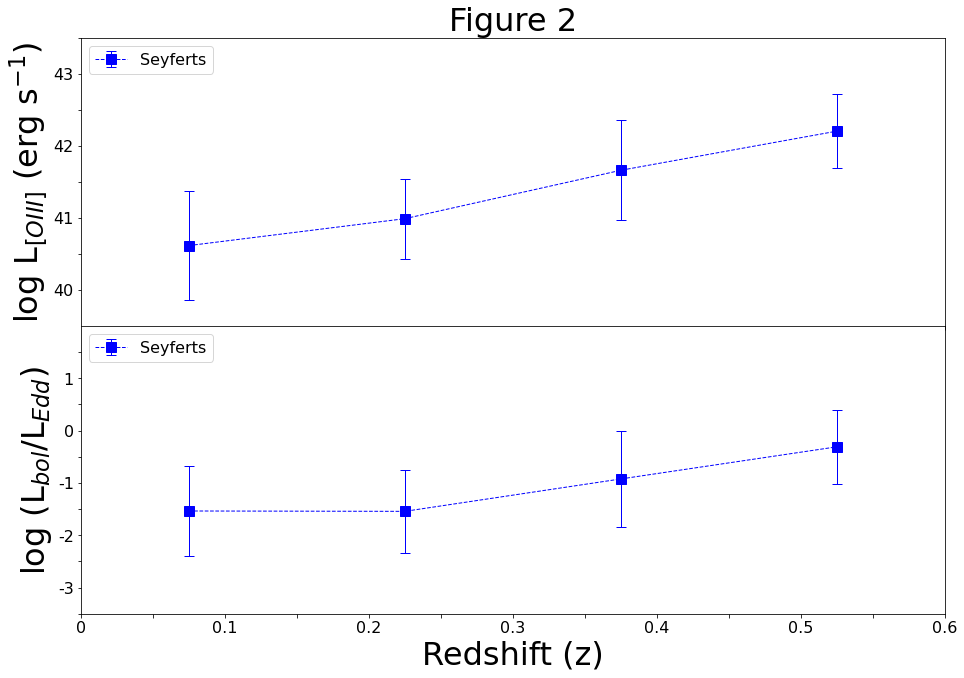

In [49]:
fig = plt.figure()
ax1 = fig.add_axes([0, 1, 2, 1],
                   xticklabels=[],  ylim = (39.5, 43.5), xlim = (0, 0.6) )
ax2 = fig.add_axes([0, 0, 2, 1], 
                   ylim = (-3.5, 2), xlim = (0, 0.6))

ax1.errorbar(mean_redshifts, mean_OIII_log_lum, std_OIII_log_lum, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax1.set_yticks([40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5])
ax1.set_yticklabels([40, '', 41, '', 42, '', 43, ''], fontsize = 16)
ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)

ax2.errorbar(mean_redshifts, mean_log_edd_ratio, std_log_edd_ratio, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax2.set_yticks([-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax2.set_yticklabels(['', -3, '', -2, '', -1, '', 0, '', 1, ''], fontsize = 16)
ax2.set_xticks(np.arange(0, 0.65, 0.05))
ax2.set_xticklabels([0, '', 0.1, '', 0.2, '', 0.3, '', 0.4, '', 0.5, '', 0.6], fontsize = 16)
ax2.set_ylabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)
ax2.set_xlabel('Redshift (z)', fontsize = 32)

ax1.set_title('Figure 2', fontsize = 32)

ax1.legend(loc = 2, fontsize = 16)
ax2.legend(loc = 2, fontsize = 16)

plt.show()

In [50]:
##############################################################
############################################################## END FIG 2
##############################################################

In [51]:
##############################################################
############################################################## START FIG 3
##############################################################

array([1.15758205e+02, 4.46756388e+01, 2.40721074e+02, 5.67924918e+00,
       7.60976619e+01, 5.52367260e+00, 3.74487062e+00, 5.41333613e+00,
       1.84391278e+03, 5.48203253e+03, 7.53583801e+00, 5.38381686e+03,
       8.23102026e+01, 4.48542692e+00, 9.01816663e+00, 1.79264684e+01,
       3.61228375e+03, 6.44201799e+02, 5.61323926e+00, 2.55617278e+02,
       4.38254070e+03, 4.24547027e+03, 1.08708567e+03, 7.50398840e+00,
       2.83864796e+02, 4.58752136e+02, 4.35265002e-01, 2.88646266e+03,
       6.96673400e+01, 4.51584398e+02, 1.08799067e+02, 2.62973265e+01,
       2.01871591e+02, 1.09574699e+03, 1.06714223e+01, 5.03782005e+00,
       7.38969551e+01, 4.73024710e+05, 8.76972943e+02, 3.46274225e+02,
       1.29568166e+01, 3.64606704e+03, 3.56069768e+02, 1.59832697e+04,
       1.87075372e+02, 3.48125434e+02, 2.97879707e+02, 2.13357118e+00,
       4.09217317e+02, 4.87180377e+02, 1.85960195e+02, 3.35587619e+01,
       7.95577576e+00, 9.36611575e+02, 3.40164468e+02, 2.54222990e+03,
      

In [52]:
zbin1_log_OIII_sigma = np.log10(OIII_sigma_array_zbin1_good)
zbin2_log_OIII_sigma = np.log10(OIII_sigma_array_zbin2_good)
zbin3_log_OIII_sigma = np.log10(OIII_sigma_array_zbin3_good)
zbin4_log_OIII_sigma = np.log10(OIII_sigma_array_zbin4_good)

zbin1_log_sigma_stars = np.log10(zbin1_sigma_stars)
zbin2_log_sigma_stars = np.log10(zbin2_sigma_stars)
zbin3_log_sigma_stars = np.log10(zbin3_sigma_stars)
zbin4_log_sigma_stars = np.log10(zbin4_sigma_stars)

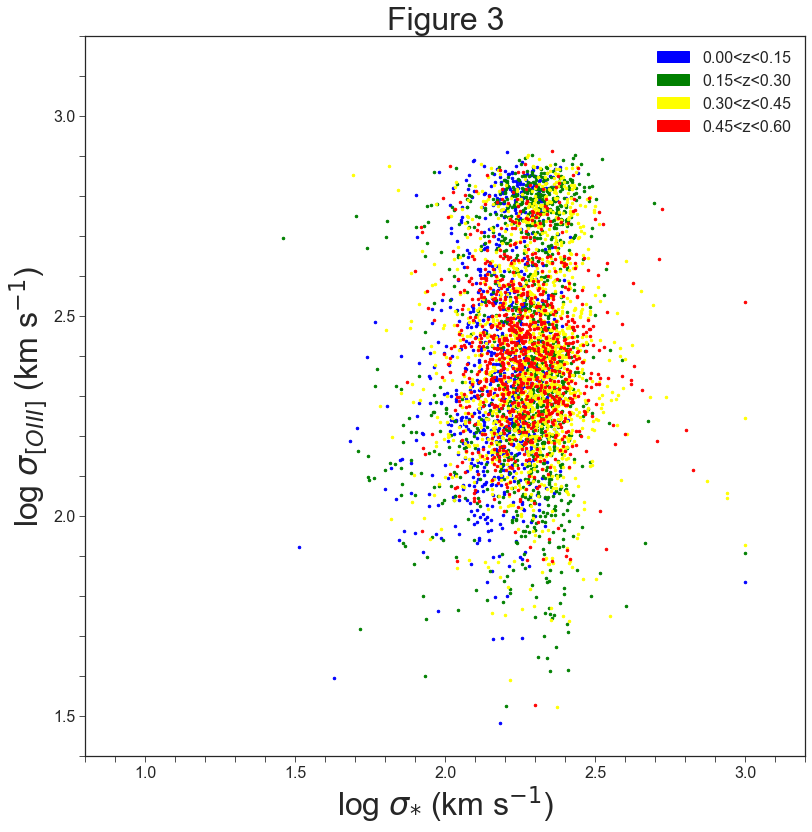

In [53]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], ylim = (1.4, 3.2), xlim = (0.8, 3.2) )

ax1.plot(zbin1_log_sigma_stars, zbin1_log_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_log_sigma_stars, zbin2_log_OIII_sigma, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_log_sigma_stars, zbin3_log_OIII_sigma, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_log_sigma_stars, zbin4_log_OIII_sigma, color = 'red',    linestyle = '', marker = '.', ms = 5)

ax1.set_yticks(np.arange(1.4, 3.3, 0.1))
ax1.set_yticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_xticks(np.arange(0.8, 3.3, 0.1))
ax1.set_xticklabels(['', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_ylabel(r'log $\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{*}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

plt.title('Figure 3', fontsize = 32)

plt.show()

In [54]:
##############################################################
############################################################## END FIG 3
##############################################################

In [55]:
##############################################################
############################################################## START FIG 4
##############################################################

In [56]:


# zbin1_results_v2 = zbin1_results_v2[select_zbin1_lum_cut & select_zbin1_edd_cut]
# zbin2_results_v2 = zbin2_results_v2[select_zbin2_lum_cut & select_zbin2_edd_cut]
# zbin3_results_v2 = zbin3_results_v2[select_zbin3_lum_cut & select_zbin3_edd_cut]
# zbin4_results_v2 = zbin4_results_v2[select_zbin4_lum_cut & select_zbin4_edd_cut]


zbin1_flags = zbin1_results_v2['FLAG']
zbin2_flags = zbin2_results_v2['FLAG']
zbin3_flags = zbin3_results_v2['FLAG']
zbin4_flags = zbin4_results_v2['FLAG']

zbin1_select_double_gaussian = (zbin1_flags == 2) | (zbin1_flags == 3)
zbin2_select_double_gaussian = (zbin2_flags == 2) | (zbin2_flags == 3)
zbin3_select_double_gaussian = (zbin3_flags == 2) | (zbin3_flags == 3)
zbin4_select_double_gaussian = (zbin4_flags == 2) | (zbin4_flags == 3)

zbin1_select_single_gaussian = (zbin1_flags == 1) | (zbin1_flags == 4)
zbin2_select_single_gaussian = (zbin2_flags == 1) | (zbin2_flags == 4)
zbin3_select_single_gaussian = (zbin3_flags == 1) | (zbin3_flags == 4)
zbin4_select_single_gaussian = (zbin4_flags == 1) | (zbin4_flags == 4)

#have all values, first calculate ratios then slice and average

zbin1_sigma_ratio = OIII_sigma_array_zbin1_good / zbin1_sigma_stars
zbin2_sigma_ratio = OIII_sigma_array_zbin2_good / zbin2_sigma_stars
zbin3_sigma_ratio = OIII_sigma_array_zbin3_good / zbin3_sigma_stars
zbin4_sigma_ratio = OIII_sigma_array_zbin4_good / zbin4_sigma_stars

zbin1_log_sigma_ratio = np.log10(zbin1_sigma_ratio)
zbin2_log_sigma_ratio = np.log10(zbin2_sigma_ratio)
zbin3_log_sigma_ratio = np.log10(zbin3_sigma_ratio)
zbin4_log_sigma_ratio = np.log10(zbin4_sigma_ratio)

##############################################################

zbin1_sg_log_sigma_ratio = zbin1_log_sigma_ratio[zbin1_select_single_gaussian]
zbin2_sg_log_sigma_ratio = zbin2_log_sigma_ratio[zbin2_select_single_gaussian]
zbin3_sg_log_sigma_ratio = zbin3_log_sigma_ratio[zbin3_select_single_gaussian]
zbin4_sg_log_sigma_ratio = zbin4_log_sigma_ratio[zbin4_select_single_gaussian]

zbin1_dg_log_sigma_ratio = zbin1_log_sigma_ratio[zbin1_select_double_gaussian]
zbin2_dg_log_sigma_ratio = zbin2_log_sigma_ratio[zbin2_select_double_gaussian]
zbin3_dg_log_sigma_ratio = zbin3_log_sigma_ratio[zbin3_select_double_gaussian]
zbin4_dg_log_sigma_ratio = zbin4_log_sigma_ratio[zbin4_select_double_gaussian]

zbin1_sg_OIII_log_lum = zbin1_OIII_log_lum_array[zbin1_select_single_gaussian]
zbin2_sg_OIII_log_lum = zbin2_OIII_log_lum_array[zbin2_select_single_gaussian]
zbin3_sg_OIII_log_lum = zbin3_OIII_log_lum_array[zbin3_select_single_gaussian]
zbin4_sg_OIII_log_lum = zbin4_OIII_log_lum_array[zbin4_select_single_gaussian]

zbin1_dg_OIII_log_lum = zbin1_OIII_log_lum_array[zbin1_select_double_gaussian]
zbin2_dg_OIII_log_lum = zbin2_OIII_log_lum_array[zbin2_select_double_gaussian]
zbin3_dg_OIII_log_lum = zbin3_OIII_log_lum_array[zbin3_select_double_gaussian]
zbin4_dg_OIII_log_lum = zbin4_OIII_log_lum_array[zbin4_select_double_gaussian]

In [57]:
sg_log_sigma_ratio = np.concatenate( ( zbin1_sg_log_sigma_ratio, zbin2_sg_log_sigma_ratio, 
                                       zbin3_sg_log_sigma_ratio, zbin4_sg_log_sigma_ratio ) )

dg_log_sigma_ratio = np.concatenate( ( zbin1_dg_log_sigma_ratio, zbin2_dg_log_sigma_ratio, 
                                       zbin3_dg_log_sigma_ratio, zbin4_dg_log_sigma_ratio ) )

##############################################################

sg_OIII_log_lum = np.concatenate( ( zbin1_sg_OIII_log_lum, zbin2_sg_OIII_log_lum, 
                                    zbin3_sg_OIII_log_lum, zbin4_sg_OIII_log_lum ) )

dg_OIII_log_lum = np.concatenate( ( zbin1_dg_OIII_log_lum, zbin2_dg_OIII_log_lum, 
                                    zbin3_dg_OIII_log_lum, zbin4_dg_OIII_log_lum ) )

In [58]:
select_sg_lumbin1 = ( sg_OIII_log_lum < 40 )
select_sg_lumbin2 = ( sg_OIII_log_lum > 40 ) & ( sg_OIII_log_lum < 41)
select_sg_lumbin3 = ( sg_OIII_log_lum > 41 ) & ( sg_OIII_log_lum < 42 )
select_sg_lumbin4 = ( sg_OIII_log_lum > 42 ) & ( sg_OIII_log_lum < 43 )
select_sg_lumbin5 = ( sg_OIII_log_lum > 43 )


select_dg_lumbin1 = ( dg_OIII_log_lum < 40 )
select_dg_lumbin2 = ( dg_OIII_log_lum > 40 ) & ( dg_OIII_log_lum < 41)
select_dg_lumbin3 = ( dg_OIII_log_lum > 41 ) & ( dg_OIII_log_lum < 42 )
select_dg_lumbin4 = ( dg_OIII_log_lum > 42 ) & ( dg_OIII_log_lum < 43 )
select_dg_lumbin5 = ( dg_OIII_log_lum > 43 )

In [59]:
lumbin1_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin1]
lumbin2_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin2]
lumbin3_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin3]
lumbin4_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin4]
lumbin5_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin5]

##############################################################

lumbin1_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin1]
lumbin2_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin2]
lumbin3_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin3]
lumbin4_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin4]
lumbin5_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin5]

##############################################################
##############################################################

lumbin1_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin1]
lumbin2_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin2]
lumbin3_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin3]
lumbin4_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin4]
lumbin5_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin5]

##############################################################

lumbin1_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin1]
lumbin2_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin2]
lumbin3_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin3]
lumbin4_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin4]
lumbin5_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin5]

In [147]:
len(dg_log_sigma_ratio) + len(sg_log_sigma_ratio)

4494

In [60]:
lumbin1_sg_mean_log_sigma_ratio = np.mean(lumbin1_sg_log_sigma_ratio)
lumbin2_sg_mean_log_sigma_ratio = np.mean(lumbin2_sg_log_sigma_ratio)
lumbin3_sg_mean_log_sigma_ratio = np.mean(lumbin3_sg_log_sigma_ratio)
lumbin4_sg_mean_log_sigma_ratio = np.mean(lumbin4_sg_log_sigma_ratio)
lumbin5_sg_mean_log_sigma_ratio = np.mean(lumbin5_sg_log_sigma_ratio)

##############################################################

lumbin1_sg_std_log_sigma_ratio = np.std(lumbin1_sg_log_sigma_ratio)
lumbin2_sg_std_log_sigma_ratio = np.std(lumbin2_sg_log_sigma_ratio)
lumbin3_sg_std_log_sigma_ratio = np.std(lumbin3_sg_log_sigma_ratio)
lumbin4_sg_std_log_sigma_ratio = np.std(lumbin4_sg_log_sigma_ratio)
lumbin5_sg_std_log_sigma_ratio = np.std(lumbin5_sg_log_sigma_ratio)

##############################################################
##############################################################

lumbin1_dg_mean_log_sigma_ratio = np.mean(lumbin1_dg_log_sigma_ratio)
lumbin2_dg_mean_log_sigma_ratio = np.mean(lumbin2_dg_log_sigma_ratio)
lumbin3_dg_mean_log_sigma_ratio = np.mean(lumbin3_dg_log_sigma_ratio)
lumbin4_dg_mean_log_sigma_ratio = np.mean(lumbin4_dg_log_sigma_ratio)
lumbin5_dg_mean_log_sigma_ratio = np.mean(lumbin5_dg_log_sigma_ratio)

##############################################################

lumbin1_dg_std_log_sigma_ratio = np.std(lumbin1_dg_log_sigma_ratio)
lumbin2_dg_std_log_sigma_ratio = np.std(lumbin2_dg_log_sigma_ratio)
lumbin3_dg_std_log_sigma_ratio = np.std(lumbin3_dg_log_sigma_ratio)
lumbin4_dg_std_log_sigma_ratio = np.std(lumbin4_dg_log_sigma_ratio)
lumbin5_dg_std_log_sigma_ratio = np.std(lumbin5_dg_log_sigma_ratio)

In [61]:
fig4_xaxis = np.array([39.5, 40.5, 41.5, 42.5, 43.5])
fig4_sg_yvalues = np.array([lumbin1_sg_mean_log_sigma_ratio, lumbin2_sg_mean_log_sigma_ratio, 
                            lumbin3_sg_mean_log_sigma_ratio, lumbin4_sg_mean_log_sigma_ratio,
                            lumbin5_sg_mean_log_sigma_ratio])

fig4_sg_yerror  = np.array([lumbin1_sg_std_log_sigma_ratio, lumbin2_sg_std_log_sigma_ratio, 
                            lumbin3_sg_std_log_sigma_ratio, lumbin4_sg_std_log_sigma_ratio,
                            lumbin5_sg_std_log_sigma_ratio])

fig4_dg_yvalues = np.array([lumbin1_dg_mean_log_sigma_ratio, lumbin2_dg_mean_log_sigma_ratio, 
                            lumbin3_dg_mean_log_sigma_ratio, lumbin4_dg_mean_log_sigma_ratio,
                            lumbin5_dg_mean_log_sigma_ratio])

fig4_dg_yerror  = np.array([lumbin1_dg_std_log_sigma_ratio, lumbin2_dg_std_log_sigma_ratio, 
                            lumbin3_dg_std_log_sigma_ratio, lumbin4_dg_std_log_sigma_ratio,
                            lumbin5_dg_std_log_sigma_ratio])

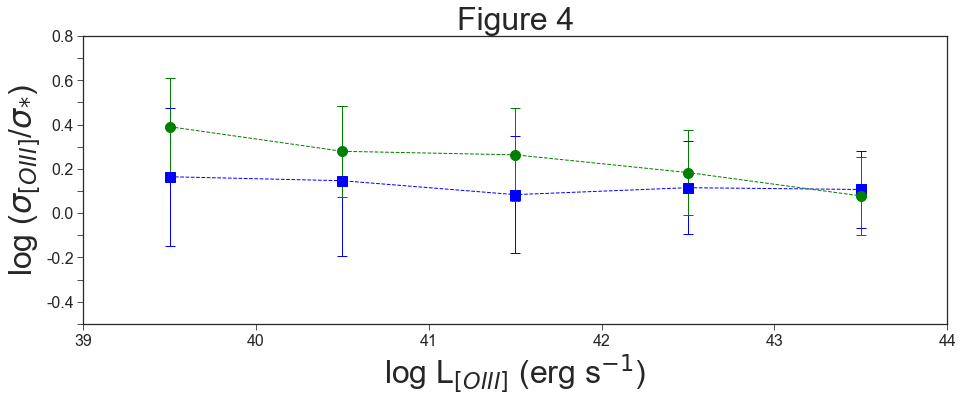

In [62]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 2, 1],)

ax1.errorbar(fig4_xaxis, fig4_sg_yvalues, fig4_sg_yerror, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax1.errorbar(fig4_xaxis, fig4_dg_yvalues, fig4_dg_yerror, color = 'green', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5, label = 'Seyferts')


ax1.set_yticks(np.arange(-0.5, 0.9, 0.1))
ax1.set_yticklabels(['', -0.4, '', -0.2, '', 0.0, '', 0.2, '', 0.4, '', 0.6, '', 0.8], fontsize = 16)
ax1.set_ylabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)

ax1.set_xticks([39, 40, 41, 42, 43, 44])
ax1.set_xticklabels([39, 40, 41, 42, 43, 44], fontsize = 16)
ax1.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)


ax1.set_title('Figure 4', fontsize = 32)

plt.show()

In [132]:
print(fig4_dg_yvalues)
print(fig4_dg_yerror)
print('')
print(fig4_sg_yvalues)
print(fig4_sg_yerror)

[0.39014634 0.27906556 0.26321981 0.1830697  0.07774637]
[0.21834912 0.20528877 0.20918858 0.19274739 0.1770923 ]

[0.16431437 0.14626265 0.08349004 0.11481873 0.10678298]
[0.31234056 0.33837279 0.26269467 0.21119426 0.17546703]


In [63]:
##############################################################
############################################################## END FIG 4
##############################################################

In [64]:
##############################################################
############################################################## START FIG 5
##############################################################

In [65]:
OIII_log_lum = np.concatenate((zbin1_OIII_log_lum_array, zbin2_OIII_log_lum_array, 
                               zbin3_OIII_log_lum_array, zbin4_OIII_log_lum_array))

log_OIII_sigma = np.concatenate((zbin1_log_OIII_sigma, zbin2_log_OIII_sigma, 
                                 zbin3_log_OIII_sigma, zbin4_log_OIII_sigma))

In [66]:
select_lumbin1 = ( OIII_log_lum < 40 )
select_lumbin2 = ( OIII_log_lum > 40 ) & ( OIII_log_lum < 41 )
select_lumbin3 = ( OIII_log_lum > 41 ) & ( OIII_log_lum < 42 )
select_lumbin4 = ( OIII_log_lum > 42 ) & ( OIII_log_lum < 43 )
select_lumbin5 = ( OIII_log_lum > 43 )
# select_lumbin6 = ( OIII_log_lum > 43.5 )

In [67]:
lumbin1_log_OIII_sigma = log_OIII_sigma[select_lumbin1]
lumbin2_log_OIII_sigma = log_OIII_sigma[select_lumbin2]
lumbin3_log_OIII_sigma = log_OIII_sigma[select_lumbin3]
lumbin4_log_OIII_sigma = log_OIII_sigma[select_lumbin4]
lumbin5_log_OIII_sigma = log_OIII_sigma[select_lumbin5]

mean_log_OIII_sigma_fig5 = np.array([np.mean(lumbin1_log_OIII_sigma), np.mean(lumbin2_log_OIII_sigma),
                                     np.mean(lumbin3_log_OIII_sigma), np.mean(lumbin4_log_OIII_sigma),
                                     np.mean(lumbin5_log_OIII_sigma)])

std_log_OIII_sigma_fig5  = np.array([np.std(lumbin1_log_OIII_sigma), np.std(lumbin2_log_OIII_sigma),
                                     np.std(lumbin3_log_OIII_sigma), np.std(lumbin4_log_OIII_sigma),
                                     np.std(lumbin5_log_OIII_sigma)])

log_lum_yaxis_fig5 = np.array([39.5, 40.5, 41.5, 42.5, 43.5])

In [68]:
log_edd_ratio   = np.concatenate((zbin1_log_edd_ratio, zbin2_log_edd_ratio,
                                  zbin3_log_edd_ratio, zbin4_log_edd_ratio))

log_sigma_ratio = np.concatenate((zbin1_log_sigma_ratio, zbin2_log_sigma_ratio,
                                  zbin3_log_sigma_ratio, zbin4_log_sigma_ratio))

In [69]:
array_summary(log_edd_ratio)

             Count:   4517
              Mean:   -1.0614284743098958
            Median:   -1.0980109463804262
Standard Deviation:   0.9649017494165972
           Minimum:   -4.7841555185477755
           Maximum:   0.9962655483993261


In [70]:
select_eddbin1  = ( log_edd_ratio < -3.5 )
select_eddbin2  = ( log_edd_ratio < -2.5 ) & ( log_edd_ratio > -3.5 )
select_eddbin3  = ( log_edd_ratio < -1.5 ) & ( log_edd_ratio > -2.5 )
select_eddbin4  = ( log_edd_ratio < -0.5 ) & ( log_edd_ratio > -1.5 )
select_eddbin5  = ( log_edd_ratio <  0.5 ) & ( log_edd_ratio > -0.5 )
select_eddbin6  = ( log_edd_ratio >  0.5 )


In [71]:
eddbin1_log_sigma_ratio  = log_sigma_ratio[select_eddbin1]
eddbin2_log_sigma_ratio  = log_sigma_ratio[select_eddbin2]
eddbin3_log_sigma_ratio  = log_sigma_ratio[select_eddbin3]
eddbin4_log_sigma_ratio  = log_sigma_ratio[select_eddbin4]
eddbin5_log_sigma_ratio  = log_sigma_ratio[select_eddbin5]
eddbin6_log_sigma_ratio  = log_sigma_ratio[select_eddbin6]

##############################################################

log_edd_ratio_yaxis_fig5 = np.array([-4, -3, -2, -1, 0, 1])

##############################################################

mean_log_sigma_ratio_fig5 = np.array([np.mean(eddbin1_log_sigma_ratio), np.mean(eddbin2_log_sigma_ratio),
                                      np.mean(eddbin3_log_sigma_ratio), np.mean(eddbin4_log_sigma_ratio),
                                      np.mean(eddbin5_log_sigma_ratio), np.mean(eddbin6_log_sigma_ratio)])

std_log_sigma_ratio_fig5 = np.array([np.std(eddbin1_log_sigma_ratio), np.std(eddbin2_log_sigma_ratio),
                                     np.std(eddbin3_log_sigma_ratio), np.std(eddbin4_log_sigma_ratio),
                                     np.std(eddbin5_log_sigma_ratio), np.std(eddbin6_log_sigma_ratio)])

##############################################################

In [158]:
len(eddbin6_log_sigma_ratio)

296

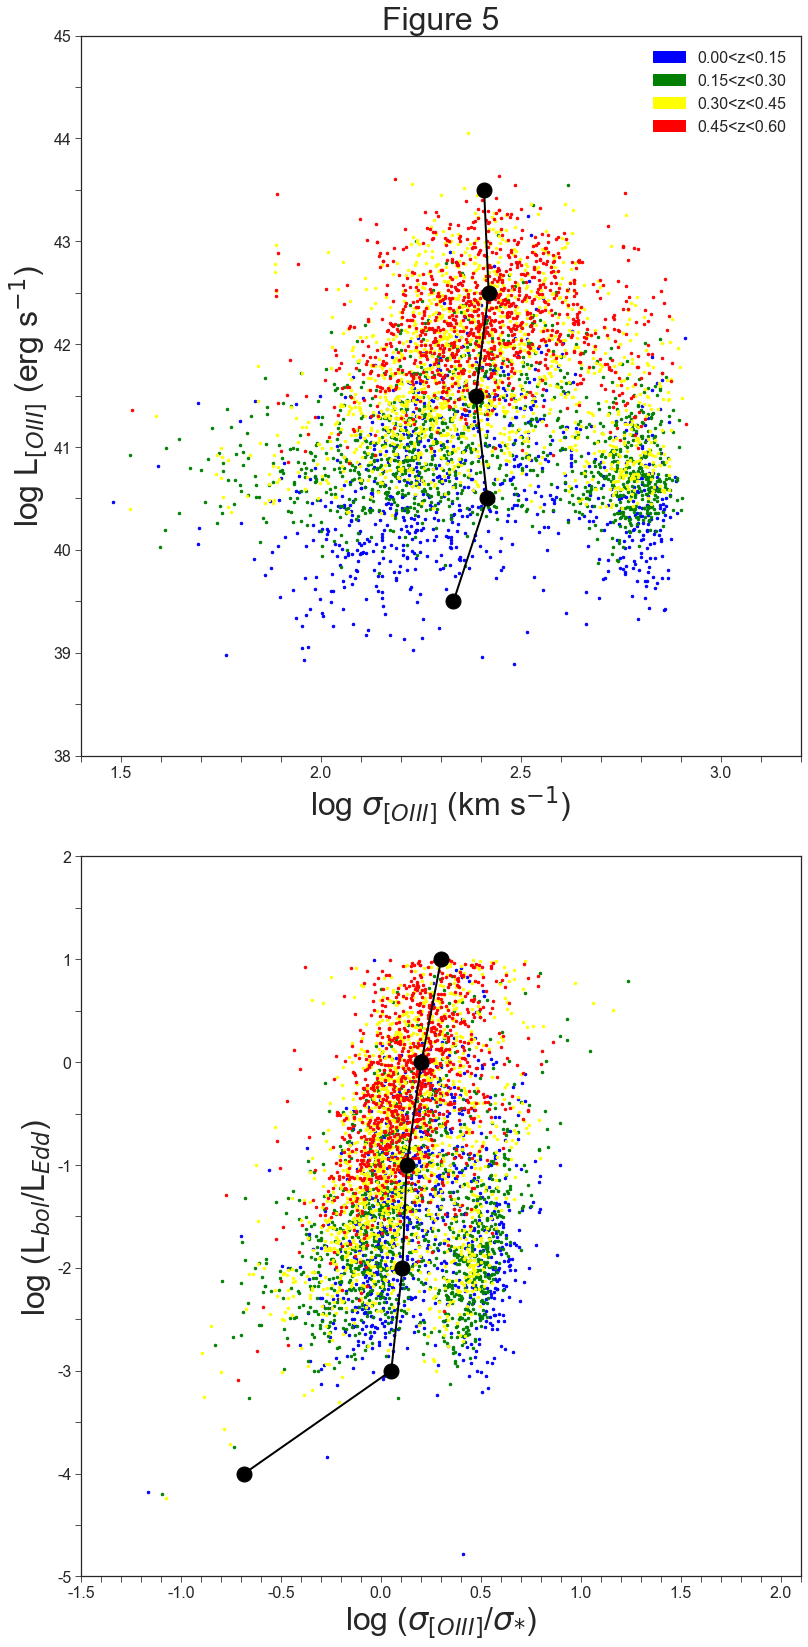

In [72]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1],     xlim = ( 1.4, 3.2), ylim = (38, 45) )
ax2 = fig.add_axes([0, -1.14, 1, 1], xlim = (-1.5, 2.1), ylim = (-5,  2))

ax1.plot(zbin1_log_OIII_sigma, zbin1_OIII_log_lum_array, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_log_OIII_sigma, zbin2_OIII_log_lum_array, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_log_OIII_sigma, zbin3_OIII_log_lum_array, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_log_OIII_sigma, zbin4_OIII_log_lum_array, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_log_OIII_sigma_fig5, log_lum_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax1.set_xticks(np.arange(1.4, 3.3, 0.1))
ax1.set_xticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_yticks(np.arange(38, 45.5, 0.5))
ax1.set_yticklabels([38, '', 39, '', 40, '', 41, '', 42, '', 43, '', 44, '', 45], fontsize = 16)

ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.set_title('Figure 5', fontsize = 32)

##############################################################

ax2.plot(zbin1_log_sigma_ratio, zbin1_log_edd_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin2_log_sigma_ratio, zbin2_log_edd_ratio, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin3_log_sigma_ratio, zbin3_log_edd_ratio, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin4_log_sigma_ratio, zbin4_log_edd_ratio, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax2.errorbar(mean_log_sigma_ratio_fig5, log_edd_ratio_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax2.set_xticks(np.arange(-1.5, 2.2, 0.1))
ax2.set_xticklabels([-1.5, '', '', '', '', -1.0, '', '', '', '', -0.5, '', '', '', '', 0.0, '', '', '', '', 0.5, '', '', '', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, ''], fontsize = 16)

ax2.set_yticks(np.arange(-5, 2.5, 0.5))
ax2.set_yticklabels([-5, '', -4, '', -3, '', -2, '', -1, '', 0, '', 1, '', 2], fontsize = 16)

ax2.set_xlabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)
ax2.set_ylabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [73]:
##############################################################
############################################################## END FIG 5
##############################################################

In [74]:
##############################################################
############################################################## START FIG 5
##############################################################

In [169]:
# zbin1_vel_shift = zbin1_results_v2['VELSHIFT']
# zbin2_vel_shift = zbin2_results_v2['VELSHIFT']
# zbin3_vel_shift = zbin3_results_v2['VELSHIFT']
# zbin4_vel_shift = zbin4_results_v2['VELSHIFT']

zbin1_vel_shift = zbin1_vs
zbin2_vel_shift = zbin2_vs
zbin3_vel_shift = zbin3_vs
zbin4_vel_shift = zbin4_vs

vel_shift = np.concatenate((zbin1_vel_shift, zbin2_vel_shift, zbin3_vel_shift, zbin4_vel_shift))

In [170]:
lumbin1_vel_shift = vel_shift[select_lumbin1]
lumbin2_vel_shift = vel_shift[select_lumbin2]
lumbin3_vel_shift = vel_shift[select_lumbin3]
lumbin4_vel_shift = vel_shift[select_lumbin4]
lumbin5_vel_shift = vel_shift[select_lumbin5]

# lumbin1_vel_shift = lumbin1_vel_shift[lumbin1_vel_shift != 0]
# lumbin2_vel_shift = lumbin2_vel_shift[lumbin2_vel_shift != 0]
# lumbin3_vel_shift = lumbin3_vel_shift[lumbin3_vel_shift != 0]
# lumbin4_vel_shift = lumbin4_vel_shift[lumbin4_vel_shift != 0]
# lumbin5_vel_shift = lumbin5_vel_shift[lumbin5_vel_shift != 0]
# lumbin6_vel_shift = lumbin6_vel_shift[lumbin6_vel_shift != 0]

In [171]:
mean_vel_shift_fig6 = np.array([np.mean(lumbin1_vel_shift), np.mean(lumbin2_vel_shift),
                                np.mean(lumbin3_vel_shift[lumbin3_vel_shift < 1000]), np.mean(lumbin4_vel_shift),
                                np.mean(lumbin5_vel_shift)])

std_vel_shift_fig6 = np.array([np.std(lumbin1_vel_shift), np.std(lumbin2_vel_shift),
                               np.std(lumbin3_vel_shift[lumbin3_vel_shift < 1000]), np.std(lumbin4_vel_shift),
                               np.std(lumbin5_vel_shift)])

log_lum_yaxis_fig6 = log_lum_yaxis_fig5

In [173]:
std_vel_shift_fig6

array([100.87981873, 108.12488141, 137.94006455, 150.58317594,
       171.02399355])

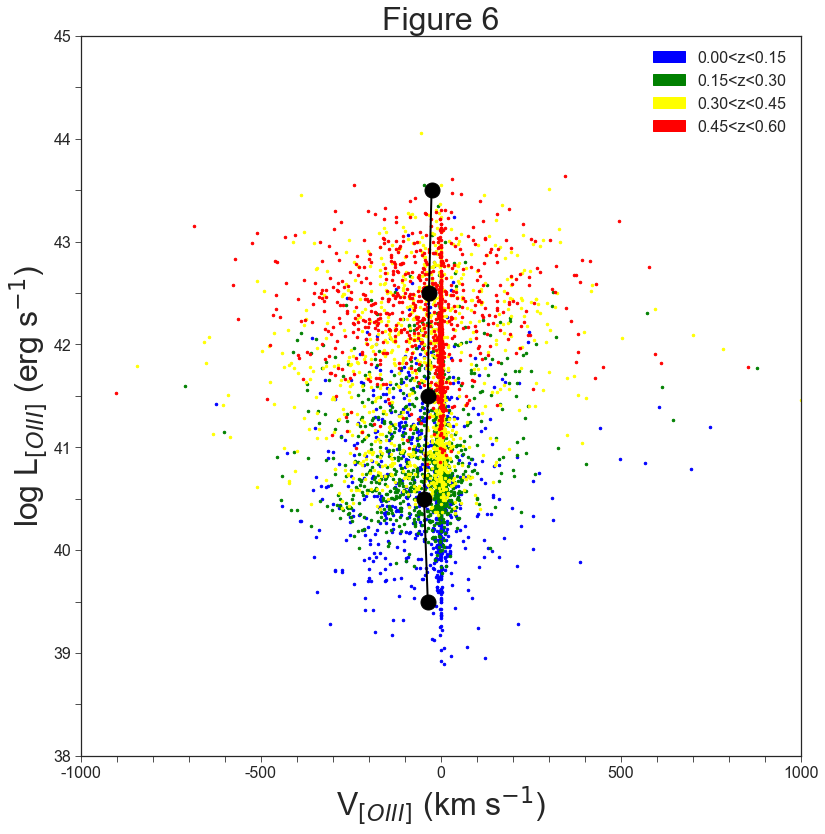

In [174]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], xlim = (-1000, 1000), ylim = (38, 45) )
# ax2 = fig.add_axes([0, -1.14, 1, 1], xlim = (-1.5, 2.1), ylim = (-5,  8))

ax1.plot(zbin1_vel_shift, zbin1_OIII_log_lum_array, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_vel_shift, zbin2_OIII_log_lum_array, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_vel_shift, zbin3_OIII_log_lum_array, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_vel_shift, zbin4_OIII_log_lum_array, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_vel_shift_fig6, log_lum_yaxis_fig6, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax1.set_xticks(np.arange(-1000, 1100, 100))
ax1.set_xticklabels([-1000, '', '', '', '', -500, '', '', '', '', 0, '', '', '', '', 500, '', '', '', '', 1000], fontsize = 16)

ax1.set_yticks(np.arange(38, 45.5, 0.5))
ax1.set_yticklabels([38, '', 39, '', 40, '', 41, '', 42, '', 43, '', 44, '', 45], fontsize = 16)

ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.set_title('Figure 6', fontsize = 32)

plt.show()

In [79]:
##############################################################
############################################################## END FIG 6
##############################################################

In [80]:
##############################################################
############################################################## START FIG 7
##############################################################

In [81]:
#stitch together sigma OIII, and vel_shift, and flags

In [82]:
OIII_sigma    = np.concatenate((OIII_sigma_array_zbin1_good, OIII_sigma_array_zbin2_good,
                             OIII_sigma_array_zbin3_good, OIII_sigma_array_zbin4_good))

vel_shift     = np.concatenate((zbin1_vel_shift, zbin2_vel_shift,
                                zbin3_vel_shift, zbin4_vel_shift))

results_flags = np.concatenate((zbin1_flags, zbin2_flags,
                                zbin3_flags, zbin4_flags))

In [83]:
select_sg_fig7 = ( results_flags == 0 ) | ( results_flags == 1 ) | ( results_flags == 4 )
select_dg_fig7 = ( results_flags == 2 ) | ( results_flags == 3 )

In [84]:
sg_OIII_sigma = OIII_sigma[select_sg_fig7]
dg_OIII_sigma = OIII_sigma[select_dg_fig7]

sg_vel_shift  = vel_shift[select_sg_fig7]
dg_vel_shift  = vel_shift[select_dg_fig7]

In [85]:
select_sg_sigmabin1 = (sg_OIII_sigma < 200)
select_sg_sigmabin2 = (sg_OIII_sigma < 300) & (sg_OIII_sigma > 200)
select_sg_sigmabin3 = (sg_OIII_sigma < 400) & (sg_OIII_sigma > 300)
select_sg_sigmabin4 = (sg_OIII_sigma < 500) & (sg_OIII_sigma > 400)
select_sg_sigmabin5 = (sg_OIII_sigma < 600) & (sg_OIII_sigma > 500)
select_sg_sigmabin6 = (sg_OIII_sigma < 700) & (sg_OIII_sigma > 600)
select_sg_sigmabin7 = (sg_OIII_sigma > 700)

select_dg_sigmabin1 = (dg_OIII_sigma < 200)
select_dg_sigmabin2 = (dg_OIII_sigma < 300) & (dg_OIII_sigma > 200)
select_dg_sigmabin3 = (dg_OIII_sigma < 400) & (dg_OIII_sigma > 300)
select_dg_sigmabin4 = (dg_OIII_sigma < 500) & (dg_OIII_sigma > 400)
select_dg_sigmabin5 = (dg_OIII_sigma < 600) & (dg_OIII_sigma > 500)
select_dg_sigmabin6 = (dg_OIII_sigma < 700) & (dg_OIII_sigma > 600)
select_dg_sigmabin7 = (dg_OIII_sigma > 700)

In [86]:
sigmabin1_sg_vel_shift = sg_vel_shift[select_sg_sigmabin1]
sigmabin2_sg_vel_shift = sg_vel_shift[select_sg_sigmabin2]
sigmabin3_sg_vel_shift = sg_vel_shift[select_sg_sigmabin3]
sigmabin4_sg_vel_shift = sg_vel_shift[select_sg_sigmabin4]
sigmabin5_sg_vel_shift = sg_vel_shift[select_sg_sigmabin5]
sigmabin6_sg_vel_shift = sg_vel_shift[select_sg_sigmabin6]
sigmabin7_sg_vel_shift = sg_vel_shift[select_sg_sigmabin7]

##############################################################

sigmabin1_dg_vel_shift = dg_vel_shift[select_dg_sigmabin1]
sigmabin2_dg_vel_shift = dg_vel_shift[select_dg_sigmabin2]
sigmabin3_dg_vel_shift = dg_vel_shift[select_dg_sigmabin3]
sigmabin4_dg_vel_shift = dg_vel_shift[select_dg_sigmabin4]
sigmabin5_dg_vel_shift = dg_vel_shift[select_dg_sigmabin5]
sigmabin6_dg_vel_shift = dg_vel_shift[select_dg_sigmabin6]
sigmabin7_dg_vel_shift = dg_vel_shift[select_dg_sigmabin7]

In [177]:
mean_sg_velshift_fig7  = np.array([np.mean(sigmabin1_sg_vel_shift[sigmabin1_sg_vel_shift<1000]), np.mean(sigmabin2_sg_vel_shift), np.mean(sigmabin3_sg_vel_shift),
                                   np.mean(sigmabin4_sg_vel_shift), np.mean(sigmabin5_sg_vel_shift), np.mean(sigmabin6_sg_vel_shift), 
                                   np.mean(sigmabin7_sg_vel_shift)])

std_sg_velshift_fig7  = np.array([np.std(sigmabin1_sg_vel_shift[sigmabin1_sg_vel_shift<1000]), np.std(sigmabin2_sg_vel_shift), np.std(sigmabin3_sg_vel_shift),
                                  np.std(sigmabin4_sg_vel_shift), np.std(sigmabin5_sg_vel_shift), np.std(sigmabin6_sg_vel_shift), 
                                  np.std(sigmabin7_sg_vel_shift)])

##############################################################

mean_dg_velshift_fig7  = np.array([np.mean(sigmabin1_dg_vel_shift), np.mean(sigmabin2_dg_vel_shift), np.mean(sigmabin3_dg_vel_shift),
                                   np.mean(sigmabin4_dg_vel_shift), np.mean(sigmabin5_dg_vel_shift), np.mean(sigmabin6_dg_vel_shift), 
                                   np.mean(sigmabin7_dg_vel_shift)])

std_dg_velshift_fig7  = np.array([np.std(sigmabin1_dg_vel_shift), np.std(sigmabin2_dg_vel_shift), np.std(sigmabin3_dg_vel_shift),
                                  np.std(sigmabin4_dg_vel_shift), np.std(sigmabin5_dg_vel_shift), np.std(sigmabin6_dg_vel_shift), 
                                  np.std(sigmabin7_dg_vel_shift)])

In [199]:
len(sigmabin7_dg_vel_shift)

19

In [88]:
OIII_sigma_yaxis_fig7 = np.array([150, 250, 350, 450, 550, 650, 750])

In [89]:
len(mean_sg_velshift_fig7)

7

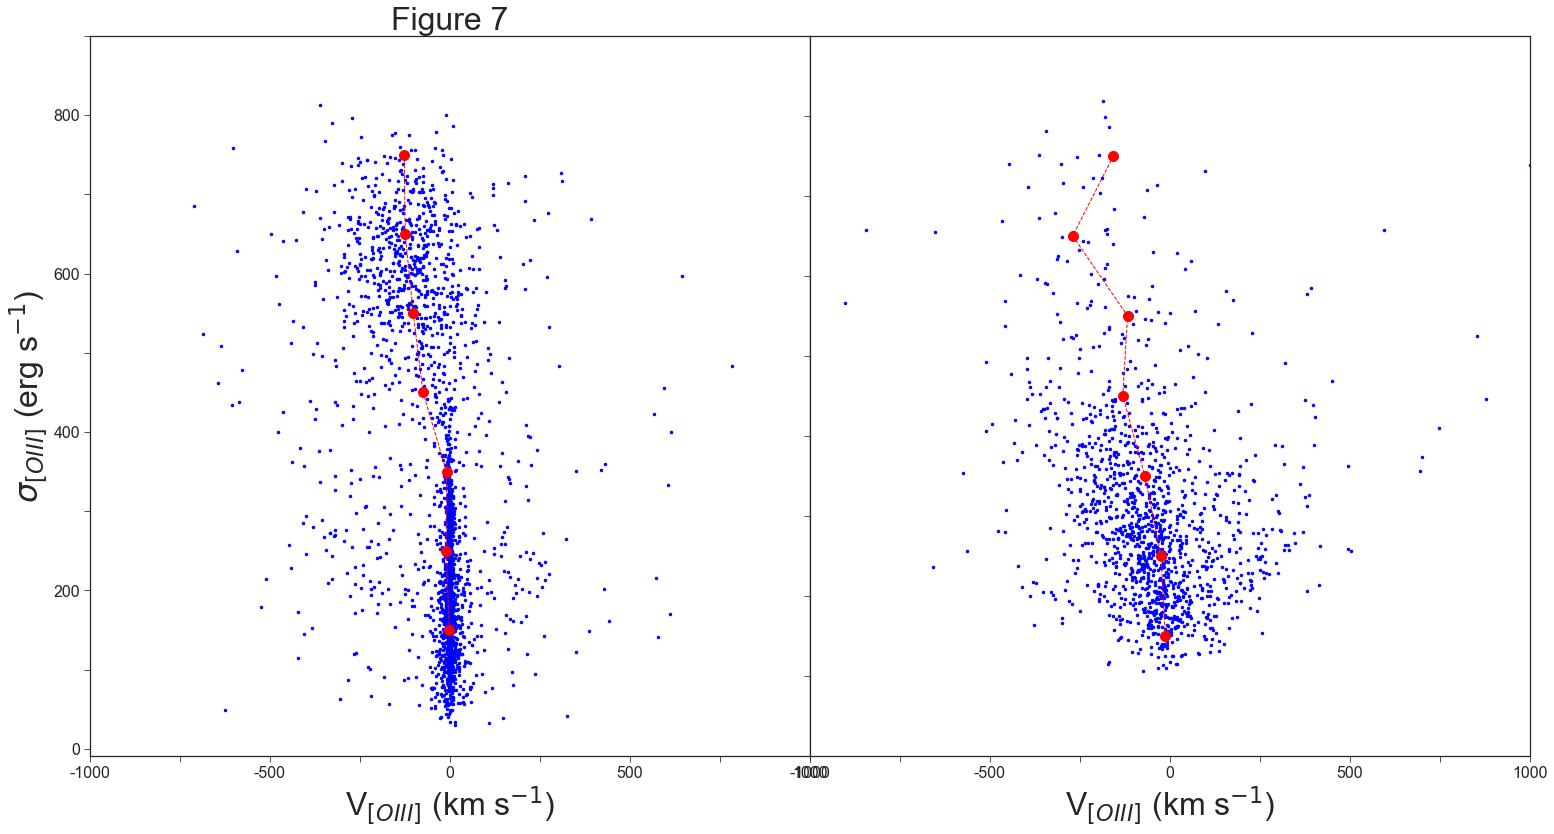

In [190]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], xlim = (-1000,1000))
ax2 = fig.add_axes([1, 0, 1, 1], xlim = (-1000,1000))

ax1.plot(sg_vel_shift, sg_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_sg_velshift_fig7, OIII_sigma_yaxis_fig7, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)


ax1.set_xticks(np.arange(-1000, 1250, 250))
ax1.set_xticklabels([-1000, '', -500, '', 0, '', 500, '', 1000], fontsize = 16)
ax1.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax1.set_yticks(np.arange(0,1000,100))
ax1.set_yticklabels([0, '', 200, '', 400, '', 600, '', 800, ''], fontsize = 16)

##############################################################

ax2.plot(dg_vel_shift, dg_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2.errorbar(mean_dg_velshift_fig7[0:7], OIII_sigma_yaxis_fig7[0:7], color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2.set_yticks(np.arange(0,1000,100))
ax2.set_yticklabels([], fontsize = 16)
ax2.set_xticks(np.arange(-1000, 1250, 250))
ax2.set_xticklabels([-1000, '', -500, '', 0, '', 500, '', 1000], fontsize = 16)
ax2.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

ax1.set_ylabel(r'$\sigma$$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)

ax1.set_title('Figure 7', fontsize = 32)

plt.show()

In [91]:
##############################################################
############################################################## END FIG 7
##############################################################

In [92]:
############################################################## 
############################################################## START FIG 8
############################################################## 

In [93]:
OIII_sigma_fig8 = np.concatenate((OIII_sigma_array_zbin1_good, OIII_sigma_array_zbin2_good,
                                  OIII_sigma_array_zbin3_good, OIII_sigma_array_zbin4_good))

log_sigma_ratio_fig8 = np.concatenate((zbin1_log_sigma_ratio, zbin2_log_sigma_ratio,
                                       zbin3_log_sigma_ratio, zbin4_log_sigma_ratio))

vel_shift_fig8 = vel_shift

In [94]:
lumbin1_OIII_sigma = OIII_sigma_fig8[select_lumbin1]
lumbin2_OIII_sigma = OIII_sigma_fig8[select_lumbin2]
lumbin3_OIII_sigma = OIII_sigma_fig8[select_lumbin3]
lumbin4_OIII_sigma = OIII_sigma_fig8[select_lumbin4]
lumbin5_OIII_sigma = OIII_sigma_fig8[select_lumbin5]

lumbin1_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin1]
lumbin2_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin2]
lumbin3_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin3]
lumbin4_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin4]
lumbin5_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin5]

lumbin1_vel_shift = vel_shift_fig8[select_lumbin1]
lumbin2_vel_shift = vel_shift_fig8[select_lumbin2]
lumbin3_vel_shift = vel_shift_fig8[select_lumbin3]
lumbin4_vel_shift = vel_shift_fig8[select_lumbin4]
lumbin5_vel_shift = vel_shift_fig8[select_lumbin5]

In [95]:
select_lumbin1_sigmabin1 = (lumbin1_OIII_sigma < 200)
select_lumbin1_sigmabin2 = (lumbin1_OIII_sigma < 300) & (lumbin1_OIII_sigma > 200)
select_lumbin1_sigmabin3 = (lumbin1_OIII_sigma < 400) & (lumbin1_OIII_sigma > 300)
select_lumbin1_sigmabin4 = (lumbin1_OIII_sigma < 500) & (lumbin1_OIII_sigma > 400)
select_lumbin1_sigmabin5 = (lumbin1_OIII_sigma < 600) & (lumbin1_OIII_sigma > 500)
select_lumbin1_sigmabin6 = (lumbin1_OIII_sigma < 700) & (lumbin1_OIII_sigma > 600)
select_lumbin1_sigmabin7 = (lumbin1_OIII_sigma > 700)

select_lumbin2_sigmabin1 = (lumbin2_OIII_sigma < 200)
select_lumbin2_sigmabin2 = (lumbin2_OIII_sigma < 300) & (lumbin2_OIII_sigma > 200)
select_lumbin2_sigmabin3 = (lumbin2_OIII_sigma < 400) & (lumbin2_OIII_sigma > 300)
select_lumbin2_sigmabin4 = (lumbin2_OIII_sigma < 500) & (lumbin2_OIII_sigma > 400)
select_lumbin2_sigmabin5 = (lumbin2_OIII_sigma < 600) & (lumbin2_OIII_sigma > 500)
select_lumbin2_sigmabin6 = (lumbin2_OIII_sigma < 700) & (lumbin2_OIII_sigma > 600)
select_lumbin2_sigmabin7 = (lumbin2_OIII_sigma > 700)

select_lumbin3_sigmabin1 = (lumbin3_OIII_sigma < 200)
select_lumbin3_sigmabin2 = (lumbin3_OIII_sigma < 300) & (lumbin3_OIII_sigma > 200)
select_lumbin3_sigmabin3 = (lumbin3_OIII_sigma < 400) & (lumbin3_OIII_sigma > 300)
select_lumbin3_sigmabin4 = (lumbin3_OIII_sigma < 500) & (lumbin3_OIII_sigma > 400)
select_lumbin3_sigmabin5 = (lumbin3_OIII_sigma < 600) & (lumbin3_OIII_sigma > 500)
select_lumbin3_sigmabin6 = (lumbin3_OIII_sigma < 700) & (lumbin3_OIII_sigma > 600)
select_lumbin3_sigmabin7 = (lumbin3_OIII_sigma > 700)

select_lumbin4_sigmabin1 = (lumbin4_OIII_sigma < 200)
select_lumbin4_sigmabin2 = (lumbin4_OIII_sigma < 300) & (lumbin4_OIII_sigma > 200)
select_lumbin4_sigmabin3 = (lumbin4_OIII_sigma < 400) & (lumbin4_OIII_sigma > 300)
select_lumbin4_sigmabin4 = (lumbin4_OIII_sigma < 500) & (lumbin4_OIII_sigma > 400)
select_lumbin4_sigmabin5 = (lumbin4_OIII_sigma < 600) & (lumbin4_OIII_sigma > 500)
select_lumbin4_sigmabin6 = (lumbin4_OIII_sigma < 700) & (lumbin4_OIII_sigma > 600)
select_lumbin4_sigmabin7 = (lumbin4_OIII_sigma > 700)

select_lumbin5_sigmabin1 = (lumbin5_OIII_sigma < 200)
select_lumbin5_sigmabin2 = (lumbin5_OIII_sigma < 300) & (lumbin5_OIII_sigma > 200)
select_lumbin5_sigmabin3 = (lumbin5_OIII_sigma < 400) & (lumbin5_OIII_sigma > 300)
select_lumbin5_sigmabin4 = (lumbin5_OIII_sigma < 500) & (lumbin5_OIII_sigma > 400)
select_lumbin5_sigmabin5 = (lumbin5_OIII_sigma < 600) & (lumbin5_OIII_sigma > 500)
select_lumbin5_sigmabin6 = (lumbin5_OIII_sigma > 600)

In [201]:
lumbin1_sigmabin1_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin1]
lumbin1_sigmabin2_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin2]
lumbin1_sigmabin3_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin3]
lumbin1_sigmabin4_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin4]
lumbin1_sigmabin5_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin5]
lumbin1_sigmabin6_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin6]
lumbin1_sigmabin7_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin7]

lumbin2_sigmabin1_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin1]
lumbin2_sigmabin2_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin2]
lumbin2_sigmabin3_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin3]
lumbin2_sigmabin4_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin4]
lumbin2_sigmabin5_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin5]
lumbin2_sigmabin6_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin6]
lumbin2_sigmabin7_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin7]

lumbin3_sigmabin1_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin1]
lumbin3_sigmabin2_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin2]
lumbin3_sigmabin3_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin3]
lumbin3_sigmabin4_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin4]
lumbin3_sigmabin5_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin5]
lumbin3_sigmabin6_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin6]
lumbin3_sigmabin7_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin7]

lumbin4_sigmabin1_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin1]
lumbin4_sigmabin2_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin2]
lumbin4_sigmabin3_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin3]
lumbin4_sigmabin4_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin4]
lumbin4_sigmabin5_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin5]
lumbin4_sigmabin6_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin6]
lumbin4_sigmabin7_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin7]

lumbin5_sigmabin1_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin1]
lumbin5_sigmabin2_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin2]
lumbin5_sigmabin3_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin3]
lumbin5_sigmabin4_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin4]
lumbin5_sigmabin5_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin5]
lumbin5_sigmabin6_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin6]

fig8a_OIII_sigma_yaxis = np.array([150, 250, 350, 450, 550, 650, 750])
fig8a_OIII_sigma_yaxis_1 = np.array([150, 250, 350, 450, 550, 650])

##############################################################

lumbin1_mean_vel_shifta = np.array([np.mean(lumbin1_sigmabin1_vel_shift), np.mean(lumbin1_sigmabin2_vel_shift),
                                   np.mean(lumbin1_sigmabin3_vel_shift), np.mean(lumbin1_sigmabin4_vel_shift),
                                   np.mean(lumbin1_sigmabin5_vel_shift), np.mean(lumbin1_sigmabin6_vel_shift),
                                   np.mean(lumbin1_sigmabin7_vel_shift)])

lumbin1_std_vel_shifta = np.array([np.std(lumbin1_sigmabin1_vel_shift), np.std(lumbin1_sigmabin2_vel_shift),
                                  np.std(lumbin1_sigmabin3_vel_shift), np.std(lumbin1_sigmabin4_vel_shift),
                                  np.std(lumbin1_sigmabin5_vel_shift), np.std(lumbin1_sigmabin6_vel_shift),
                                  np.std(lumbin1_sigmabin7_vel_shift)])

##############################################################

lumbin2_mean_vel_shifta = np.array([np.mean(lumbin2_sigmabin1_vel_shift), np.mean(lumbin2_sigmabin2_vel_shift),
                                   np.mean(lumbin2_sigmabin3_vel_shift), np.mean(lumbin2_sigmabin4_vel_shift),
                                   np.mean(lumbin2_sigmabin5_vel_shift), np.mean(lumbin2_sigmabin6_vel_shift),
                                   np.mean(lumbin2_sigmabin7_vel_shift)])

lumbin2_std_vel_shifta = np.array([np.std(lumbin2_sigmabin1_vel_shift), np.std(lumbin2_sigmabin2_vel_shift),
                                  np.std(lumbin2_sigmabin3_vel_shift), np.std(lumbin2_sigmabin4_vel_shift),
                                  np.std(lumbin2_sigmabin5_vel_shift), np.std(lumbin2_sigmabin6_vel_shift),
                                  np.std(lumbin2_sigmabin7_vel_shift)])

##############################################################

lumbin3_mean_vel_shifta = np.array([np.mean(lumbin3_sigmabin1_vel_shift[lumbin3_sigmabin1_vel_shift < 1000]), np.mean(lumbin3_sigmabin2_vel_shift),
                                   np.mean(lumbin3_sigmabin3_vel_shift), np.mean(lumbin3_sigmabin4_vel_shift),
                                   np.mean(lumbin3_sigmabin5_vel_shift), np.mean(lumbin3_sigmabin6_vel_shift),
                                   np.mean(lumbin3_sigmabin7_vel_shift)])

lumbin3_std_vel_shifta = np.array([np.std(lumbin3_sigmabin1_vel_shift[lumbin3_sigmabin1_vel_shift < 1000]), np.std(lumbin3_sigmabin2_vel_shift),
                                  np.std(lumbin3_sigmabin3_vel_shift), np.std(lumbin3_sigmabin4_vel_shift),
                                  np.std(lumbin3_sigmabin5_vel_shift), np.std(lumbin3_sigmabin6_vel_shift),
                                  np.std(lumbin3_sigmabin7_vel_shift)])

##############################################################

lumbin4_mean_vel_shifta = np.array([np.mean(lumbin4_sigmabin1_vel_shift), np.mean(lumbin4_sigmabin2_vel_shift),
                                   np.mean(lumbin4_sigmabin3_vel_shift), np.mean(lumbin4_sigmabin4_vel_shift),
                                   np.mean(lumbin4_sigmabin5_vel_shift), np.mean(lumbin4_sigmabin6_vel_shift),
                                   np.mean(lumbin4_sigmabin7_vel_shift)])

lumbin4_std_vel_shifta = np.array([np.std(lumbin4_sigmabin1_vel_shift), np.std(lumbin4_sigmabin2_vel_shift),
                                  np.std(lumbin4_sigmabin3_vel_shift), np.std(lumbin4_sigmabin4_vel_shift),
                                  np.std(lumbin4_sigmabin5_vel_shift), np.std(lumbin4_sigmabin6_vel_shift),
                                  np.std(lumbin4_sigmabin7_vel_shift)])

##############################################################

lumbin5_mean_vel_shifta = np.array([np.mean(lumbin5_sigmabin1_vel_shift), np.mean(lumbin5_sigmabin2_vel_shift),
                                   np.mean(lumbin5_sigmabin3_vel_shift), np.mean(lumbin5_sigmabin4_vel_shift),
                                   np.mean(lumbin5_sigmabin5_vel_shift), np.mean(lumbin5_sigmabin6_vel_shift)])

lumbin5_std_vel_shifta = np.array([np.std(lumbin5_sigmabin1_vel_shift), np.std(lumbin5_sigmabin2_vel_shift),
                                  np.std(lumbin5_sigmabin3_vel_shift), np.std(lumbin5_sigmabin4_vel_shift),
                                  np.std(lumbin5_sigmabin5_vel_shift), np.std(lumbin5_sigmabin6_vel_shift)])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [214]:
lumbin5_std_vel_shifta

array([102.83936871, 164.66291175, 174.36441818, 174.20872718,
       313.61346649,          nan])

In [97]:
select_lumbin1_logsigratbin1 = (lumbin1_log_sigma_ratio < 0)
select_lumbin1_logsigratbin2 = (lumbin1_log_sigma_ratio > 0)   & (lumbin1_log_sigma_ratio < 0.5)
select_lumbin1_logsigratbin3 = (lumbin1_log_sigma_ratio > 0.5) & (lumbin1_log_sigma_ratio < 1)
select_lumbin1_logsigratbin4 = (lumbin1_log_sigma_ratio > 1)

select_lumbin2_logsigratbin1 = (lumbin2_log_sigma_ratio < -0.5)
select_lumbin2_logsigratbin3 = (lumbin2_log_sigma_ratio > -0.5) & (lumbin2_log_sigma_ratio < 0)
select_lumbin2_logsigratbin2 = (lumbin2_log_sigma_ratio > 0)    & (lumbin2_log_sigma_ratio < 0.5)
select_lumbin2_logsigratbin4 = (lumbin2_log_sigma_ratio > 0.5)  & (lumbin2_log_sigma_ratio < 1)
select_lumbin2_logsigratbin5 = (lumbin2_log_sigma_ratio > 1)    & (lumbin2_log_sigma_ratio < 1.5)
select_lumbin2_logsigratbin6 = (lumbin2_log_sigma_ratio > 1.5)

select_lumbin3_logsigratbin1 = (lumbin3_log_sigma_ratio < -0.5)
select_lumbin3_logsigratbin3 = (lumbin3_log_sigma_ratio > -0.5) & (lumbin3_log_sigma_ratio < 0)
select_lumbin3_logsigratbin2 = (lumbin3_log_sigma_ratio > 0)    & (lumbin3_log_sigma_ratio < 0.5)
select_lumbin3_logsigratbin4 = (lumbin3_log_sigma_ratio > 0.5)  & (lumbin3_log_sigma_ratio < 1)
select_lumbin3_logsigratbin5 = (lumbin3_log_sigma_ratio > 1)    & (lumbin3_log_sigma_ratio < 1.5)
select_lumbin3_logsigratbin6 = (lumbin3_log_sigma_ratio > 1.5)

select_lumbin4_logsigratbin1 = (lumbin4_log_sigma_ratio < 0)
select_lumbin4_logsigratbin2 = (lumbin4_log_sigma_ratio > 0)    & (lumbin4_log_sigma_ratio < 0.5)
select_lumbin4_logsigratbin3 = (lumbin4_log_sigma_ratio > 0.5)  & (lumbin4_log_sigma_ratio < 1)
select_lumbin4_logsigratbin4 = (lumbin4_log_sigma_ratio > 1)    & (lumbin4_log_sigma_ratio < 1.5)
select_lumbin4_logsigratbin5 = (lumbin4_log_sigma_ratio > 1.5)

select_lumbin5_logsigratbin1 = (lumbin5_log_sigma_ratio < 0)
select_lumbin5_logsigratbin2 = (lumbin5_log_sigma_ratio > 0)    & (lumbin5_log_sigma_ratio < 0.5)
select_lumbin5_logsigratbin3 = (lumbin5_log_sigma_ratio > 0.5)  & (lumbin5_log_sigma_ratio < 1)
select_lumbin5_logsigratbin4 = (lumbin5_log_sigma_ratio > 1)    & (lumbin5_log_sigma_ratio < 1.5)
select_lumbin5_logsigratbin5 = (lumbin5_log_sigma_ratio > 1.5)

In [255]:
lumbin1_logsigratbin1_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin1]
lumbin1_logsigratbin2_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin2]
lumbin1_logsigratbin3_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin3]
lumbin1_logsigratbin4_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin4]

lumbin2_logsigratbin1_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin1]
lumbin2_logsigratbin2_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin2]
lumbin2_logsigratbin3_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin3]
lumbin2_logsigratbin4_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin4]
lumbin2_logsigratbin5_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin5]
lumbin2_logsigratbin6_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin6]

lumbin3_logsigratbin1_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin1]
lumbin3_logsigratbin2_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin2]
lumbin3_logsigratbin3_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin3]
lumbin3_logsigratbin4_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin4]
lumbin3_logsigratbin5_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin5]
lumbin3_logsigratbin6_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin6]

lumbin4_logsigratbin1_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin1]
lumbin4_logsigratbin2_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin2]
lumbin4_logsigratbin3_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin3]
lumbin4_logsigratbin4_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin4]
lumbin4_logsigratbin5_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin5]

lumbin5_logsigratbin1_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin1]
lumbin5_logsigratbin2_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin2]
lumbin5_logsigratbin3_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin3]
lumbin5_logsigratbin4_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin4]
lumbin5_logsigratbin5_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin5]

fig8b_OIII_sigma_yaxis_1 = np.array([-0.75, -0.25, 0.25, 0.75, 1.25])
fig8b_OIII_sigma_yaxis_2 = np.array([-0.75, -0.25, 0.25, 0.75])
fig8b_OIII_sigma_yaxis_3 = np.array([-0.25, 0.25, 0.75])
fig8b_OIII_sigma_yaxis_4 = np.array([-0.25, 0.25])

##############################################################

lumbin1_mean_vel_shiftb = np.array([np.mean(lumbin1_logsigratbin1_vel_shift), np.mean(lumbin1_logsigratbin2_vel_shift),
                                   np.mean(np.concatenate((lumbin1_logsigratbin3_vel_shift, lumbin1_logsigratbin4_vel_shift)))])

lumbin1_std_vel_shiftb = np.array([np.std(lumbin1_logsigratbin1_vel_shift), np.std(lumbin1_logsigratbin2_vel_shift),
                                  np.std(np.concatenate((lumbin1_logsigratbin3_vel_shift, lumbin1_logsigratbin4_vel_shift)))])

##############################################################

lumbin2_mean_vel_shiftb = np.array([np.mean(lumbin2_logsigratbin1_vel_shift), np.mean(lumbin2_logsigratbin2_vel_shift),
                                   np.mean(lumbin2_logsigratbin3_vel_shift), np.mean(lumbin2_logsigratbin4_vel_shift),
                                   np.mean(lumbin2_logsigratbin5_vel_shift), np.mean(lumbin2_logsigratbin6_vel_shift)])

lumbin2_std_vel_shiftb = np.array([np.std(lumbin2_logsigratbin1_vel_shift), np.std(lumbin2_logsigratbin2_vel_shift),
                                  np.std(lumbin2_logsigratbin3_vel_shift), np.std(lumbin2_logsigratbin4_vel_shift),
                                  np.std(lumbin2_logsigratbin5_vel_shift), np.std(lumbin2_logsigratbin6_vel_shift)])

##############################################################

lumbin3_mean_vel_shiftb = np.array([np.mean(lumbin3_logsigratbin1_vel_shift), np.mean(lumbin3_logsigratbin2_vel_shift),
                                   np.mean(lumbin3_logsigratbin3_vel_shift[lumbin3_logsigratbin3_vel_shift < 1000]), 
                                   np.mean(np.concatenate((lumbin3_logsigratbin4_vel_shift, lumbin3_logsigratbin5_vel_shift, lumbin3_logsigratbin6_vel_shift)))])

lumbin3_std_vel_shiftb = np.array([np.std(lumbin3_logsigratbin1_vel_shift), np.std(lumbin3_logsigratbin2_vel_shift),
                                  np.std(lumbin3_logsigratbin3_vel_shift[lumbin3_logsigratbin3_vel_shift < 1000]),
                                  np.std(np.concatenate((lumbin3_logsigratbin4_vel_shift,lumbin3_logsigratbin5_vel_shift, lumbin3_logsigratbin6_vel_shift)))])

##############################################################

lumbin4_mean_vel_shiftb = np.array([np.mean(lumbin4_logsigratbin1_vel_shift), np.mean(lumbin4_logsigratbin2_vel_shift),
                                   np.mean(lumbin4_logsigratbin3_vel_shift), np.mean(lumbin4_logsigratbin4_vel_shift),
                                   np.mean(lumbin4_logsigratbin5_vel_shift)])

lumbin4_std_vel_shiftb = np.array([np.std(lumbin4_logsigratbin1_vel_shift), np.std(lumbin4_logsigratbin2_vel_shift),
                                  np.std(lumbin4_logsigratbin3_vel_shift), np.std(lumbin4_logsigratbin4_vel_shift),
                                  np.std(lumbin4_logsigratbin5_vel_shift)])

##############################################################

lumbin5_mean_vel_shiftb = np.array([np.mean(lumbin5_logsigratbin1_vel_shift), np.mean(np.concatenate((lumbin5_logsigratbin2_vel_shift, lumbin5_logsigratbin3_vel_shift))),
                                   np.mean(lumbin5_logsigratbin4_vel_shift),
                                   np.mean(lumbin5_logsigratbin5_vel_shift)])

lumbin5_std_vel_shiftb = np.array([np.std(lumbin5_logsigratbin1_vel_shift), np.std(np.concatenate((lumbin5_logsigratbin2_vel_shift, lumbin5_logsigratbin3_vel_shift))),
                                  np.std(lumbin5_logsigratbin4_vel_shift),
                                  np.std(lumbin5_logsigratbin5_vel_shift)])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [253]:
lumbin3_mean_vel_shiftb

array([ -42.13469715,  -38.00415594,   -0.97042335, -144.95385496])

In [257]:
lumbin2_mean_vel_shiftb

array([   3.89818952,  -57.74688522,   -0.8465112 , -109.27363987,
       -149.99375347,           nan])

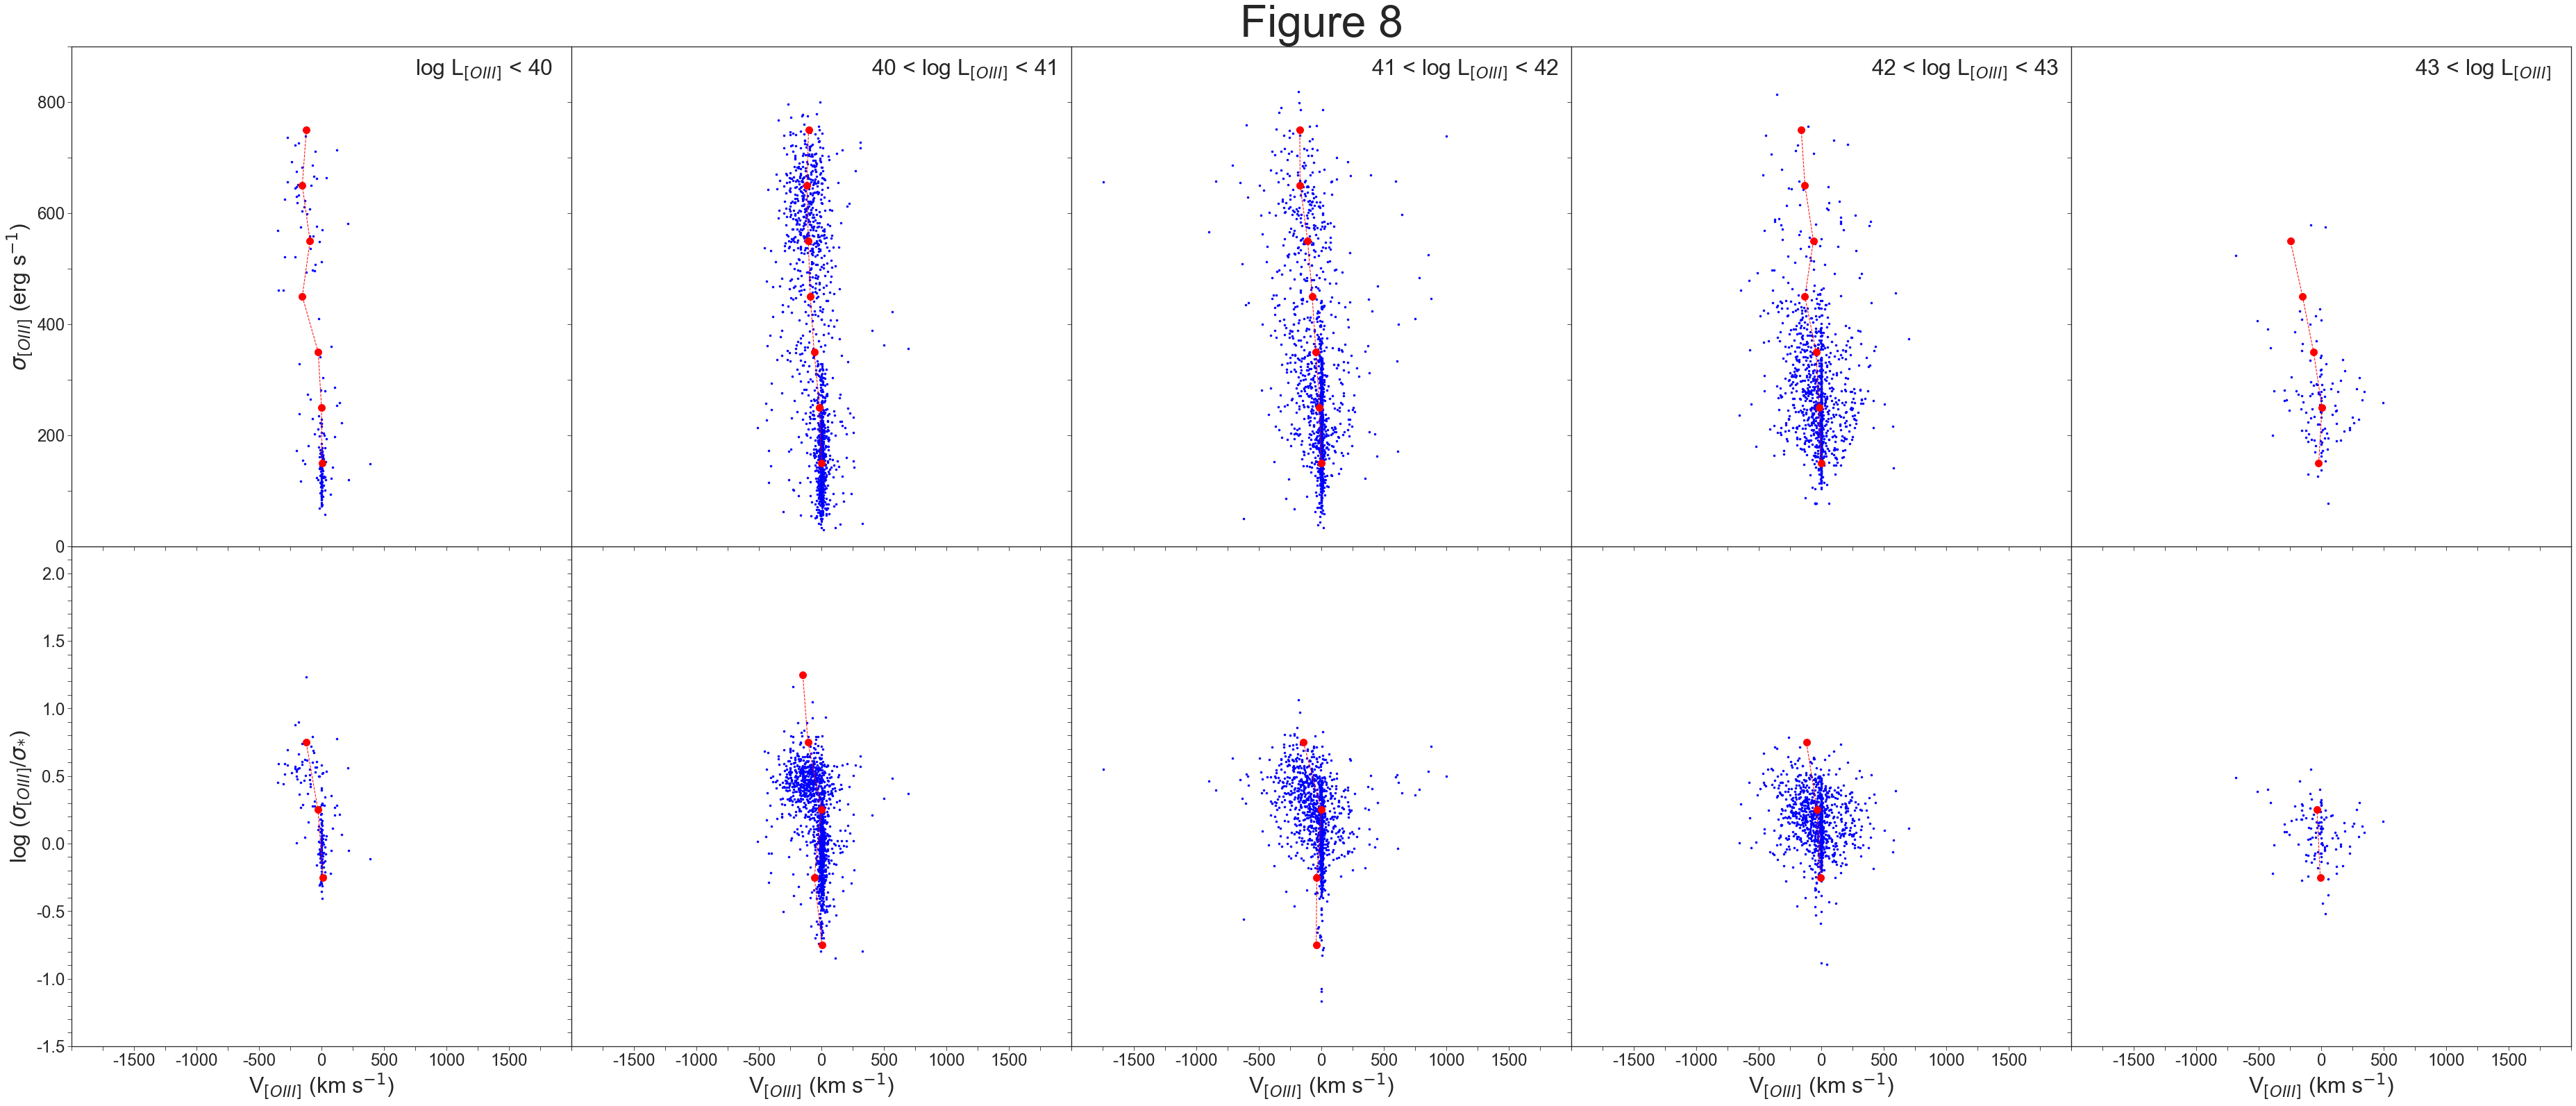

In [259]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1b = fig.add_axes([0, -1, 1, 1], ylim = (-1.5, 2.2), xlim = (-2000, 2000))
ax2b = fig.add_axes([1, -1, 1, 1], ylim = (-1.5, 2.2), xlim = (-2000, 2000))
ax3b = fig.add_axes([2, -1, 1, 1], ylim = (-1.5, 2.2), xlim = (-2000, 2000))
ax4b = fig.add_axes([3, -1, 1, 1], ylim = (-1.5, 2.2), xlim = (-2000, 2000))
ax5b = fig.add_axes([4, -1, 1, 1], ylim = (-1.5, 2.2), xlim = (-2000, 2000))

ax1a = fig.add_axes([0, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax2a = fig.add_axes([1, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax3a = fig.add_axes([2, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax4a = fig.add_axes([3, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax5a = fig.add_axes([4, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))

ax1a.plot(lumbin1_vel_shift, lumbin1_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1a.errorbar(lumbin1_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2a.plot(lumbin2_vel_shift, lumbin2_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2a.errorbar(lumbin2_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax3a.plot(lumbin3_vel_shift, lumbin3_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax3a.errorbar(lumbin3_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax4a.plot(lumbin4_vel_shift, lumbin4_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax4a.errorbar(lumbin4_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax5a.plot(lumbin5_vel_shift, lumbin5_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax5a.errorbar(lumbin5_mean_vel_shifta, fig8a_OIII_sigma_yaxis_1, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

##############################################################

ax1b.plot(lumbin1_vel_shift, lumbin1_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1b.errorbar(lumbin1_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_3, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2b.plot(lumbin2_vel_shift, lumbin2_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2b.errorbar(lumbin2_mean_vel_shiftb[0:5], fig8b_OIII_sigma_yaxis_1, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax3b.plot(lumbin3_vel_shift, lumbin3_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax3b.errorbar(lumbin3_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_2, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax4b.plot(lumbin4_vel_shift, lumbin4_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax4b.errorbar(lumbin4_mean_vel_shiftb[0:3], fig8b_OIII_sigma_yaxis_3, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax5b.plot(lumbin5_vel_shift, lumbin5_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax5b.errorbar(lumbin5_mean_vel_shiftb[0:2], fig8b_OIII_sigma_yaxis_4, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax1a.set_yticks(np.arange(0, 1000, 100))
ax2a.set_yticks(np.arange(0, 1000, 100))
ax3a.set_yticks(np.arange(0, 1000, 100))
ax4a.set_yticks(np.arange(0, 1000, 100))
ax5a.set_yticks(np.arange(0, 1000, 100))

ax1a.set_yticklabels([0, '', 200, '', 400, '', 600, '', 800, ''], fontsize = 24)
ax2a.set_yticklabels([])
ax3a.set_yticklabels([])
ax4a.set_yticklabels([])
ax5a.set_yticklabels([])

ax1a.set_xticks(np.arange(-2000, 2250, 250))
ax2a.set_xticks(np.arange(-2000, 2250, 250))
ax3a.set_xticks(np.arange(-2000, 2250, 250))
ax4a.set_xticks(np.arange(-2000, 2250, 250))
ax5a.set_xticks(np.arange(-2000, 2250, 250))

ax1a.set_xticklabels([])
ax2a.set_xticklabels([])
ax3a.set_xticklabels([])
ax4a.set_xticklabels([])
ax5a.set_xticklabels([])

ax1b.set_yticks(np.arange(-1.5, 2.3, 0.1))
ax2b.set_yticks(np.arange(-1.5, 2.3, 0.1))
ax3b.set_yticks(np.arange(-1.5, 2.3, 0.1))
ax4b.set_yticks(np.arange(-1.5, 2.3, 0.1))
ax5b.set_yticks(np.arange(-1.5, 2.3, 0.1))

ax1b.set_yticklabels([-1.5, '', '', '', '', -1.0, '', '', '', '', -0.5, '', '', '', '', 0.0, '', '', '', '', 0.5, '', '', '', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, '', ''], fontsize = 24)
ax2b.set_yticklabels([])
ax3b.set_yticklabels([])
ax4b.set_yticklabels([])
ax5b.set_yticklabels([])

ax1b.set_xticks(np.arange(-2000, 2250, 250))
ax2b.set_xticks(np.arange(-2000, 2250, 250))
ax3b.set_xticks(np.arange(-2000, 2250, 250))
ax4b.set_xticks(np.arange(-2000, 2250, 250))
ax5b.set_xticks(np.arange(-2000, 2250, 250))

ax1b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500, '', ''], fontsize = 24)
ax2b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500, '', ''], fontsize = 24)
ax3b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500, '', ''], fontsize = 24)
ax4b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500, '', ''], fontsize = 24)
ax5b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500, '', ''], fontsize = 24)

ax1a.text(750, 850, r'log L$_{[OIII]}$ < 40', fontsize = 32)
ax2a.text(400, 850, r'40 < log L$_{[OIII]}$ < 41', fontsize = 32)
ax3a.text(400, 850, r'41 < log L$_{[OIII]}$ < 42', fontsize = 32)
ax4a.text(400, 850, r'42 < log L$_{[OIII]}$ < 43', fontsize = 32)
ax5a.text(750, 850, r'43 < log L$_{[OIII]}$', fontsize = 32)

ax1a.set_ylabel(r'$\sigma$$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)

ax1b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax2b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax3b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax4b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax5b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

ax3a.set_title('Figure 8', fontsize = 64)

plt.show()

In [100]:
##############################################################
############################################################## END FIG 8
##############################################################

In [101]:
len(zbin1_data_v2) + len(zbin2_data_v2) + len(zbin3_data_v2) + len(zbin4_data_v2)

zbin1_HA_flux = zbin1_data_v2['FLUX'][:,24]
zbin2_HA_flux = zbin2_data_v2['FLUX'][:,24]
zbin3_HA_flux = zbin3_data_v2['FLUX'][:,24]
zbin4_HA_flux = zbin4_data_v2['FLUX'][:,24]

HA_flux = np.concatenate((zbin1_HA_flux, zbin2_HA_flux, zbin3_HA_flux, zbin4_HA_flux))

In [102]:
##################################################################################

zbin1_redshift  = zbin1_data_v2['Z']

zbin2_redshift  = zbin2_data_v2['Z']

zbin3_redshift  = zbin3_data_v2['Z']

zbin4_redshift  = zbin4_data_v2['Z']

redshift_4flux  = np.concatenate((zbin1_redshift, zbin2_redshift, zbin3_redshift, zbin4_redshift))



In [103]:
sg_HA_flux = HA_flux[select_sg_fig7]
dg_HA_flux = HA_flux[select_dg_fig7]

sg_redshift = redshift_4flux[select_sg_fig7]
dg_redshift = redshift_4flux[select_dg_fig7]

In [104]:
##################################################################################

sg_lum_dis = cosmo.luminosity_distance(sg_redshift)
sg_lum_dis = sg_lum_dis.to(u.cm)
sg_HA_flux_correct_units = sg_HA_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
sg_HA_lum = 4 * np.pi * sg_HA_flux_correct_units * (sg_lum_dis ** 2)

##################################################################################

dg_lum_dis = cosmo.luminosity_distance(dg_redshift)
dg_lum_dis =dg_lum_dis.to(u.cm)
dg_HA_flux_correct_units = dg_HA_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
dg_HA_lum = 4 * np.pi * dg_HA_flux_correct_units * (dg_lum_dis ** 2)

##################################################################################

sg_HA_lum = np.array(sg_HA_lum)
dg_HA_lum = np.array(dg_HA_lum)

##################################################################################

sg_HA_lum_array = np.log10(sg_HA_lum)
dg_HA_lum_array = np.log10(dg_HA_lum)

##################################################################################

In [105]:
array_summary(sg_HA_lum_array)
print('')
array_summary(dg_HA_lum_array)

             Count:   3160
              Mean:   41.16298549198127
            Median:   41.16793361212606
Standard Deviation:   0.6604584400021405
           Minimum:   34.26879075264818
           Maximum:   43.03952632723645

             Count:   1357
              Mean:   41.75483710170537
            Median:   41.83793474657871
Standard Deviation:   0.6092909100689338
           Minimum:   39.53755524816609
           Maximum:   43.65933375331096


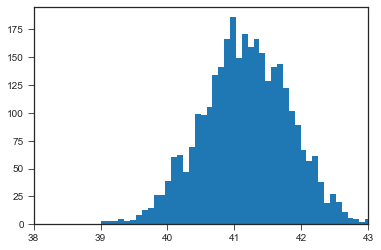

In [106]:
plt.hist(sg_HA_lum_array, bins = 100)
plt.xlim(38,43)
plt.show()

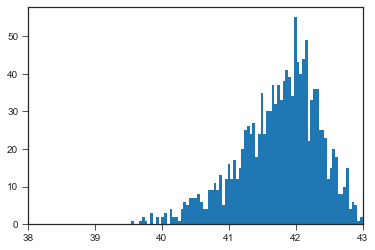

In [107]:
plt.hist(dg_HA_lum_array, bins = 100)
plt.xlim(38,43)
plt.show()

In [108]:
#now we are going to replace sigma OIII with wing velocity

In [109]:
zbin1_wingveldis = zbin1_results_v2['WING_VELDIS'][(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)]
zbin2_wingveldis = zbin2_results_v2['WING_VELDIS'][(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)]
zbin3_wingveldis = zbin3_results_v2['WING_VELDIS'][(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)]
zbin4_wingveldis = zbin4_results_v2['WING_VELDIS'][(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)]

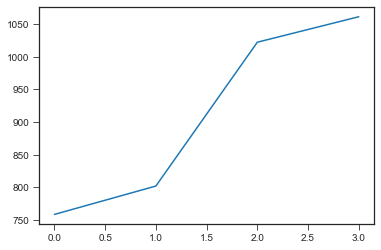

In [110]:
plt.plot([0,1,2,3], [np.mean(zbin1_wingveldis), np.mean(zbin2_wingveldis), np.mean(zbin3_wingveldis), np.mean(zbin4_wingveldis)])

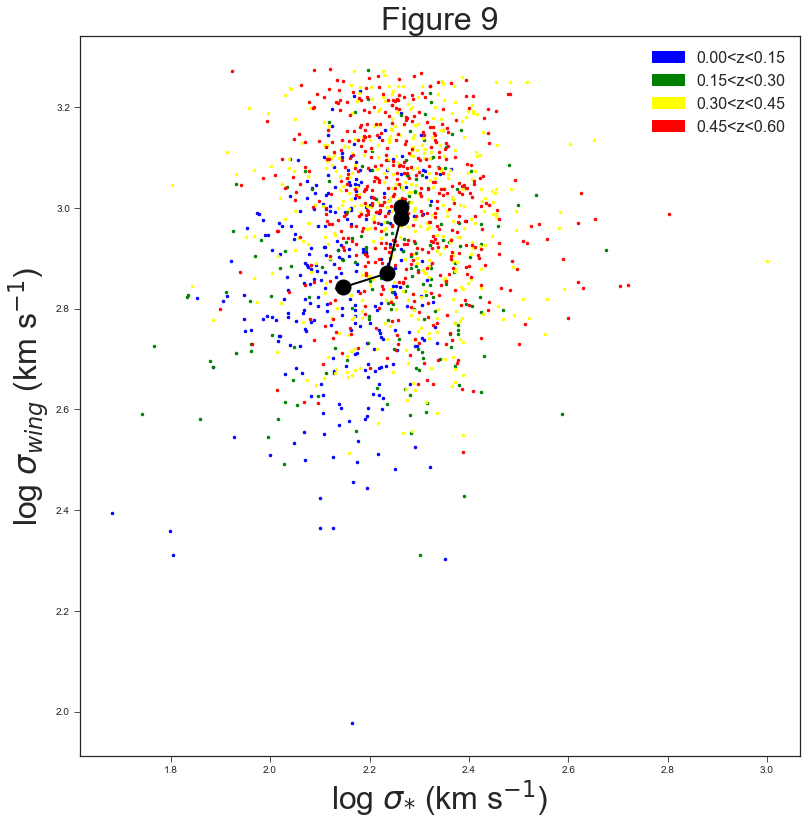

In [111]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1] )

ax1.plot(zbin1_log_sigma_stars[(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)], np.log10(zbin1_wingveldis), color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_log_sigma_stars[(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)], np.log10(zbin2_wingveldis), color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_log_sigma_stars[(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)], np.log10(zbin3_wingveldis), color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_log_sigma_stars[(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)], np.log10(zbin4_wingveldis), color = 'red',    linestyle = '', marker = '.', ms = 5)

ax1.errorbar(np.array([np.mean(zbin1_log_sigma_stars[(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)]),
                       np.mean(zbin2_log_sigma_stars[(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)]),
                       np.mean(zbin3_log_sigma_stars[(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)]),
                       np.mean(zbin4_log_sigma_stars[(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)])]),
             np.array([np.mean(np.log10(zbin1_wingveldis)), np.mean(np.log10(zbin2_wingveldis)),
                       np.mean(np.log10(zbin3_wingveldis)), np.mean(np.log10(zbin4_wingveldis))
                 
             ]), color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

# ax1.set_yticks(np.arange(1.4, 3.3, 0.1))
# ax1.set_yticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

# ax1.set_xticks(np.arange(0.8, 3.3, 0.1))
# ax1.set_xticklabels(['', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_ylabel(r'log $\sigma$$_{wing}$ (km s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{*}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

plt.title('Figure 9', fontsize = 32)

plt.show()

In [112]:
OIIIwingveldis = np.concatenate((zbin1_wingveldis, zbin2_wingveldis, zbin3_wingveldis, zbin4_wingveldis))

log_OIIIwingveldis = np.log10(OIIIwingveldis)


fig10_OIII_lum = np.concatenate((zbin1_OIII_log_lum_array[(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)],
                                 zbin2_OIII_log_lum_array[(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)],
                                 zbin3_OIII_log_lum_array[(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)], 
                                 zbin4_OIII_log_lum_array[(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)]))

fig10_select_lumbin1 = ( fig10_OIII_lum < 40 )
fig10_select_lumbin2 = ( fig10_OIII_lum > 40 ) & ( fig10_OIII_lum < 41 )
fig10_select_lumbin3 = ( fig10_OIII_lum > 41 ) & ( fig10_OIII_lum < 42 )
fig10_select_lumbin4 = ( fig10_OIII_lum > 42 ) & ( fig10_OIII_lum < 43 )
fig10_select_lumbin5 = ( fig10_OIII_lum > 43 )


lumbin1_OIIIwingveldis = log_OIIIwingveldis[fig10_select_lumbin1]
lumbin2_OIIIwingveldis = log_OIIIwingveldis[fig10_select_lumbin2]
lumbin3_OIIIwingveldis = log_OIIIwingveldis[fig10_select_lumbin3]
lumbin4_OIIIwingveldis = log_OIIIwingveldis[fig10_select_lumbin4]
lumbin5_OIIIwingveldis = log_OIIIwingveldis[fig10_select_lumbin5]

fig10_mean_log_OIIIwingveldis = np.array([np.mean(lumbin1_OIIIwingveldis), np.mean(lumbin2_OIIIwingveldis),
                                          np.mean(lumbin3_OIIIwingveldis), np.mean(lumbin4_OIIIwingveldis),
                                          np.mean(lumbin5_OIIIwingveldis)])

fig10_stellar_sigma = np.concatenate((zbin1_data_v2['SIGMA_STARS'][(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)],
                                      zbin2_data_v2['SIGMA_STARS'][(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)],
                                      zbin3_data_v2['SIGMA_STARS'][(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)], 
                                      zbin4_data_v2['SIGMA_STARS'][(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)]))



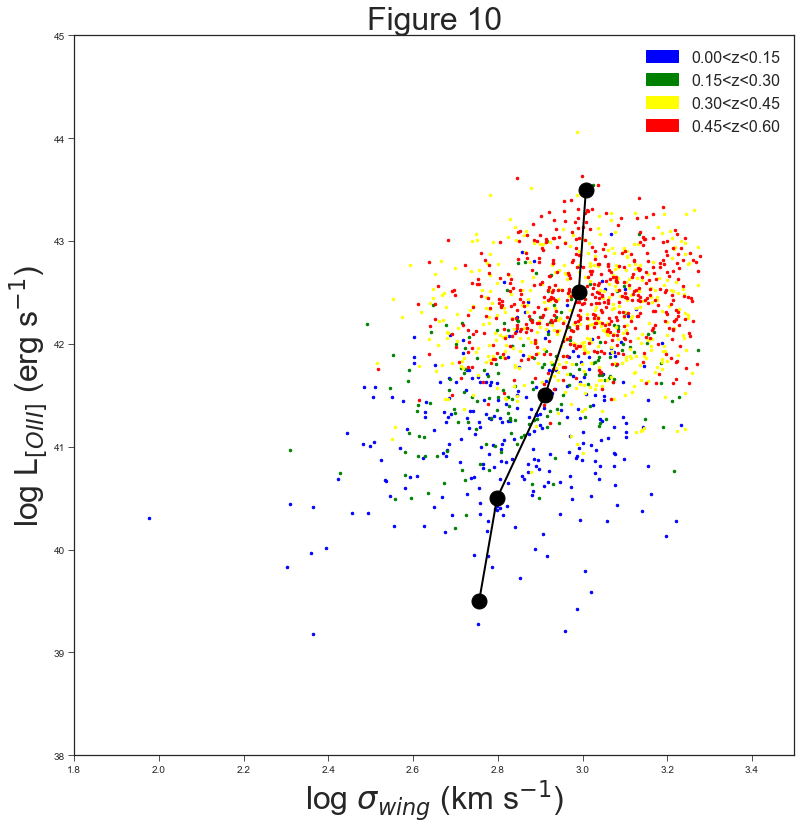

In [113]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1],     xlim = ( 1.8, 3.5), ylim = (38, 45) )

ax1.plot(np.log10(zbin1_wingveldis), zbin1_OIII_log_lum_array[(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)], color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(np.log10(zbin2_wingveldis), zbin2_OIII_log_lum_array[(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)], color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(np.log10(zbin3_wingveldis), zbin3_OIII_log_lum_array[(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)], color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(np.log10(zbin4_wingveldis), zbin4_OIII_log_lum_array[(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)], color = 'red',    linestyle = '', marker = '.', ms = 5)
ax1.errorbar(fig10_mean_log_OIIIwingveldis, log_lum_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

# ax1.set_xticks(np.arange(1.4, 3.3, 0.1))
# ax1.set_xticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

# ax1.set_yticks(np.arange(38, 45.5, 0.5))
# ax1.set_yticklabels([38, '', 39, '', 40, '', 41, '', 42, '', 43, '', 44, '', 45], fontsize = 16)

ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{wing}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.set_title('Figure 10', fontsize = 32)

#################################################

# ax2.plot(zbin1_log_sigma_ratio, zbin1_log_edd_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
# ax2.plot(zbin2_log_sigma_ratio, zbin2_log_edd_ratio, color = 'green',  linestyle = '', marker = '.', ms = 5)
# ax2.plot(zbin3_log_sigma_ratio, zbin3_log_edd_ratio, color = 'yellow', linestyle = '', marker = '.', ms = 5)
# ax2.plot(zbin4_log_sigma_ratio, zbin4_log_edd_ratio, color = 'red',    linestyle = '', marker = '.', ms = 5)
# ax2.errorbar(mean_log_sigma_ratio_fig5, log_edd_ratio_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

# ax2.set_xticks(np.arange(-1.5, 2.2, 0.1))
# ax2.set_xticklabels([-1.5, '', '', '', '', -1.0, '', '', '', '', -0.5, '', '', '', '', 0.0, '', '', '', '', 0.5, '', '', '', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, ''], fontsize = 16)

# ax2.set_yticks(np.arange(-5, 8.5, 0.5))
# ax2.set_yticklabels([-5, '', -4, '', -3, '', -2, '', -1, '', 0, '', 1, '', 2, '', 3, '', 4, '', 5, '', 6, '', 7, '', 8], fontsize = 16)

# ax2.set_xlabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)
# ax2.set_ylabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

# plt.show()

plt.show()

In [114]:
fig11_flags = np.concatenate((zbin1_results_v2['FLAG'], zbin2_results_v2['FLAG'],
                              zbin3_results_v2['FLAG'], zbin4_results_v2['FLAG']))

lumbin1_flag = fig11_flags[select_lumbin1]
lumbin2_flag = fig11_flags[select_lumbin2]
lumbin3_flag = fig11_flags[select_lumbin3]
lumbin4_flag = fig11_flags[select_lumbin4]
lumbin5_flag = fig11_flags[select_lumbin5]

lumbin1_outflow_frac = len(lumbin1_flag[(lumbin1_flag == 2) | (lumbin1_flag == 3)]) / len(lumbin1_flag)
lumbin2_outflow_frac = len(lumbin2_flag[(lumbin2_flag == 2) | (lumbin2_flag == 3)]) / len(lumbin2_flag)
lumbin3_outflow_frac = len(lumbin3_flag[(lumbin3_flag == 2) | (lumbin3_flag == 3)]) / len(lumbin3_flag)
lumbin4_outflow_frac = len(lumbin4_flag[(lumbin4_flag == 2) | (lumbin4_flag == 3)]) / len(lumbin4_flag)
lumbin5_outflow_frac = len(lumbin5_flag[(lumbin5_flag == 2) | (lumbin5_flag == 3)]) / len(lumbin5_flag)

fig11_lum_outflow_frac = np.array([lumbin1_outflow_frac,
                                   lumbin2_outflow_frac, 
                                   lumbin3_outflow_frac, 
                                   lumbin4_outflow_frac, 
                                   lumbin5_outflow_frac])

eddbin1_flag = fig11_flags[select_eddbin1]
eddbin2_flag = fig11_flags[select_eddbin2]
eddbin3_flag = fig11_flags[select_eddbin3]
eddbin4_flag = fig11_flags[select_eddbin4]
eddbin5_flag = fig11_flags[select_eddbin5]
eddbin6_flag = fig11_flags[select_eddbin6]

eddbin2_flag = np.concatenate((eddbin1_flag, eddbin2_flag))

# eddbin1_outflow_frac = len(eddbin1_flag[(eddbin1_flag == 2) | (eddbin1_flag == 3)]) / len(eddbin1_flag)
eddbin2_outflow_frac = len(eddbin2_flag[(eddbin2_flag == 2) | (eddbin2_flag == 3)]) / len(eddbin2_flag)
eddbin3_outflow_frac = len(eddbin3_flag[(eddbin3_flag == 2) | (eddbin3_flag == 3)]) / len(eddbin3_flag)
eddbin4_outflow_frac = len(eddbin4_flag[(eddbin4_flag == 2) | (eddbin4_flag == 3)]) / len(eddbin4_flag)
eddbin5_outflow_frac = len(eddbin5_flag[(eddbin5_flag == 2) | (eddbin5_flag == 3)]) / len(eddbin5_flag)
eddbin6_outflow_frac = len(eddbin6_flag[(eddbin6_flag == 2) | (eddbin6_flag == 3)]) / len(eddbin6_flag)

fig11_edd_outflow_frac = np.array([eddbin2_outflow_frac, 
                                   eddbin3_outflow_frac, 
                                   eddbin4_outflow_frac, 
                                   eddbin5_outflow_frac,
                                   eddbin6_outflow_frac])




In [115]:
def flag_spec(fit_parameters, wave, fluxden):
    
    ###############################
    ###############################
    
    #0 bad data, 1 no outflow, 2 blu wing, 3 red wing, 4 broad comp, no outflow
    
    ###############################
    ###############################
    
    FLAG = 0
    
    ###############################
    ###############################
    
    components = wing_check(fit_parameters[0])
    
    
    C = components[0]
    W = components[1]
    
    if C[1] > W[1]:
        FLAG = 2
    elif C[1] < W[1]:
        FLAG = 3
        
    ###############################
    ###############################
        
    if fit_parameters[0][0] == 0: #second gaussian gives zero thus single
        FLAG = 1

    if fit_parameters[0][3] == 0: #second gaussian gives zero thus single
        FLAG = 1

    if fit_parameters[0][2] > 1900: #second gaussian un realistically wide thus single
        FLAG = 1

    if fit_parameters[0][5] > 1900: #second gaussian un realistically wide thus single
        FLAG = 1

    if fit_parameters[0][2] < 0: #negative width?? essentially flat
        FLAG = 1

    if fit_parameters[0][5] < 0: #negative width?? essentially flat
        FLAG = 1

    if fit_parameters[0][1] < min(to_vel_OIII(wave)): #fits second gauss elsewhere for somereason??
        FLAG = 1

    if fit_parameters[0][4] < min(to_vel_OIII(wave)): #fits second gauss elsewhere for somereason??
        FLAG = 1

    if fit_parameters[0][1] > max(to_vel_OIII(wave)): #fits second gauss elsewhere for somereason??
        FLAG = 1

    if fit_parameters[0][4] > max(to_vel_OIII(wave)): #fits second gauss elsewhere for somereason??
        FLAG = 1
        
    if fit_parameters[0][2] < -1900: #second gaussian un realistically wide thus single
        FLAG = 1

    if fit_parameters[0][5] < -1900: #second gaussian un realistically wide thus single
        FLAG = 1
        
    if fit_parameters[0][0] < 0: #negative amp bad data
        FLAG = 0
        
        print('uh')

    if fit_parameters[0][3] < 0: #negative amp bad data
        FLAG = 0
        
        print('uh')
        
    return FLAG


In [116]:
zbin1_flags = np.zeros((len(trimmed_specs_zbin1), 100))
count = 0
for key in trimmed_specs_zbin1:
    wave = trimmed_specs_zbin1[key][0]
    fluxden = trimmed_specs_zbin1[key][0]
    
    parameters     = zbin1_dict[key][0]
    parameters_err = zbin1_dict[key][2]
    
    for i in range(100):
        iter_params1 = np.random.normal(parameters, parameters_err)
        
        while ( iter_params1[0] < 0 ) or ( iter_params1[1] < 0 ) or ( iter_params1[2] < 0 ) or ( iter_params1[3] < 0 ) or ( iter_params1[4] < 0 ) or ( iter_params1[5] < 0 ):
                iter_params1 = np.random.normal(parameters, parameters_err)
        
        iter_params2 = np.zeros(8)
        iter_params2[0:6] = iter_params1
        
        iter_params2 = np.array([iter_params2])
        
#         print(iter_params2[0])
        
        flag = flag_spec(iter_params2, wave, fluxden)
        
        zbin1_flags[count, i] = flag
    count+=1

    
zbin2_flags = np.zeros((len(trimmed_specs_zbin2), 100))
count = 0
for key in trimmed_specs_zbin2:
    wave = trimmed_specs_zbin2[key][0]
    fluxden = trimmed_specs_zbin2[key][0]
    
    parameters     = zbin2_dict[key][0]
    parameters_err = zbin2_dict[key][2]
    
    for i in range(100):
        iter_params1 = np.random.normal(parameters, parameters_err)
        
        while ( iter_params1[0] < 0 ) or ( iter_params1[1] < 0 ) or ( iter_params1[2] < 0 ) or ( iter_params1[3] < 0 ) or ( iter_params1[4] < 0 ) or ( iter_params1[5] < 0 ):
                iter_params1 = np.random.normal(parameters, parameters_err)
        
        iter_params2 = np.zeros(8)
        iter_params2[0:6] = iter_params1
        
        iter_params2 = np.array([iter_params2])
        
#         print(iter_params2[0])
        
        flag = flag_spec(iter_params2, wave, fluxden)
        
        zbin2_flags[count, i] = flag
    count+=1
    

zbin3_flags = np.zeros((len(trimmed_specs_zbin3), 100))
count = 0
for key in trimmed_specs_zbin3:
    wave = trimmed_specs_zbin3[key][0]
    fluxden = trimmed_specs_zbin3[key][0]
    
    parameters     = zbin3_dict[key][0]
    parameters_err = zbin3_dict[key][2]
    
    for i in range(100):
        iter_params1 = np.random.normal(parameters, parameters_err)
        
        while ( iter_params1[0] < 0 ) or ( iter_params1[1] < 0 ) or ( iter_params1[2] < 0 ) or ( iter_params1[3] < 0 ) or ( iter_params1[4] < 0 ) or ( iter_params1[5] < 0 ):
                iter_params1 = np.random.normal(parameters, parameters_err)
        
        iter_params2 = np.zeros(8)
        iter_params2[0:6] = iter_params1
        
        iter_params2 = np.array([iter_params2])
        
#         print(iter_params2[0])
        
        flag = flag_spec(iter_params2, wave, fluxden)
        
        zbin3_flags[count, i] = flag
    count+=1
    

zbin4_flags = np.zeros((len(trimmed_specs_zbin4), 100))
count = 0
for key in trimmed_specs_zbin4:
    wave = trimmed_specs_zbin4[key][0]
    fluxden = trimmed_specs_zbin4[key][0]
    
    parameters     = zbin4_dict[key][0]
    parameters_err = zbin4_dict[key][2]
    
    for i in range(100):
        iter_params1 = np.random.normal(parameters, parameters_err)
        
        while ( iter_params1[0] < 0 ) or ( iter_params1[1] < 0 ) or ( iter_params1[2] < 0 ) or ( iter_params1[3] < 0 ) or ( iter_params1[4] < 0 ) or ( iter_params1[5] < 0 ):
                iter_params1 = np.random.normal(parameters, parameters_err)
        
        iter_params2 = np.zeros(8)
        iter_params2[0:6] = iter_params1
        
        iter_params2 = np.array([iter_params2])
        
#         print(iter_params2[0])
        
        flag = flag_spec(iter_params2, wave, fluxden)
        
        zbin4_flags[count, i] = flag
    count+=1    

In [117]:
fig11_lum_outflow_frac_table = np.zeros((100, 5))
fig11_edd_outflow_frac_table = np.zeros((100, 5))


for i in range(100):
    iter_flags = np.concatenate((zbin1_flags[:, i][select_good_zbin1][select_zbin1_edd_cut],
                                 zbin2_flags[:, i][select_good_zbin2][select_zbin2_edd_cut],
                                 zbin3_flags[:, i][select_good_zbin3][select_zbin3_edd_cut],
                                 zbin4_flags[:, i][select_good_zbin4][select_zbin4_edd_cut]
    ))
    
    lumbin1_flag = iter_flags[select_lumbin1]
    lumbin2_flag = iter_flags[select_lumbin2]
    lumbin3_flag = iter_flags[select_lumbin3]
    lumbin4_flag = iter_flags[select_lumbin4]
    lumbin5_flag = iter_flags[select_lumbin5]

    lumbin1_outflow_frac = len(lumbin1_flag[(lumbin1_flag == 2) | (lumbin1_flag == 3)]) / len(lumbin1_flag)
    lumbin2_outflow_frac = len(lumbin2_flag[(lumbin2_flag == 2) | (lumbin2_flag == 3)]) / len(lumbin2_flag)
    lumbin3_outflow_frac = len(lumbin3_flag[(lumbin3_flag == 2) | (lumbin3_flag == 3)]) / len(lumbin3_flag)
    lumbin4_outflow_frac = len(lumbin4_flag[(lumbin4_flag == 2) | (lumbin4_flag == 3)]) / len(lumbin4_flag)
    lumbin5_outflow_frac = len(lumbin5_flag[(lumbin5_flag == 2) | (lumbin5_flag == 3)]) / len(lumbin5_flag)

    fig11_lum_outflow_frac_temp = np.array([lumbin1_outflow_frac,
                                            lumbin2_outflow_frac, 
                                            lumbin3_outflow_frac, 
                                            lumbin4_outflow_frac, 
                                            lumbin5_outflow_frac])

    eddbin1_flag = iter_flags[select_eddbin1]
    eddbin2_flag = iter_flags[select_eddbin2]
    eddbin3_flag = iter_flags[select_eddbin3]
    eddbin4_flag = iter_flags[select_eddbin4]
    eddbin5_flag = iter_flags[select_eddbin5]
    eddbin6_flag = iter_flags[select_eddbin6]

    eddbin2_flag = np.concatenate((eddbin1_flag, eddbin2_flag))

    # eddbin1_outflow_frac = len(eddbin1_flag[(eddbin1_flag == 2) | (eddbin1_flag == 3)]) / len(eddbin1_flag)
    eddbin2_outflow_frac = len(eddbin2_flag[(eddbin2_flag == 2) | (eddbin2_flag == 3)]) / len(eddbin2_flag)
    eddbin3_outflow_frac = len(eddbin3_flag[(eddbin3_flag == 2) | (eddbin3_flag == 3)]) / len(eddbin3_flag)
    eddbin4_outflow_frac = len(eddbin4_flag[(eddbin4_flag == 2) | (eddbin4_flag == 3)]) / len(eddbin4_flag)
    eddbin5_outflow_frac = len(eddbin5_flag[(eddbin5_flag == 2) | (eddbin5_flag == 3)]) / len(eddbin5_flag)
    eddbin6_outflow_frac = len(eddbin6_flag[(eddbin6_flag == 2) | (eddbin6_flag == 3)]) / len(eddbin6_flag)

    fig11_edd_outflow_frac_temp = np.array([eddbin2_outflow_frac, 
                                            eddbin3_outflow_frac, 
                                            eddbin4_outflow_frac, 
                                            eddbin5_outflow_frac,
                                            eddbin6_outflow_frac])
    
    fig11_lum_outflow_frac_table[i] = fig11_lum_outflow_frac_temp
    fig11_edd_outflow_frac_table[i] = fig11_edd_outflow_frac_temp
    
fig11_lum_outflow_frac = np.array([np.mean(fig11_lum_outflow_frac_table[:,0]),
                                   np.mean(fig11_lum_outflow_frac_table[:,1]),
                                   np.mean(fig11_lum_outflow_frac_table[:,2]),
                                   np.mean(fig11_lum_outflow_frac_table[:,3]),
                                   np.mean(fig11_lum_outflow_frac_table[:,4])
                                  ])

fig11_lum_outflow_frac_err = np.array([np.std(fig11_lum_outflow_frac_table[:,0]),
                                       np.std(fig11_lum_outflow_frac_table[:,1]),
                                       np.std(fig11_lum_outflow_frac_table[:,2]),
                                       np.std(fig11_lum_outflow_frac_table[:,3]),
                                       np.std(fig11_lum_outflow_frac_table[:,4])
                                      ])

fig11_edd_outflow_frac = np.array([np.mean(fig11_edd_outflow_frac_table[:,0]),
                                   np.mean(fig11_edd_outflow_frac_table[:,1]),
                                   np.mean(fig11_edd_outflow_frac_table[:,2]),
                                   np.mean(fig11_edd_outflow_frac_table[:,3]),
                                   np.mean(fig11_edd_outflow_frac_table[:,4])
                                  ])

fig11_edd_outflow_frac_err = np.array([np.std(fig11_edd_outflow_frac_table[:,0]),
                                       np.std(fig11_edd_outflow_frac_table[:,1]),
                                       np.std(fig11_edd_outflow_frac_table[:,2]),
                                       np.std(fig11_edd_outflow_frac_table[:,3]),
                                       np.std(fig11_edd_outflow_frac_table[:,4])
                                      ])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


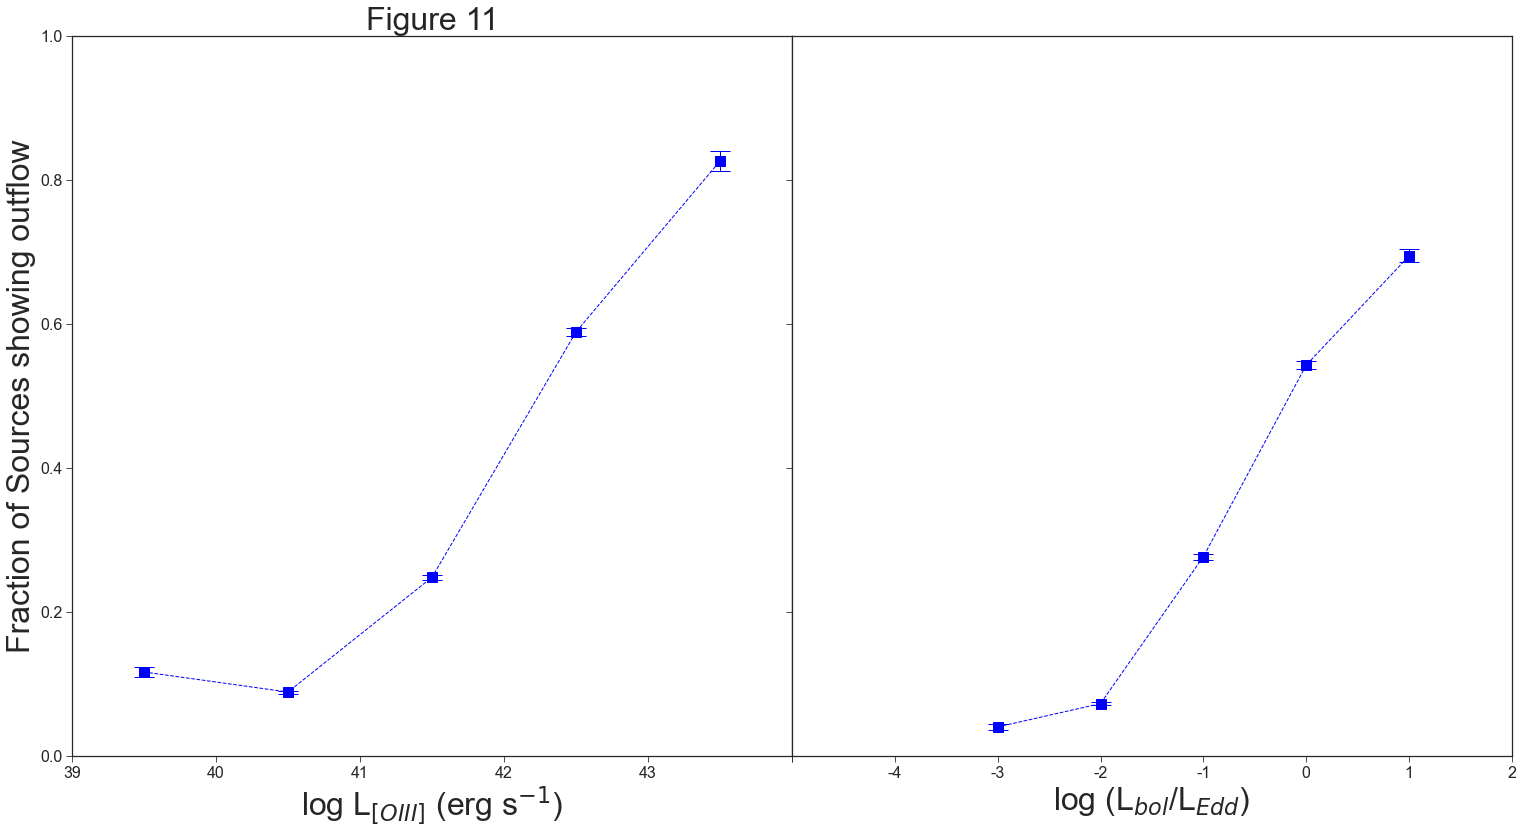

In [118]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2 = fig.add_axes([1, 0, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )

ax1.set_title('Figure 11', fontsize = 32)
ax1.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig11_lum_outflow_frac, fig11_lum_outflow_frac_err, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax1.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_ylabel('Fraction of Sources showing outflow', fontsize = 32)

ax1.set_xticklabels([39,40,41,42, 43], fontsize = 16)
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 16)

ax2.errorbar(np.array([-3,-2,-1,0,1]), fig11_edd_outflow_frac, fig11_edd_outflow_frac_err, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2.set_yticklabels([], fontsize = 16)
ax2.set_xticklabels(['',-4,-3, -2, -1, 0, 1, 2], fontsize = 16)
ax2.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [119]:
############################START FIGURE 12 (10 in woo)


In [120]:
zbin1_sigma_OIII_err = OIII_sigma_err_array_zbin1[select_good_zbin1][select_zbin1_edd_cut]
zbin2_sigma_OIII_err = OIII_sigma_err_array_zbin2[select_good_zbin2][select_zbin2_edd_cut]
zbin3_sigma_OIII_err = OIII_sigma_err_array_zbin3[select_good_zbin3][select_zbin3_edd_cut]
zbin4_sigma_OIII_err = OIII_sigma_err_array_zbin4[select_good_zbin4][select_zbin4_edd_cut]

fig12_sigmaOIII_err = np.concatenate((zbin1_sigma_OIII_err,
                                      zbin2_sigma_OIII_err,
                                      zbin3_sigma_OIII_err,
                                      zbin4_sigma_OIII_err
))

fig12_sigmaOIII = np.concatenate((zbin1_log_OIII_sigma,
                                  zbin2_log_OIII_sigma,
                                  zbin3_log_OIII_sigma,
                                  zbin4_log_OIII_sigma))

fig12_sigmaOIII = 10 ** fig12_sigmaOIII

lumbin1_sigmaOIII_frac1_total = []
lumbin2_sigmaOIII_frac1_total = []
lumbin3_sigmaOIII_frac1_total = []
lumbin4_sigmaOIII_frac1_total = []
lumbin5_sigmaOIII_frac1_total = []

lumbin1_sigmaOIII_frac2_total = []
lumbin2_sigmaOIII_frac2_total = []
lumbin3_sigmaOIII_frac2_total = []
lumbin4_sigmaOIII_frac2_total = []
lumbin5_sigmaOIII_frac2_total = []

eddbin2_sigmaOIII_frac1_total = []
eddbin3_sigmaOIII_frac1_total = []
eddbin4_sigmaOIII_frac1_total = []
eddbin5_sigmaOIII_frac1_total = []
eddbin6_sigmaOIII_frac1_total = []

eddbin2_sigmaOIII_frac2_total = []
eddbin3_sigmaOIII_frac2_total = []
eddbin4_sigmaOIII_frac2_total = []
eddbin5_sigmaOIII_frac2_total = []
eddbin6_sigmaOIII_frac2_total = []


for _ in range(100):
    
    fig12_sigmaOIII_iter = np.random.normal(fig12_sigmaOIII, fig12_sigmaOIII_err)
    
    fig12_sigmaOIII_iter = np.log10(fig12_sigmaOIII_iter)

    lumbin1_sigmaOIII = fig12_sigmaOIII_iter[select_lumbin1]
    lumbin2_sigmaOIII = fig12_sigmaOIII_iter[select_lumbin2]
    lumbin3_sigmaOIII = fig12_sigmaOIII_iter[select_lumbin3]
    lumbin4_sigmaOIII = fig12_sigmaOIII_iter[select_lumbin4]
    lumbin5_sigmaOIII = fig12_sigmaOIII_iter[select_lumbin5]

    lumbin1_sigmaOIII_frac1 = len(lumbin1_sigmaOIII[lumbin1_sigmaOIII >= 2.30103]) / len(lumbin1_sigmaOIII)
    lumbin2_sigmaOIII_frac1 = len(lumbin2_sigmaOIII[lumbin2_sigmaOIII >= 2.30103]) / len(lumbin2_sigmaOIII)
    lumbin3_sigmaOIII_frac1 = len(lumbin3_sigmaOIII[lumbin3_sigmaOIII >= 2.30103]) / len(lumbin3_sigmaOIII)
    lumbin4_sigmaOIII_frac1 = len(lumbin4_sigmaOIII[lumbin4_sigmaOIII >= 2.30103]) / len(lumbin4_sigmaOIII)
    lumbin5_sigmaOIII_frac1 = len(lumbin5_sigmaOIII[lumbin5_sigmaOIII >= 2.30103]) / len(lumbin5_sigmaOIII)


    lumbin1_sigmaOIII_frac2 = len(lumbin1_sigmaOIII[lumbin1_sigmaOIII >= 2.47712]) / len(lumbin1_sigmaOIII)
    lumbin2_sigmaOIII_frac2 = len(lumbin2_sigmaOIII[lumbin2_sigmaOIII >= 2.47712]) / len(lumbin2_sigmaOIII)
    lumbin3_sigmaOIII_frac2 = len(lumbin3_sigmaOIII[lumbin3_sigmaOIII >= 2.47712]) / len(lumbin3_sigmaOIII)
    lumbin4_sigmaOIII_frac2 = len(lumbin4_sigmaOIII[lumbin4_sigmaOIII >= 2.47712]) / len(lumbin4_sigmaOIII)
    lumbin5_sigmaOIII_frac2 = len(lumbin5_sigmaOIII[lumbin5_sigmaOIII >= 2.47712]) / len(lumbin5_sigmaOIII)



    eddbin1_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin1]
    eddbin2_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin2]
    eddbin3_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin3]
    eddbin4_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin4]
    eddbin5_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin5]
    eddbin6_sigmaOIII = fig12_sigmaOIII_iter[select_eddbin6]

    eddbin2_sigmaOIII = np.concatenate((eddbin1_sigmaOIII, eddbin2_sigmaOIII))

    # eddbin1_sigmaOIII_frac1 = len(eddbin1_sigmaOIII[eddbin1_sigmaOIII >= 2.30103]) / len(eddbin1_sigmaOIII)
    eddbin2_sigmaOIII_frac1 = len(eddbin2_sigmaOIII[eddbin2_sigmaOIII >= 2.30103]) / len(eddbin2_sigmaOIII)
    eddbin3_sigmaOIII_frac1 = len(eddbin3_sigmaOIII[eddbin3_sigmaOIII >= 2.30103]) / len(eddbin3_sigmaOIII)
    eddbin4_sigmaOIII_frac1 = len(eddbin4_sigmaOIII[eddbin4_sigmaOIII >= 2.30103]) / len(eddbin4_sigmaOIII)
    eddbin5_sigmaOIII_frac1 = len(eddbin5_sigmaOIII[eddbin5_sigmaOIII >= 2.30103]) / len(eddbin5_sigmaOIII)
    eddbin6_sigmaOIII_frac1 = len(eddbin6_sigmaOIII[eddbin6_sigmaOIII >= 2.30103]) / len(eddbin6_sigmaOIII)


    # eddbin1_sigmaOIII_frac2 = len(eddbin1_sigmaOIII[eddbin1_sigmaOIII >= 2.47712]) / len(eddbin1_sigmaOIII)
    eddbin2_sigmaOIII_frac2 = len(eddbin2_sigmaOIII[eddbin2_sigmaOIII >= 2.47712]) / len(eddbin2_sigmaOIII)
    eddbin3_sigmaOIII_frac2 = len(eddbin3_sigmaOIII[eddbin3_sigmaOIII >= 2.47712]) / len(eddbin3_sigmaOIII)
    eddbin4_sigmaOIII_frac2 = len(eddbin4_sigmaOIII[eddbin4_sigmaOIII >= 2.47712]) / len(eddbin4_sigmaOIII)
    eddbin5_sigmaOIII_frac2 = len(eddbin5_sigmaOIII[eddbin5_sigmaOIII >= 2.47712]) / len(eddbin5_sigmaOIII)
    eddbin6_sigmaOIII_frac2 = len(eddbin6_sigmaOIII[eddbin6_sigmaOIII >= 2.47712]) / len(eddbin6_sigmaOIII)


    
    lumbin1_sigmaOIII_frac1_total.append(lumbin1_sigmaOIII_frac1)
    lumbin2_sigmaOIII_frac1_total.append(lumbin2_sigmaOIII_frac1)
    lumbin3_sigmaOIII_frac1_total.append(lumbin3_sigmaOIII_frac1)
    lumbin4_sigmaOIII_frac1_total.append(lumbin4_sigmaOIII_frac1)
    lumbin5_sigmaOIII_frac1_total.append(lumbin5_sigmaOIII_frac1)
    
    lumbin1_sigmaOIII_frac2_total.append(lumbin1_sigmaOIII_frac2)
    lumbin2_sigmaOIII_frac2_total.append(lumbin2_sigmaOIII_frac2)
    lumbin3_sigmaOIII_frac2_total.append(lumbin3_sigmaOIII_frac2)
    lumbin4_sigmaOIII_frac2_total.append(lumbin4_sigmaOIII_frac2)
    lumbin5_sigmaOIII_frac2_total.append(lumbin5_sigmaOIII_frac2)
    
    eddbin2_sigmaOIII_frac1_total.append(eddbin2_sigmaOIII_frac1)
    eddbin3_sigmaOIII_frac1_total.append(eddbin3_sigmaOIII_frac1)
    eddbin4_sigmaOIII_frac1_total.append(eddbin4_sigmaOIII_frac1)
    eddbin5_sigmaOIII_frac1_total.append(eddbin5_sigmaOIII_frac1)
    eddbin6_sigmaOIII_frac1_total.append(eddbin6_sigmaOIII_frac1)
    
    eddbin2_sigmaOIII_frac2_total.append(eddbin2_sigmaOIII_frac2)
    eddbin3_sigmaOIII_frac2_total.append(eddbin3_sigmaOIII_frac2)
    eddbin4_sigmaOIII_frac2_total.append(eddbin4_sigmaOIII_frac2)
    eddbin5_sigmaOIII_frac2_total.append(eddbin5_sigmaOIII_frac2)
    eddbin6_sigmaOIII_frac2_total.append(eddbin6_sigmaOIII_frac2)
    
fig12_lum_sigmaOIII_frac1 = np.array([np.mean(lumbin1_sigmaOIII_frac1_total),
                                      np.mean(lumbin2_sigmaOIII_frac1_total),
                                      np.mean(lumbin3_sigmaOIII_frac1_total),
                                      np.mean(lumbin4_sigmaOIII_frac1_total),
                                      np.mean(lumbin5_sigmaOIII_frac1_total)
    
])

fig12_lum_sigmaOIII_err_frac1 = np.array([np.std(lumbin1_sigmaOIII_frac1_total),
                                          np.std(lumbin2_sigmaOIII_frac1_total),
                                          np.std(lumbin3_sigmaOIII_frac1_total),
                                          np.std(lumbin4_sigmaOIII_frac1_total),
                                          np.std(lumbin5_sigmaOIII_frac1_total)
    
])
    
    
fig12_lum_sigmaOIII_frac2 = np.array([np.mean(lumbin1_sigmaOIII_frac2_total),
                                      np.mean(lumbin2_sigmaOIII_frac2_total),
                                      np.mean(lumbin3_sigmaOIII_frac2_total),
                                      np.mean(lumbin4_sigmaOIII_frac2_total),
                                      np.mean(lumbin5_sigmaOIII_frac2_total)
    
])

fig12_lum_sigmaOIII_err_frac2 = np.array([np.std(lumbin1_sigmaOIII_frac2_total),
                                          np.std(lumbin2_sigmaOIII_frac2_total),
                                          np.std(lumbin3_sigmaOIII_frac2_total),
                                          np.std(lumbin4_sigmaOIII_frac2_total),
                                          np.std(lumbin5_sigmaOIII_frac2_total)
    
])
    
fig12_edd_sigmaOIII_frac1 = np.array([np.mean(eddbin2_sigmaOIII_frac1_total),
                                      np.mean(eddbin3_sigmaOIII_frac1_total),
                                      np.mean(eddbin4_sigmaOIII_frac1_total),
                                      np.mean(eddbin5_sigmaOIII_frac1_total),
                                      np.mean(eddbin6_sigmaOIII_frac1_total),
    
])

fig12_edd_sigmaOIII_err_frac1 = np.array([np.std(eddbin2_sigmaOIII_frac1_total),
                                          np.std(eddbin3_sigmaOIII_frac1_total),
                                          np.std(eddbin4_sigmaOIII_frac1_total),
                                          np.std(eddbin5_sigmaOIII_frac1_total),
                                          np.std(eddbin6_sigmaOIII_frac1_total),
    
])

fig12_edd_sigmaOIII_frac2 = np.array([np.mean(eddbin2_sigmaOIII_frac2_total),
                                      np.mean(eddbin3_sigmaOIII_frac2_total),
                                      np.mean(eddbin4_sigmaOIII_frac2_total),
                                      np.mean(eddbin5_sigmaOIII_frac2_total),
                                      np.mean(eddbin6_sigmaOIII_frac2_total),
    
])

fig12_edd_sigmaOIII_err_frac2 = np.array([np.std(eddbin2_sigmaOIII_frac2_total),
                                          np.std(eddbin3_sigmaOIII_frac2_total),
                                          np.std(eddbin4_sigmaOIII_frac2_total),
                                          np.std(eddbin5_sigmaOIII_frac2_total),
                                          np.std(eddbin6_sigmaOIII_frac2_total),
    
])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10


In [121]:
fig12_edd_sigmaOIII_frac2

array([0.42035433, 0.40159091, 0.31173941, 0.30695693, 0.36010135])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


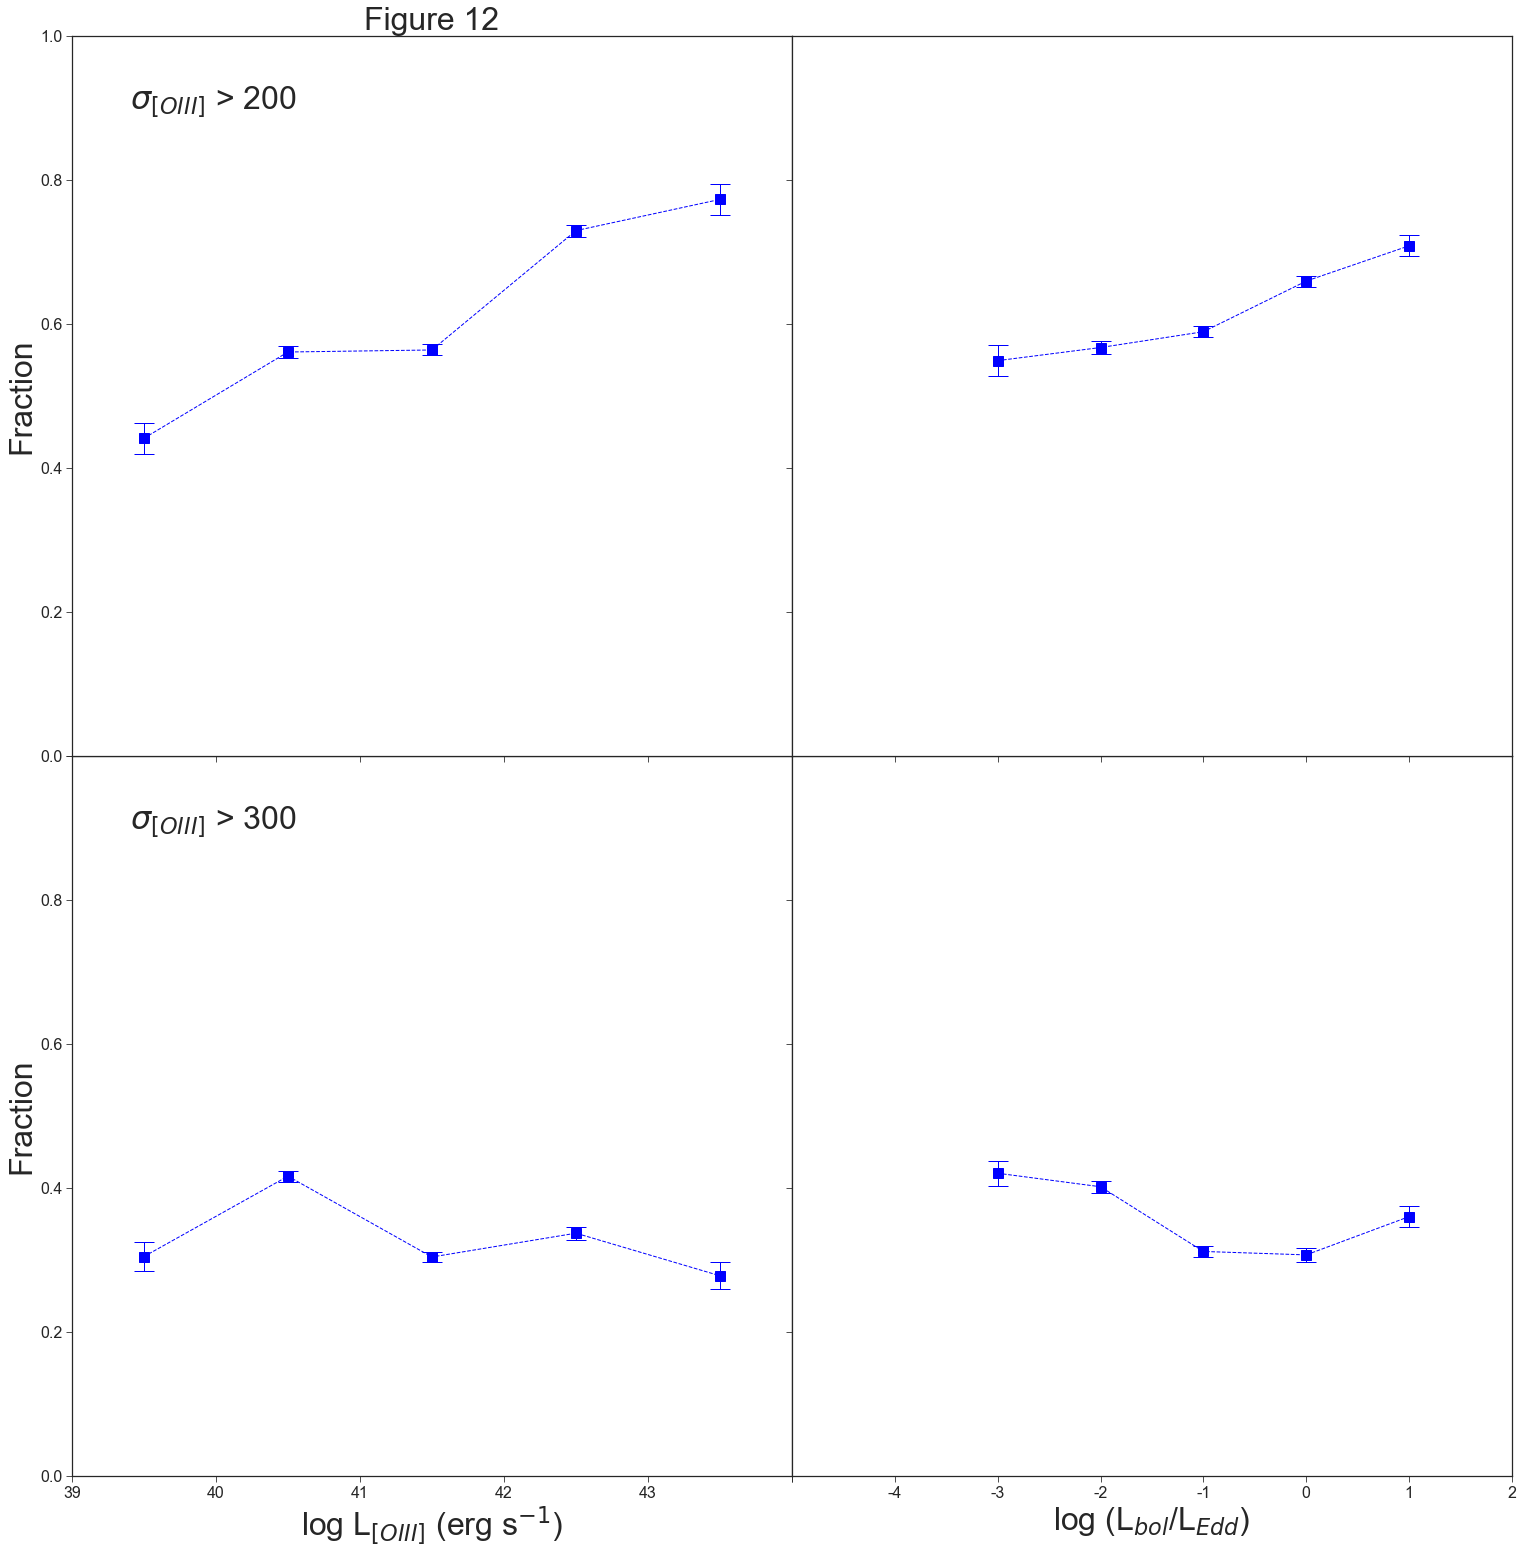

In [122]:
fig = plt.figure(figsize=(10,10))



ax1b = fig.add_axes([0, -1, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2b = fig.add_axes([1, -1, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )
ax1a = fig.add_axes([0, 0, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2a = fig.add_axes([1, 0, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )

ax1a.set_title('Figure 12', fontsize = 32)
ax1a.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig12_lum_sigmaOIII_frac1, fig12_lum_sigmaOIII_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
# ax1a.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1a.set_ylabel('Fraction', fontsize = 32)

ax1a.set_xticklabels([], fontsize = 16)
ax1a.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 16)
ax1a.text(39.4, 0.9, r'$\sigma$$_{[OIII]}$ > 200', fontsize = 32)

ax2a.errorbar(np.array([-3,-2,-1,0,1]), fig12_edd_sigmaOIII_frac1, fig12_edd_sigmaOIII_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2a.set_yticklabels([], fontsize = 16)
ax2a.set_xticklabels([], fontsize = 16)
# ax2a.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)


ax1b.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig12_lum_sigmaOIII_frac2, fig12_lum_sigmaOIII_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax1b.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel('Fraction', fontsize = 32)
ax1b.text(39.4, 0.9, r'$\sigma$$_{[OIII]}$ > 300', fontsize = 32)

ax1b.set_xticklabels([39,40,41,42, 43], fontsize = 16)
ax1b.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, ''], fontsize = 16)

ax2b.errorbar(np.array([-3,-2,-1,0,1]), fig12_edd_sigmaOIII_frac2, fig12_edd_sigmaOIII_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2b.set_yticklabels([], fontsize = 16)
ax2b.set_xticklabels(['',-4,-3, -2, -1, 0, 1, 2], fontsize = 16)
ax2b.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [123]:
fig13_wingveldis = np.concatenate((zbin1_wingveldis,
                                   zbin2_wingveldis,
                                   zbin3_wingveldis,
                                   zbin4_wingveldis
))

zbin1_wingveldis_err = zbin1_results_v2['WING_VELDIS_ERR'][(zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)]
zbin2_wingveldis_err = zbin2_results_v2['WING_VELDIS_ERR'][(zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)]
zbin3_wingveldis_err = zbin3_results_v2['WING_VELDIS_ERR'][(zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)]
zbin4_wingveldis_err = zbin4_results_v2['WING_VELDIS_ERR'][(zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)]

fig13_wingveldis_err = np.concatenate((zbin1_wingveldis_err,
                                       zbin2_wingveldis_err,
                                       zbin3_wingveldis_err,
                                       zbin4_wingveldis_err
))

zbin1_select_dg = (zbin1_results_v2['FLAG'] == 3) | (zbin1_results_v2['FLAG'] == 2)
zbin2_select_dg = (zbin2_results_v2['FLAG'] == 3) | (zbin2_results_v2['FLAG'] == 2)
zbin3_select_dg = (zbin3_results_v2['FLAG'] == 3) | (zbin3_results_v2['FLAG'] == 2)
zbin4_select_dg = (zbin4_results_v2['FLAG'] == 3) | (zbin4_results_v2['FLAG'] == 2)

zbin1_OIII_log_lum_array_fig13 = zbin1_OIII_log_lum_array[ zbin1_select_dg ]
zbin2_OIII_log_lum_array_fig13 = zbin2_OIII_log_lum_array[ zbin2_select_dg ]
zbin3_OIII_log_lum_array_fig13 = zbin3_OIII_log_lum_array[ zbin3_select_dg ]
zbin4_OIII_log_lum_array_fig13 = zbin4_OIII_log_lum_array[ zbin4_select_dg ]

fig13_log_lum = np.concatenate((zbin1_OIII_log_lum_array_fig13,
                                zbin2_OIII_log_lum_array_fig13,
                                zbin3_OIII_log_lum_array_fig13,
                                zbin4_OIII_log_lum_array_fig13
))

zbin1_log_edd_ratio_fig13 = zbin1_log_edd_ratio[ zbin1_select_dg ]
zbin2_log_edd_ratio_fig13 = zbin2_log_edd_ratio[ zbin2_select_dg ]
zbin3_log_edd_ratio_fig13 = zbin3_log_edd_ratio[ zbin3_select_dg ]
zbin4_log_edd_ratio_fig13 = zbin4_log_edd_ratio[ zbin4_select_dg ]

fig13_log_edd_ratio = np.concatenate((zbin1_log_edd_ratio_fig13,
                                      zbin2_log_edd_ratio_fig13,
                                      zbin3_log_edd_ratio_fig13,
                                      zbin4_log_edd_ratio_fig13
))

select_fig13_lumbin1 = (fig13_log_lum < 40)
select_fig13_lumbin2 = (fig13_log_lum < 41) & (fig13_log_lum > 40)
select_fig13_lumbin3 = (fig13_log_lum < 42) & (fig13_log_lum > 41)
select_fig13_lumbin4 = (fig13_log_lum < 43) & (fig13_log_lum > 42)
select_fig13_lumbin5 = (fig13_log_lum > 43)

select_fig13_eddbin1  = ( fig13_log_edd_ratio < -3.5 )
select_fig13_eddbin2  = ( fig13_log_edd_ratio < -2.5 ) & ( fig13_log_edd_ratio > -3.5 )
select_fig13_eddbin3  = ( fig13_log_edd_ratio < -1.5 ) & ( fig13_log_edd_ratio > -2.5 )
select_fig13_eddbin4  = ( fig13_log_edd_ratio < -0.5 ) & ( fig13_log_edd_ratio > -1.5 )
select_fig13_eddbin5  = ( fig13_log_edd_ratio <  0.5 ) & ( fig13_log_edd_ratio > -0.5 )
select_fig13_eddbin6  = ( fig13_log_edd_ratio >  0.5 )

lumbin1_wingveldis_frac1_total = []
lumbin2_wingveldis_frac1_total = []
lumbin3_wingveldis_frac1_total = []
lumbin4_wingveldis_frac1_total = []
lumbin5_wingveldis_frac1_total = []

lumbin1_wingveldis_frac2_total = []
lumbin2_wingveldis_frac2_total = []
lumbin3_wingveldis_frac2_total = []
lumbin4_wingveldis_frac2_total = []
lumbin5_wingveldis_frac2_total = []

eddbin2_wingveldis_frac1_total = []
eddbin3_wingveldis_frac1_total = []
eddbin4_wingveldis_frac1_total = []
eddbin5_wingveldis_frac1_total = []
eddbin6_wingveldis_frac1_total = []

eddbin2_wingveldis_frac2_total = []
eddbin3_wingveldis_frac2_total = []
eddbin4_wingveldis_frac2_total = []
eddbin5_wingveldis_frac2_total = []
eddbin6_wingveldis_frac2_total = []

for _ in range(100):
    
    fig13_wingveldis_iter = np.random.normal(fig13_wingveldis, fig13_wingveldis_err)

    lumbin1_wingveldis = fig13_wingveldis_iter[select_fig13_lumbin1]
    lumbin2_wingveldis = fig13_wingveldis_iter[select_fig13_lumbin2]
    lumbin3_wingveldis = fig13_wingveldis_iter[select_fig13_lumbin3]
    lumbin4_wingveldis = fig13_wingveldis_iter[select_fig13_lumbin4]
    lumbin5_wingveldis = fig13_wingveldis_iter[select_fig13_lumbin5]

    lumbin1_wingveldis_frac1 = len(lumbin1_wingveldis[lumbin1_wingveldis >= 800]) / len(lumbin1_wingveldis)
    lumbin2_wingveldis_frac1 = len(lumbin2_wingveldis[lumbin2_wingveldis >= 800]) / len(lumbin2_wingveldis)
    lumbin3_wingveldis_frac1 = len(lumbin3_wingveldis[lumbin3_wingveldis >= 800]) / len(lumbin3_wingveldis)
    lumbin4_wingveldis_frac1 = len(lumbin4_wingveldis[lumbin4_wingveldis >= 800]) / len(lumbin4_wingveldis)
    lumbin5_wingveldis_frac1 = len(lumbin5_wingveldis[lumbin5_wingveldis >= 800]) / len(lumbin5_wingveldis)

     

    lumbin1_wingveldis_frac2 = len(lumbin1_wingveldis[lumbin1_wingveldis >= 1000]) / len(lumbin1_wingveldis)
    lumbin2_wingveldis_frac2 = len(lumbin2_wingveldis[lumbin2_wingveldis >= 1000]) / len(lumbin2_wingveldis)
    lumbin3_wingveldis_frac2 = len(lumbin3_wingveldis[lumbin3_wingveldis >= 1000]) / len(lumbin3_wingveldis)
    lumbin4_wingveldis_frac2 = len(lumbin4_wingveldis[lumbin4_wingveldis >= 1000]) / len(lumbin4_wingveldis)
    lumbin5_wingveldis_frac2 = len(lumbin5_wingveldis[lumbin5_wingveldis >= 1000]) / len(lumbin5_wingveldis)

     

    eddbin1_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin1]
    eddbin2_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin2]
    eddbin3_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin3]
    eddbin4_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin4]
    eddbin5_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin5]
    eddbin6_wingveldis = fig13_wingveldis_iter[select_fig13_eddbin6]

    eddbin2_wingveldis = np.concatenate((eddbin1_wingveldis, eddbin2_wingveldis))

    # eddbin1_wingveldis_frac1 = len(eddbin1_wingveldis[eddbin1_wingveldis >= 800]) / len(eddbin1_wingveldis)
    eddbin2_wingveldis_frac1 = len(eddbin2_wingveldis[eddbin2_wingveldis >= 800]) / len(eddbin2_wingveldis)
    eddbin3_wingveldis_frac1 = len(eddbin3_wingveldis[eddbin3_wingveldis >= 800]) / len(eddbin3_wingveldis)
    eddbin4_wingveldis_frac1 = len(eddbin4_wingveldis[eddbin4_wingveldis >= 800]) / len(eddbin4_wingveldis)
    eddbin5_wingveldis_frac1 = len(eddbin5_wingveldis[eddbin5_wingveldis >= 800]) / len(eddbin5_wingveldis)
    eddbin6_wingveldis_frac1 = len(eddbin6_wingveldis[eddbin6_wingveldis >= 800]) / len(eddbin6_wingveldis)


     

    # eddbin1_wingveldis_frac2 = len(eddbin1_wingveldis[eddbin1_wingveldis >= 1000]) / len(eddbin1_wingveldis)
    eddbin2_wingveldis_frac2 = len(eddbin2_wingveldis[eddbin2_wingveldis >= 1000]) / len(eddbin2_wingveldis)
    eddbin3_wingveldis_frac2 = len(eddbin3_wingveldis[eddbin3_wingveldis >= 1000]) / len(eddbin3_wingveldis)
    eddbin4_wingveldis_frac2 = len(eddbin4_wingveldis[eddbin4_wingveldis >= 1000]) / len(eddbin4_wingveldis)
    eddbin5_wingveldis_frac2 = len(eddbin5_wingveldis[eddbin5_wingveldis >= 1000]) / len(eddbin5_wingveldis)
    eddbin6_wingveldis_frac2 = len(eddbin6_wingveldis[eddbin6_wingveldis >= 1000]) / len(eddbin6_wingveldis)
    
    lumbin1_wingveldis_frac1_total.append(lumbin1_wingveldis_frac1)
    lumbin2_wingveldis_frac1_total.append(lumbin2_wingveldis_frac1)
    lumbin3_wingveldis_frac1_total.append(lumbin3_wingveldis_frac1)
    lumbin4_wingveldis_frac1_total.append(lumbin4_wingveldis_frac1)
    lumbin5_wingveldis_frac1_total.append(lumbin5_wingveldis_frac1)
    
    lumbin1_wingveldis_frac2_total.append(lumbin1_wingveldis_frac2)
    lumbin2_wingveldis_frac2_total.append(lumbin2_wingveldis_frac2)
    lumbin3_wingveldis_frac2_total.append(lumbin3_wingveldis_frac2)
    lumbin4_wingveldis_frac2_total.append(lumbin4_wingveldis_frac2)
    lumbin5_wingveldis_frac2_total.append(lumbin5_wingveldis_frac2)
    
    eddbin2_wingveldis_frac1_total.append(eddbin2_wingveldis_frac1)
    eddbin3_wingveldis_frac1_total.append(eddbin3_wingveldis_frac1)
    eddbin4_wingveldis_frac1_total.append(eddbin4_wingveldis_frac1)
    eddbin5_wingveldis_frac1_total.append(eddbin5_wingveldis_frac1)
    eddbin6_wingveldis_frac1_total.append(eddbin6_wingveldis_frac1)
    
    eddbin2_wingveldis_frac2_total.append(eddbin2_wingveldis_frac2)
    eddbin3_wingveldis_frac2_total.append(eddbin3_wingveldis_frac2)
    eddbin4_wingveldis_frac2_total.append(eddbin4_wingveldis_frac2)
    eddbin5_wingveldis_frac2_total.append(eddbin5_wingveldis_frac2)
    eddbin6_wingveldis_frac2_total.append(eddbin6_wingveldis_frac2)

fig13_lum_wingveldis_frac1 = np.array([np.mean(lumbin1_wingveldis_frac1_total),
                                       np.mean(lumbin2_wingveldis_frac1_total),
                                       np.mean(lumbin3_wingveldis_frac1_total),
                                       np.mean(lumbin4_wingveldis_frac1_total),
                                       np.mean(lumbin5_wingveldis_frac1_total)
    
])

fig13_lum_wingveldis_err_frac1 = np.array([np.std(lumbin1_wingveldis_frac1_total),
                                           np.std(lumbin2_wingveldis_frac1_total),
                                           np.std(lumbin3_wingveldis_frac1_total),
                                           np.std(lumbin4_wingveldis_frac1_total),
                                           np.std(lumbin5_wingveldis_frac1_total)
    
])
    
    
fig13_lum_wingveldis_frac2 = np.array([np.mean(lumbin1_wingveldis_frac2_total),
                                       np.mean(lumbin2_wingveldis_frac2_total),
                                       np.mean(lumbin3_wingveldis_frac2_total),
                                       np.mean(lumbin4_wingveldis_frac2_total),
                                       np.mean(lumbin5_wingveldis_frac2_total)
    
])

fig13_lum_wingveldis_err_frac2 = np.array([np.std(lumbin1_wingveldis_frac2_total),
                                           np.std(lumbin2_wingveldis_frac2_total),
                                           np.std(lumbin3_wingveldis_frac2_total),
                                           np.std(lumbin4_wingveldis_frac2_total),
                                           np.std(lumbin5_wingveldis_frac2_total)
    
])
    
fig13_edd_wingveldis_frac1 = np.array([np.mean(eddbin2_wingveldis_frac1_total),
                                       np.mean(eddbin3_wingveldis_frac1_total),
                                       np.mean(eddbin4_wingveldis_frac1_total),
                                       np.mean(eddbin5_wingveldis_frac1_total),
                                       np.mean(eddbin6_wingveldis_frac1_total),
     
])

fig13_edd_wingveldis_err_frac1 = np.array([np.std(eddbin2_wingveldis_frac1_total),
                                           np.std(eddbin3_wingveldis_frac1_total),
                                           np.std(eddbin4_wingveldis_frac1_total),
                                           np.std(eddbin5_wingveldis_frac1_total),
                                           np.std(eddbin6_wingveldis_frac1_total),
    
])

fig13_edd_wingveldis_frac2 = np.array([np.mean(eddbin2_wingveldis_frac2_total),
                                       np.mean(eddbin3_wingveldis_frac2_total),
                                       np.mean(eddbin4_wingveldis_frac2_total),
                                       np.mean(eddbin5_wingveldis_frac2_total),
                                       np.mean(eddbin6_wingveldis_frac2_total),
     
])

fig13_edd_wingveldis_err_frac2 = np.array([np.std(eddbin2_wingveldis_frac2_total),
                                           np.std(eddbin3_wingveldis_frac2_total),
                                           np.std(eddbin4_wingveldis_frac2_total),
                                           np.std(eddbin5_wingveldis_frac2_total),
                                           np.std(eddbin6_wingveldis_frac2_total),
    
])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


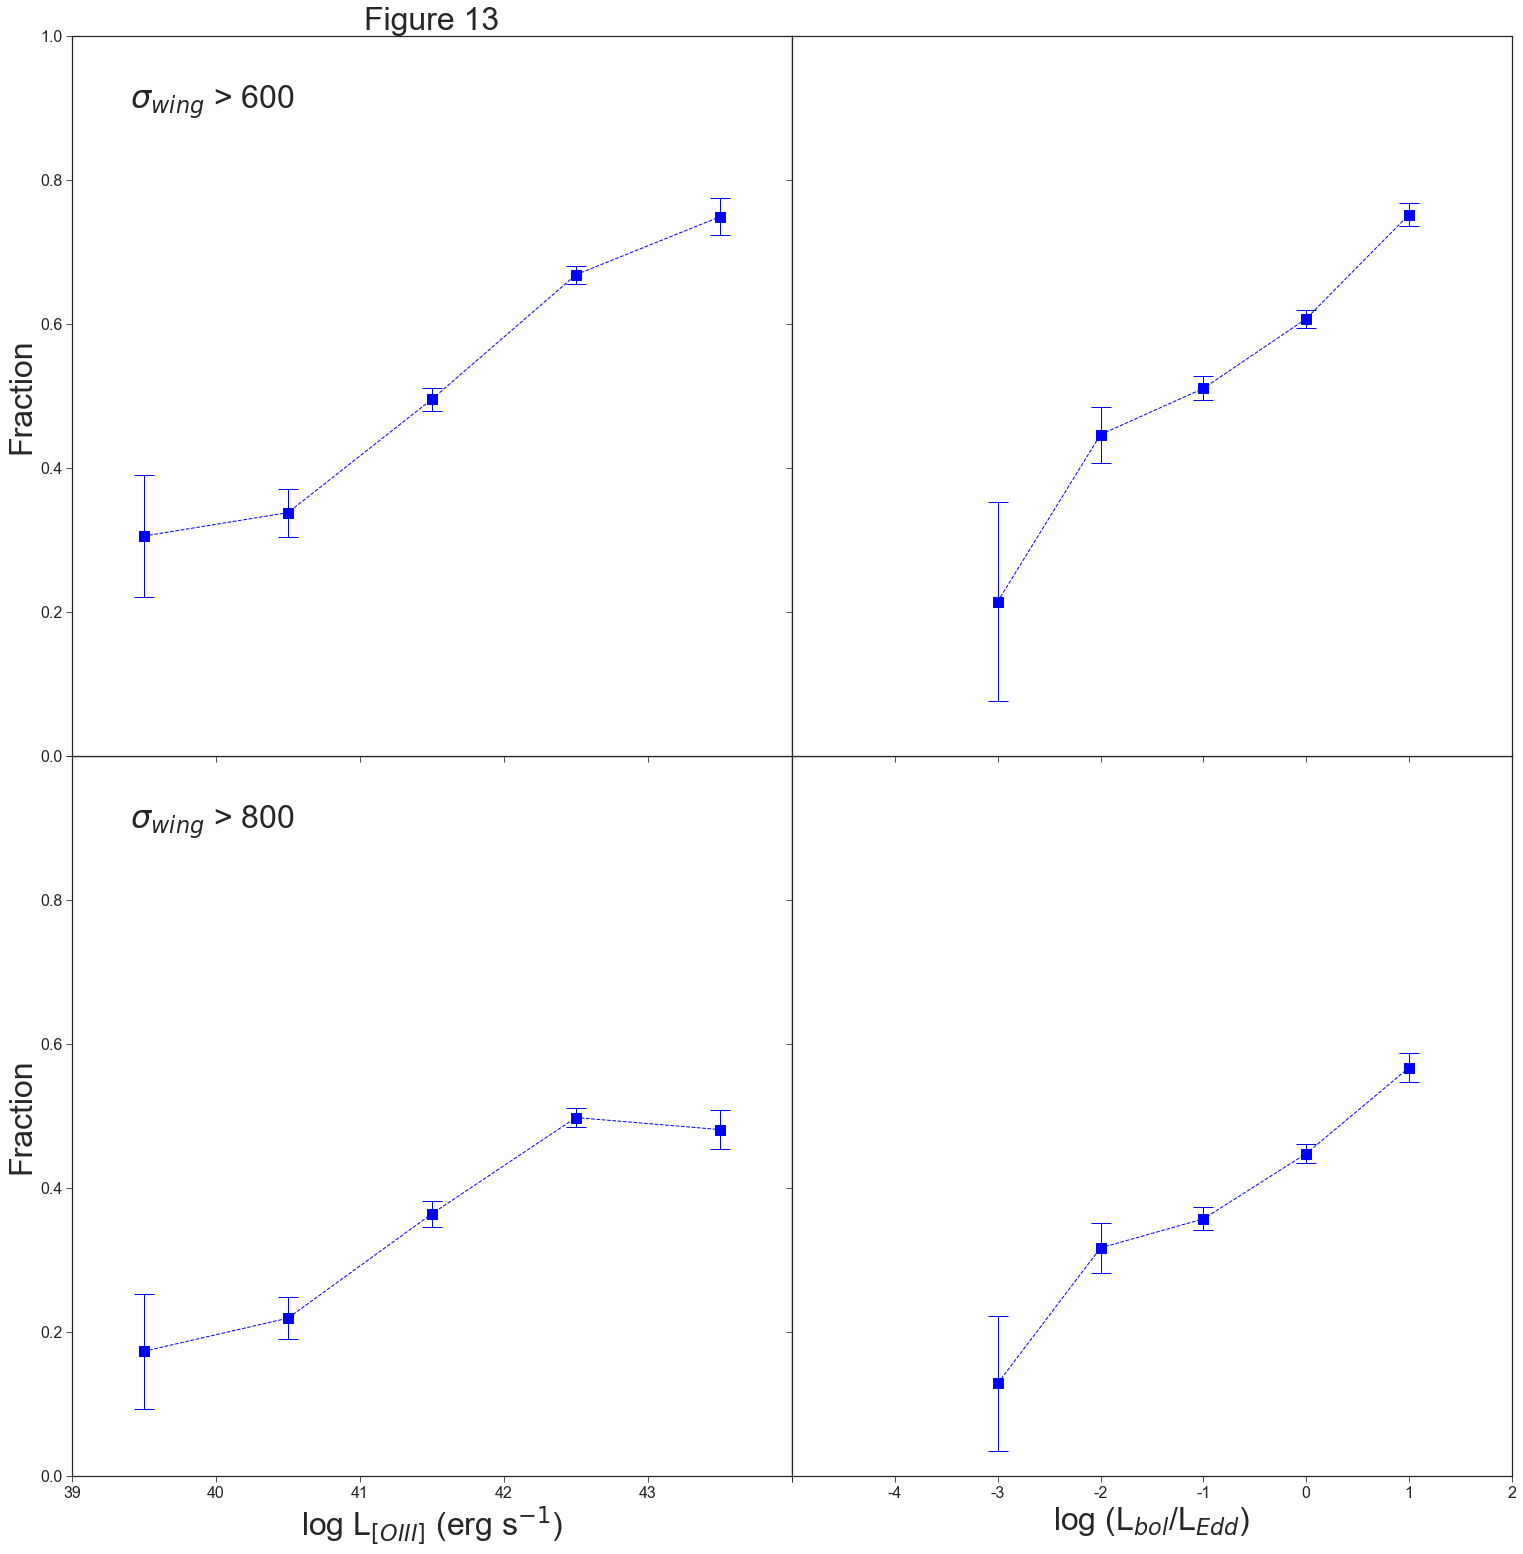

In [124]:
fig = plt.figure(figsize=(10,10))



ax1b = fig.add_axes([0, -1, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2b = fig.add_axes([1, -1, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )
ax1a = fig.add_axes([0, 0, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2a = fig.add_axes([1, 0, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )

ax1a.set_title('Figure 13', fontsize = 32)
ax1a.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig13_lum_wingveldis_frac1, fig13_lum_wingveldis_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
# ax1a.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1a.set_ylabel('Fraction', fontsize = 32)

ax1a.set_xticklabels([], fontsize = 16)
ax1a.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 16)
ax1a.text(39.4, 0.9, r'$\sigma$$_{wing}$ > 600', fontsize = 32)

ax2a.errorbar(np.array([-3,-2,-1,0,1]), fig13_edd_wingveldis_frac1, fig13_edd_wingveldis_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2a.set_yticklabels([], fontsize = 16)
ax2a.set_xticklabels([], fontsize = 16)
# ax2a.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)


ax1b.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig13_lum_wingveldis_frac2, fig13_lum_wingveldis_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax1b.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel('Fraction', fontsize = 32)
ax1b.text(39.4, 0.9, r'$\sigma$$_{wing}$ > 800', fontsize = 32)

ax1b.set_xticklabels([39,40,41,42, 43], fontsize = 16)
ax1b.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, ''], fontsize = 16)

ax2b.errorbar(np.array([-3,-2,-1,0,1]), fig13_edd_wingveldis_frac2, fig13_edd_wingveldis_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2b.set_yticklabels([], fontsize = 16)
ax2b.set_xticklabels(['',-4,-3, -2, -1, 0, 1, 2], fontsize = 16)
ax2b.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [125]:
fig14_sigma_ratio = np.concatenate((zbin1_sigma_ratio,
                                    zbin2_sigma_ratio,
                                    zbin3_sigma_ratio,
                                    zbin4_sigma_ratio
                                   ))

fig14_sigmaOIII_err = fig12_sigmaOIII_err

fig14_sigma_OIII = fig12_sigmaOIII

fig14_sigma_stars = np.concatenate((zbin1_sigma_stars,
                                    zbin2_sigma_stars,
                                    zbin3_sigma_stars,
                                    zbin4_sigma_stars,
))

fig14_sigma_stars_err = np.concatenate((zbin1_data_v2['SIGMA_STARS_ERR'],
                                        zbin2_data_v2['SIGMA_STARS_ERR'],
                                        zbin3_data_v2['SIGMA_STARS_ERR'],
                                        zbin4_data_v2['SIGMA_STARS_ERR'],
))

fig14_sigma_ratio_err = fig14_sigma_ratio * (np.sqrt( ( (fig14_sigmaOIII_err / fig14_sigma_OIII) ** 2 ) + ( (fig14_sigma_stars_err / fig14_sigma_stars) ** 2 ) ) )

fig14_sigma_ratio_err = np.abs(fig14_sigma_ratio_err)

lumbin1_sigma_ratio_frac1_total = []
lumbin2_sigma_ratio_frac1_total = []
lumbin3_sigma_ratio_frac1_total = []
lumbin4_sigma_ratio_frac1_total = []
lumbin5_sigma_ratio_frac1_total = []

lumbin1_sigma_ratio_frac2_total = []
lumbin2_sigma_ratio_frac2_total = []
lumbin3_sigma_ratio_frac2_total = []
lumbin4_sigma_ratio_frac2_total = []
lumbin5_sigma_ratio_frac2_total = []

eddbin2_sigma_ratio_frac1_total = []
eddbin3_sigma_ratio_frac1_total = []
eddbin4_sigma_ratio_frac1_total = []
eddbin5_sigma_ratio_frac1_total = []
eddbin6_sigma_ratio_frac1_total = []

eddbin2_sigma_ratio_frac2_total = []
eddbin3_sigma_ratio_frac2_total = []
eddbin4_sigma_ratio_frac2_total = []
eddbin5_sigma_ratio_frac2_total = []
eddbin6_sigma_ratio_frac2_total = []

for _ in range(100):
    
    fig14_sigma_ratio_iter = np.random.normal(fig14_sigma_ratio, fig14_sigma_ratio_err)

    lumbin1_sigma_ratio = fig14_sigma_ratio_iter[select_lumbin1]
    lumbin2_sigma_ratio = fig14_sigma_ratio_iter[select_lumbin2]
    lumbin3_sigma_ratio = fig14_sigma_ratio_iter[select_lumbin3]
    lumbin4_sigma_ratio = fig14_sigma_ratio_iter[select_lumbin4]
    lumbin5_sigma_ratio = fig14_sigma_ratio_iter[select_lumbin5]

    lumbin1_sigma_ratio_frac1 = len(lumbin1_sigma_ratio[lumbin1_sigma_ratio > 1]) / len(lumbin1_sigma_ratio)
    lumbin2_sigma_ratio_frac1 = len(lumbin2_sigma_ratio[lumbin2_sigma_ratio > 1]) / len(lumbin2_sigma_ratio)
    lumbin3_sigma_ratio_frac1 = len(lumbin3_sigma_ratio[lumbin3_sigma_ratio > 1]) / len(lumbin3_sigma_ratio)
    lumbin4_sigma_ratio_frac1 = len(lumbin4_sigma_ratio[lumbin4_sigma_ratio > 1]) / len(lumbin4_sigma_ratio)
    lumbin5_sigma_ratio_frac1 = len(lumbin5_sigma_ratio[lumbin5_sigma_ratio > 1]) / len(lumbin5_sigma_ratio)

     

    lumbin1_sigma_ratio_frac2 = len(lumbin1_sigma_ratio[lumbin1_sigma_ratio > 1.4]) / len(lumbin1_sigma_ratio)
    lumbin2_sigma_ratio_frac2 = len(lumbin2_sigma_ratio[lumbin2_sigma_ratio > 1.4]) / len(lumbin2_sigma_ratio)
    lumbin3_sigma_ratio_frac2 = len(lumbin3_sigma_ratio[lumbin3_sigma_ratio > 1.4]) / len(lumbin3_sigma_ratio)
    lumbin4_sigma_ratio_frac2 = len(lumbin4_sigma_ratio[lumbin4_sigma_ratio > 1.4]) / len(lumbin4_sigma_ratio)
    lumbin5_sigma_ratio_frac2 = len(lumbin5_sigma_ratio[lumbin5_sigma_ratio > 1.4]) / len(lumbin5_sigma_ratio)

    eddbin1_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin1]
    eddbin2_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin2]
    eddbin3_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin3]
    eddbin4_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin4]
    eddbin5_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin5]
    eddbin6_sigma_ratio = fig14_sigma_ratio_iter[select_eddbin6]

    eddbin2_sigma_ratio = np.concatenate((eddbin1_sigma_ratio, eddbin2_sigma_ratio))

    # eddbin1_sigma_ratio_frac1 = len(eddbin1_sigma_ratio[eddbin1_sigma_ratio > 1]) / len(eddbin1_sigma_ratio)
    eddbin2_sigma_ratio_frac1 = len(eddbin2_sigma_ratio[eddbin2_sigma_ratio > 1]) / len(eddbin2_sigma_ratio)
    eddbin3_sigma_ratio_frac1 = len(eddbin3_sigma_ratio[eddbin3_sigma_ratio > 1]) / len(eddbin3_sigma_ratio)
    eddbin4_sigma_ratio_frac1 = len(eddbin4_sigma_ratio[eddbin4_sigma_ratio > 1]) / len(eddbin4_sigma_ratio)
    eddbin5_sigma_ratio_frac1 = len(eddbin5_sigma_ratio[eddbin5_sigma_ratio > 1]) / len(eddbin5_sigma_ratio)
    eddbin6_sigma_ratio_frac1 = len(eddbin6_sigma_ratio[eddbin6_sigma_ratio > 1]) / len(eddbin6_sigma_ratio) 

    # eddbin1_sigma_ratio_frac2 = len(eddbin1_sigma_ratio[eddbin1_sigma_ratio > 1.4]) / len(eddbin1_sigma_ratio)
    eddbin2_sigma_ratio_frac2 = len(eddbin2_sigma_ratio[eddbin2_sigma_ratio > 1.4]) / len(eddbin2_sigma_ratio)
    eddbin3_sigma_ratio_frac2 = len(eddbin3_sigma_ratio[eddbin3_sigma_ratio > 1.4]) / len(eddbin3_sigma_ratio)
    eddbin4_sigma_ratio_frac2 = len(eddbin4_sigma_ratio[eddbin4_sigma_ratio > 1.4]) / len(eddbin4_sigma_ratio)
    eddbin5_sigma_ratio_frac2 = len(eddbin5_sigma_ratio[eddbin5_sigma_ratio > 1.4]) / len(eddbin5_sigma_ratio)
    eddbin6_sigma_ratio_frac2 = len(eddbin6_sigma_ratio[eddbin6_sigma_ratio > 1.4]) / len(eddbin6_sigma_ratio)


    lumbin1_sigma_ratio_frac1_total.append(lumbin1_sigma_ratio_frac1)
    lumbin2_sigma_ratio_frac1_total.append(lumbin2_sigma_ratio_frac1)
    lumbin3_sigma_ratio_frac1_total.append(lumbin3_sigma_ratio_frac1)
    lumbin4_sigma_ratio_frac1_total.append(lumbin4_sigma_ratio_frac1)
    lumbin5_sigma_ratio_frac1_total.append(lumbin5_sigma_ratio_frac1)
    
    lumbin1_sigma_ratio_frac2_total.append(lumbin1_sigma_ratio_frac2)
    lumbin2_sigma_ratio_frac2_total.append(lumbin2_sigma_ratio_frac2)
    lumbin3_sigma_ratio_frac2_total.append(lumbin3_sigma_ratio_frac2)
    lumbin4_sigma_ratio_frac2_total.append(lumbin4_sigma_ratio_frac2)
    lumbin5_sigma_ratio_frac2_total.append(lumbin5_sigma_ratio_frac2)
    
    eddbin2_sigma_ratio_frac1_total.append(eddbin2_sigma_ratio_frac1)
    eddbin3_sigma_ratio_frac1_total.append(eddbin3_sigma_ratio_frac1)
    eddbin4_sigma_ratio_frac1_total.append(eddbin4_sigma_ratio_frac1)
    eddbin5_sigma_ratio_frac1_total.append(eddbin5_sigma_ratio_frac1)
    eddbin6_sigma_ratio_frac1_total.append(eddbin6_sigma_ratio_frac1)
    
    eddbin2_sigma_ratio_frac2_total.append(eddbin2_sigma_ratio_frac2)
    eddbin3_sigma_ratio_frac2_total.append(eddbin3_sigma_ratio_frac2)
    eddbin4_sigma_ratio_frac2_total.append(eddbin4_sigma_ratio_frac2)
    eddbin5_sigma_ratio_frac2_total.append(eddbin5_sigma_ratio_frac2)
    eddbin6_sigma_ratio_frac2_total.append(eddbin6_sigma_ratio_frac2)

fig14_lum_sigma_ratio_frac1 = np.array([np.mean(lumbin1_sigma_ratio_frac1_total),
                                        np.mean(lumbin2_sigma_ratio_frac1_total),
                                        np.mean(lumbin3_sigma_ratio_frac1_total),
                                        np.mean(lumbin4_sigma_ratio_frac1_total),
                                        np.mean(lumbin5_sigma_ratio_frac1_total),
    
])

fig14_lum_sigma_ratio_err_frac1 = np.array([np.std(lumbin1_sigma_ratio_frac1_total),
                                            np.std(lumbin2_sigma_ratio_frac1_total),
                                            np.std(lumbin3_sigma_ratio_frac1_total),
                                            np.std(lumbin4_sigma_ratio_frac1_total),
                                            np.std(lumbin5_sigma_ratio_frac1_total),
    
])

fig14_lum_sigma_ratio_frac2 = np.array([np.mean(lumbin1_sigma_ratio_frac2_total),
                                        np.mean(lumbin2_sigma_ratio_frac2_total),
                                        np.mean(lumbin3_sigma_ratio_frac2_total),
                                        np.mean(lumbin4_sigma_ratio_frac2_total),
                                        np.mean(lumbin5_sigma_ratio_frac2_total),

])

fig14_lum_sigma_ratio_err_frac2 = np.array([np.std(lumbin1_sigma_ratio_frac2_total),
                                            np.std(lumbin2_sigma_ratio_frac2_total),
                                            np.std(lumbin3_sigma_ratio_frac2_total),
                                            np.std(lumbin4_sigma_ratio_frac2_total),
                                            np.std(lumbin5_sigma_ratio_frac2_total),
    
])
    
fig14_edd_sigma_ratio_frac1 = np.array([np.mean(eddbin2_sigma_ratio_frac1_total),
                                        np.mean(eddbin3_sigma_ratio_frac1_total),
                                        np.mean(eddbin4_sigma_ratio_frac1_total),
                                        np.mean(eddbin5_sigma_ratio_frac1_total),
                                        np.mean(eddbin6_sigma_ratio_frac1_total),
    
])

fig14_edd_sigma_ratio_err_frac1 = np.array([np.std(eddbin2_sigma_ratio_frac1_total),
                                            np.std(eddbin3_sigma_ratio_frac1_total),
                                            np.std(eddbin4_sigma_ratio_frac1_total),
                                            np.std(eddbin5_sigma_ratio_frac1_total),
                                            np.std(eddbin6_sigma_ratio_frac1_total),
    
])

fig14_edd_sigma_ratio_frac2 = np.array([np.mean(eddbin2_sigma_ratio_frac2_total),
                                        np.mean(eddbin3_sigma_ratio_frac2_total),
                                        np.mean(eddbin4_sigma_ratio_frac2_total),
                                        np.mean(eddbin5_sigma_ratio_frac2_total),
                                        np.mean(eddbin6_sigma_ratio_frac2_total),
    
])

fig14_edd_sigma_ratio_err_frac2 = np.array([np.std(eddbin2_sigma_ratio_frac2_total),
                                            np.std(eddbin3_sigma_ratio_frac2_total),
                                            np.std(eddbin4_sigma_ratio_frac2_total),
                                            np.std(eddbin5_sigma_ratio_frac2_total),
                                            np.std(eddbin6_sigma_ratio_frac2_total),
    
])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


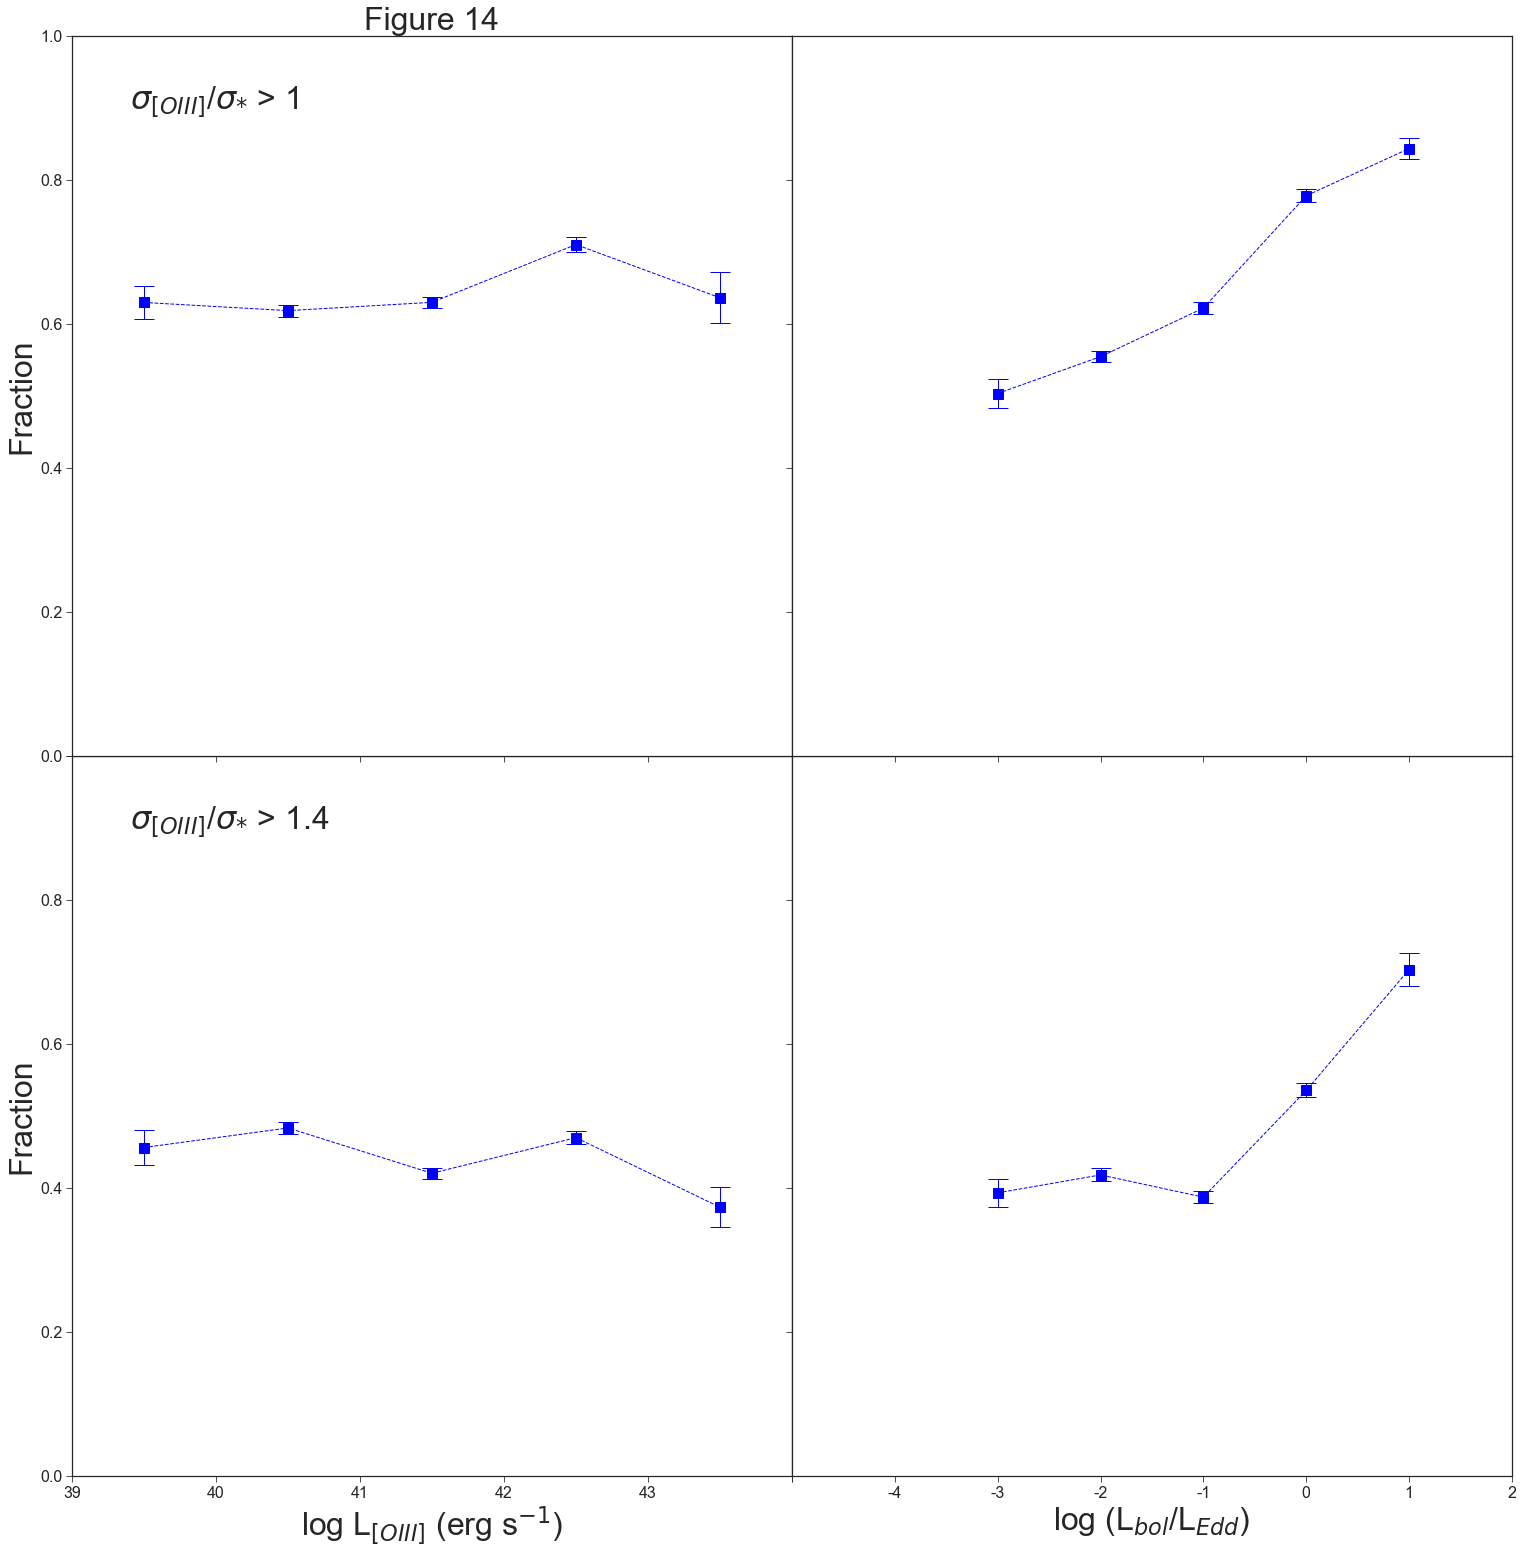

In [126]:
fig = plt.figure(figsize=(10,10))



ax1b = fig.add_axes([0, -1, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2b = fig.add_axes([1, -1, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )
ax1a = fig.add_axes([0, 0, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2a = fig.add_axes([1, 0, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )

ax1a.set_title('Figure 14', fontsize = 32)
ax1a.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig14_lum_sigma_ratio_frac1, fig14_lum_sigma_ratio_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
# ax1a.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1a.set_ylabel('Fraction', fontsize = 32)

ax1a.set_xticklabels([], fontsize = 16)
ax1a.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 16)
ax1a.text(39.4, 0.9, r'$\sigma$$_{[OIII]}$/$\sigma$$_{*}$ > 1', fontsize = 32)

ax2a.errorbar(np.array([-3,-2,-1,0,1]), fig14_edd_sigma_ratio_frac1, fig14_edd_sigma_ratio_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2a.set_yticklabels([], fontsize = 16)
ax2a.set_xticklabels([], fontsize = 16)
# ax2a.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)


ax1b.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig14_lum_sigma_ratio_frac2, fig14_lum_sigma_ratio_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax1b.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel('Fraction', fontsize = 32)
ax1b.text(39.4, 0.9, r'$\sigma$$_{[OIII]}$/$\sigma$$_{*}$ > 1.4', fontsize = 32)

ax1b.set_xticklabels([39,40,41,42, 43], fontsize = 16)
ax1b.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, ''], fontsize = 16)

ax2b.errorbar(np.array([-3,-2,-1,0,1]), fig14_edd_sigma_ratio_frac2, fig14_edd_sigma_ratio_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2b.set_yticklabels([], fontsize = 16)
ax2b.set_xticklabels(['',-4,-3, -2, -1, 0, 1, 2], fontsize = 16)
ax2b.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [127]:
fig15_OIII_vel = np.concatenate((np.array(OIII_vel_array_zbin1_good[select_zbin1_edd_cut]),
                                 np.array(OIII_vel_array_zbin2_good[select_zbin2_edd_cut]),
                                 np.array(OIII_vel_array_zbin3_good[select_zbin3_edd_cut]),
                                 np.array(OIII_vel_array_zbin4_good[select_zbin4_edd_cut])
))

fig15_core_vel = np.concatenate((np.array(core_vel_zbin1),
                                 np.array(core_vel_zbin2),
                                 np.array(core_vel_zbin3),
                                 np.array(core_vel_zbin4)
))


fig15_OIII_vel_err = np.concatenate((OIII_vel_err_array_zbin1[select_good_zbin1][select_zbin1_edd_cut],
                                     OIII_vel_err_array_zbin2[select_good_zbin2][select_zbin2_edd_cut],
                                     OIII_vel_err_array_zbin3[select_good_zbin3][select_zbin3_edd_cut],
                                     OIII_vel_err_array_zbin4[select_good_zbin4][select_zbin4_edd_cut]
))

fig15_core_vel_err = np.concatenate((np.array(core_vel_err_zbin1),
                                     np.array(core_vel_err_zbin2),
                                     np.array(core_vel_err_zbin3),
                                     np.array(core_vel_err_zbin4)
))
    
fig15_vel_shift = np.concatenate((zbin1_vs,
                                  zbin2_vs,
                                  zbin3_vs,
                                  zbin4_vs
))

fig15_vel_shift = np.abs(fig15_vel_shift)
    
lumbin1_vel_shift_frac1_total = []
lumbin2_vel_shift_frac1_total = []
lumbin3_vel_shift_frac1_total = []
lumbin4_vel_shift_frac1_total = []
lumbin5_vel_shift_frac1_total = []

lumbin1_vel_shift_frac2_total = []
lumbin2_vel_shift_frac2_total = []
lumbin3_vel_shift_frac2_total = []
lumbin4_vel_shift_frac2_total = []
lumbin5_vel_shift_frac2_total = []

eddbin2_vel_shift_frac1_total = []
eddbin3_vel_shift_frac1_total = []
eddbin4_vel_shift_frac1_total = []
eddbin5_vel_shift_frac1_total = []
eddbin6_vel_shift_frac1_total = []

eddbin2_vel_shift_frac2_total = []
eddbin3_vel_shift_frac2_total = []
eddbin4_vel_shift_frac2_total = []
eddbin5_vel_shift_frac2_total = []
eddbin6_vel_shift_frac2_total = []

ye = []

for _ in range(1000):
    
    fig15_OIII_vel_iter = np.random.normal(fig15_OIII_vel, fig15_OIII_vel_err)
    fig15_core_vel_iter = np.random.normal(fig15_core_vel, fig15_core_vel_err)
    
    fig15_vel_shift_iter = fig15_OIII_vel_iter - fig15_core_vel_iter
    
    fig15_vel_shift_iter = np.abs(fig15_vel_shift_iter)
    
    for i in range(len(fig15_vel_shift_iter)):
        if fig15_vel_shift_iter[i] >= (fig15_vel_shift[i] + 180):
            fig15_vel_shift_iter[i] = fig15_vel_shift[i]
            ye.append('ye')
    
    lumbin1_vel_shift = fig15_vel_shift_iter[select_lumbin1]
    lumbin2_vel_shift = fig15_vel_shift_iter[select_lumbin2]
    lumbin3_vel_shift = fig15_vel_shift_iter[select_lumbin3]
    lumbin4_vel_shift = fig15_vel_shift_iter[select_lumbin4]
    lumbin5_vel_shift = fig15_vel_shift_iter[select_lumbin5]

    lumbin1_vel_shift_frac1 = len(lumbin1_vel_shift[lumbin1_vel_shift > 120]) / len(lumbin1_vel_shift)
    lumbin2_vel_shift_frac1 = len(lumbin2_vel_shift[lumbin2_vel_shift > 120]) / len(lumbin2_vel_shift)
    lumbin3_vel_shift_frac1 = len(lumbin3_vel_shift[lumbin3_vel_shift > 120]) / len(lumbin3_vel_shift)
    lumbin4_vel_shift_frac1 = len(lumbin4_vel_shift[lumbin4_vel_shift > 120]) / len(lumbin4_vel_shift)
    lumbin5_vel_shift_frac1 = len(lumbin5_vel_shift[lumbin5_vel_shift > 120]) / len(lumbin5_vel_shift)

    lumbin1_vel_shift_frac2 = len(lumbin1_vel_shift[lumbin1_vel_shift > 240]) / len(lumbin1_vel_shift)
    lumbin2_vel_shift_frac2 = len(lumbin2_vel_shift[lumbin2_vel_shift > 240]) / len(lumbin2_vel_shift)
    lumbin3_vel_shift_frac2 = len(lumbin3_vel_shift[lumbin3_vel_shift > 240]) / len(lumbin3_vel_shift)
    lumbin4_vel_shift_frac2 = len(lumbin4_vel_shift[lumbin4_vel_shift > 240]) / len(lumbin4_vel_shift)
    lumbin5_vel_shift_frac2 = len(lumbin5_vel_shift[lumbin5_vel_shift > 240]) / len(lumbin5_vel_shift)

    eddbin1_vel_shift = fig15_vel_shift_iter[select_eddbin1]
    eddbin2_vel_shift = fig15_vel_shift_iter[select_eddbin2]
    eddbin3_vel_shift = fig15_vel_shift_iter[select_eddbin3]
    eddbin4_vel_shift = fig15_vel_shift_iter[select_eddbin4]
    eddbin5_vel_shift = fig15_vel_shift_iter[select_eddbin5]
    eddbin6_vel_shift = fig15_vel_shift_iter[select_eddbin6]

    eddbin2_vel_shift = np.concatenate((eddbin1_vel_shift, eddbin2_vel_shift))

    # eddbin1_vel_shift_frac1 = len(eddbin1_vel_shift[eddbin1_vel_shift > 120]) / len(eddbin1_vel_shift)
    eddbin2_vel_shift_frac1 = len(eddbin2_vel_shift[eddbin2_vel_shift > 120]) / len(eddbin2_vel_shift)
    eddbin3_vel_shift_frac1 = len(eddbin3_vel_shift[eddbin3_vel_shift > 120]) / len(eddbin3_vel_shift)
    eddbin4_vel_shift_frac1 = len(eddbin4_vel_shift[eddbin4_vel_shift > 120]) / len(eddbin4_vel_shift)
    eddbin5_vel_shift_frac1 = len(eddbin5_vel_shift[eddbin5_vel_shift > 120]) / len(eddbin5_vel_shift)
    eddbin6_vel_shift_frac1 = len(eddbin6_vel_shift[eddbin6_vel_shift > 120]) / len(eddbin6_vel_shift)

    
    # eddbin1_vel_shift_frac2 = len(eddbin1_vel_shift[eddbin1_vel_shift > 240]) / len(eddbin1_vel_shift)
    eddbin2_vel_shift_frac2 = len(eddbin2_vel_shift[eddbin2_vel_shift > 240]) / len(eddbin2_vel_shift)
    eddbin3_vel_shift_frac2 = len(eddbin3_vel_shift[eddbin3_vel_shift > 240]) / len(eddbin3_vel_shift)
    eddbin4_vel_shift_frac2 = len(eddbin4_vel_shift[eddbin4_vel_shift > 240]) / len(eddbin4_vel_shift)
    eddbin5_vel_shift_frac2 = len(eddbin5_vel_shift[eddbin5_vel_shift > 240]) / len(eddbin5_vel_shift)
    eddbin6_vel_shift_frac2 = len(eddbin6_vel_shift[eddbin6_vel_shift > 240]) / len(eddbin6_vel_shift)

    lumbin1_vel_shift_frac1_total.append(lumbin1_vel_shift_frac1)
    lumbin2_vel_shift_frac1_total.append(lumbin2_vel_shift_frac1)
    lumbin3_vel_shift_frac1_total.append(lumbin3_vel_shift_frac1)
    lumbin4_vel_shift_frac1_total.append(lumbin4_vel_shift_frac1)
    lumbin5_vel_shift_frac1_total.append(lumbin5_vel_shift_frac1)
    
    lumbin1_vel_shift_frac2_total.append(lumbin1_vel_shift_frac2)
    lumbin2_vel_shift_frac2_total.append(lumbin2_vel_shift_frac2)
    lumbin3_vel_shift_frac2_total.append(lumbin3_vel_shift_frac2)
    lumbin4_vel_shift_frac2_total.append(lumbin4_vel_shift_frac2)
    lumbin5_vel_shift_frac2_total.append(lumbin5_vel_shift_frac2)
    
    eddbin2_vel_shift_frac1_total.append(eddbin2_vel_shift_frac1)
    eddbin3_vel_shift_frac1_total.append(eddbin3_vel_shift_frac1)
    eddbin4_vel_shift_frac1_total.append(eddbin4_vel_shift_frac1)
    eddbin5_vel_shift_frac1_total.append(eddbin5_vel_shift_frac1)
    eddbin6_vel_shift_frac1_total.append(eddbin6_vel_shift_frac1)
    
    eddbin2_vel_shift_frac2_total.append(eddbin2_vel_shift_frac2)
    eddbin3_vel_shift_frac2_total.append(eddbin3_vel_shift_frac2)
    eddbin4_vel_shift_frac2_total.append(eddbin4_vel_shift_frac2)
    eddbin5_vel_shift_frac2_total.append(eddbin5_vel_shift_frac2)
    eddbin6_vel_shift_frac2_total.append(eddbin6_vel_shift_frac2)

fig15_lum_vel_shift_frac1 = np.array([np.mean(lumbin1_vel_shift_frac1_total),
                                      np.mean(lumbin2_vel_shift_frac1_total),
                                      np.mean(lumbin3_vel_shift_frac1_total),
                                      np.mean(lumbin4_vel_shift_frac1_total),
                                      np.mean(lumbin5_vel_shift_frac1_total)
    
])

fig15_lum_vel_shift_err_frac1 = np.array([np.std(lumbin1_vel_shift_frac1_total),
                                          np.std(lumbin2_vel_shift_frac1_total),
                                          np.std(lumbin3_vel_shift_frac1_total),
                                          np.std(lumbin4_vel_shift_frac1_total),
                                          np.std(lumbin5_vel_shift_frac1_total)
    
])

fig15_lum_vel_shift_frac2 = np.array([np.mean(lumbin1_vel_shift_frac2_total),
                                      np.mean(lumbin2_vel_shift_frac2_total),
                                      np.mean(lumbin3_vel_shift_frac2_total),
                                      np.mean(lumbin4_vel_shift_frac2_total),
                                      np.mean(lumbin5_vel_shift_frac2_total)
    
])

fig15_lum_vel_shift_err_frac2 = np.array([np.std(lumbin1_vel_shift_frac2_total),
                                          np.std(lumbin2_vel_shift_frac2_total),
                                          np.std(lumbin3_vel_shift_frac2_total),
                                          np.std(lumbin4_vel_shift_frac2_total),
                                          np.std(lumbin5_vel_shift_frac2_total)
    
])

fig15_edd_vel_shift_frac1 = np.array([np.mean(eddbin2_vel_shift_frac1_total),
                                      np.mean(eddbin3_vel_shift_frac1_total),
                                      np.mean(eddbin4_vel_shift_frac1_total),
                                      np.mean(eddbin5_vel_shift_frac1_total),
                                      np.mean(eddbin6_vel_shift_frac1_total),
    
])

fig15_edd_vel_shift_err_frac1 = np.array([np.std(eddbin2_vel_shift_frac1_total),
                                          np.std(eddbin3_vel_shift_frac1_total),
                                          np.std(eddbin4_vel_shift_frac1_total),
                                          np.std(eddbin5_vel_shift_frac1_total),
                                          np.std(eddbin6_vel_shift_frac1_total),
    
])

fig15_edd_vel_shift_frac2 = np.array([np.mean(eddbin2_vel_shift_frac2_total),
                                      np.mean(eddbin3_vel_shift_frac2_total),
                                      np.mean(eddbin4_vel_shift_frac2_total),
                                      np.mean(eddbin5_vel_shift_frac2_total),
                                      np.mean(eddbin6_vel_shift_frac2_total),
    
])

fig15_edd_vel_shift_err_frac2 = np.array([np.std(eddbin2_vel_shift_frac2_total),
                                          np.std(eddbin3_vel_shift_frac2_total),
                                          np.std(eddbin4_vel_shift_frac2_total),
                                          np.std(eddbin5_vel_shift_frac2_total),
                                          np.std(eddbin6_vel_shift_frac2_total),
    
])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


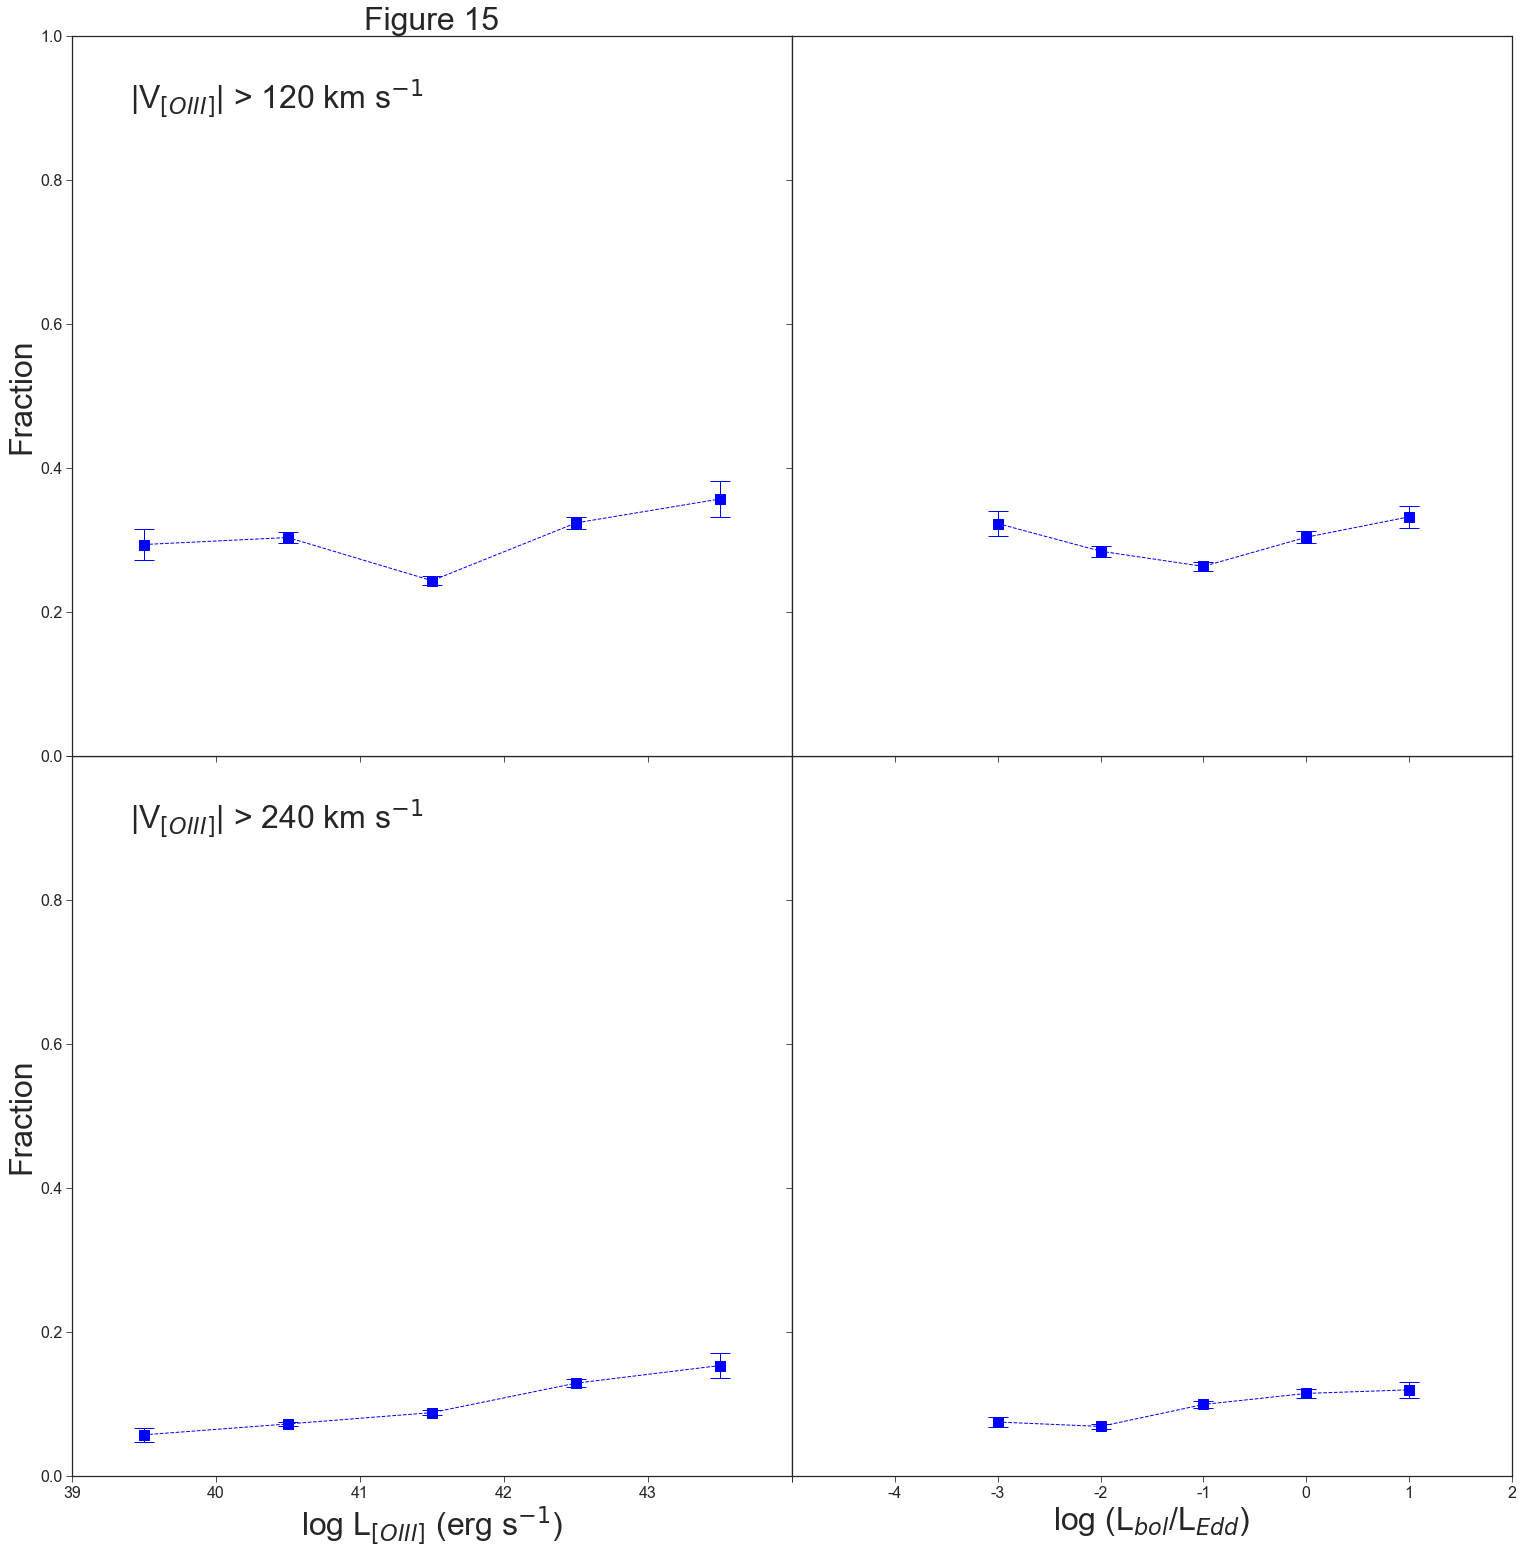

In [128]:
fig = plt.figure(figsize=(10,10))



ax1b = fig.add_axes([0, -1, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2b = fig.add_axes([1, -1, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )
ax1a = fig.add_axes([0, 0, 1, 1],     xlim = ( 39, 44 ), ylim = (0, 1 ) )
ax2a = fig.add_axes([1, 0, 1, 1],     xlim = ( -5, 2), ylim = (0, 1) )

ax1a.set_title('Figure 15', fontsize = 32)
ax1a.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig15_lum_vel_shift_frac1, fig15_lum_vel_shift_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
# ax1a.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1a.set_ylabel('Fraction', fontsize = 32)

ax1a.set_xticklabels([], fontsize = 16)
ax1a.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 16)
ax1a.text(39.4, 0.9, r'|V$_{[OIII]}$| > 120 km s$^{-1}$', fontsize = 32)

ax2a.errorbar(np.array([-3,-2,-1,0,1]), fig15_edd_vel_shift_frac1, fig15_edd_vel_shift_err_frac1, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2a.set_yticklabels([], fontsize = 16)
ax2a.set_xticklabels([], fontsize = 16)
# ax2a.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)


ax1b.errorbar(np.array([39.5,40.5,41.5,42.5,43.5]), fig15_lum_vel_shift_frac2, fig15_lum_vel_shift_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax1b.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel('Fraction', fontsize = 32)
ax1b.text(39.4, 0.9, r'|V$_{[OIII]}$| > 240 km s$^{-1}$', fontsize = 32)

ax1b.set_xticklabels([39,40,41,42, 43], fontsize = 16)
ax1b.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, ''], fontsize = 16)

ax2b.errorbar(np.array([-3,-2,-1,0,1]), fig15_edd_vel_shift_frac2, fig15_edd_vel_shift_err_frac2, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 10)
ax2b.set_yticklabels([], fontsize = 16)
ax2b.set_xticklabels(['',-4,-3, -2, -1, 0, 1, 2], fontsize = 16)
ax2b.set_xlabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

plt.show()

In [127]:
###120 is one sigma for the v oiii distribution

In [276]:
col0 = fits.Column(name = 'LOG_OIII_LUM', format = 'D', array = zbin1_OIII_log_lum_array)
col1 = fits.Column(name = 'LOG_EDD_RATIO', format = 'D', array = zbin1_log_edd_ratio)
col2 = fits.Column(name = 'SIGMA_OIII', format = 'D', array = OIII_sigma_array_zbin1_good)

col3 = fits.Column(name = 'LOG_SIGMA_RATIO', format = 'D', array = zbin1_log_sigma_ratio)
col4 = fits.Column(name = 'VEL_OIII', format = 'D', array = zbin1_vs)

coldefs = fits.ColDefs([col0, col1, col2, col3, col4])
hdu = fits.BinTableHDU.from_columns(coldefs)

zbin1_analysis_values = Table(hdu.data)

###############################

col0 = fits.Column(name = 'LOG_OIII_LUM', format = 'D', array = zbin2_OIII_log_lum_array)
col1 = fits.Column(name = 'LOG_EDD_RATIO', format = 'D', array = zbin2_log_edd_ratio)
col2 = fits.Column(name = 'SIGMA_OIII', format = 'D', array = OIII_sigma_array_zbin2_good)

col3 = fits.Column(name = 'LOG_SIGMA_RATIO', format = 'D', array = zbin2_log_sigma_ratio)
col4 = fits.Column(name = 'VEL_OIII', format = 'D', array = zbin2_vs)

coldefs = fits.ColDefs([col0, col1, col2, col3, col4])
hdu = fits.BinTableHDU.from_columns(coldefs)

zbin2_analysis_values = Table(hdu.data)

###############################

col0 = fits.Column(name = 'LOG_OIII_LUM', format = 'D', array = zbin3_OIII_log_lum_array)
col1 = fits.Column(name = 'LOG_EDD_RATIO', format = 'D', array = zbin3_log_edd_ratio)
col2 = fits.Column(name = 'SIGMA_OIII', format = 'D', array = OIII_sigma_array_zbin3_good)

col3 = fits.Column(name = 'LOG_SIGMA_RATIO', format = 'D', array = zbin3_log_sigma_ratio)
col4 = fits.Column(name = 'VEL_OIII', format = 'D', array = zbin3_vs)

coldefs = fits.ColDefs([col0, col1, col2, col3, col4])
hdu = fits.BinTableHDU.from_columns(coldefs)

zbin3_analysis_values = Table(hdu.data)

###############################

col0 = fits.Column(name = 'LOG_OIII_LUM', format = 'D', array = zbin4_OIII_log_lum_array)
col1 = fits.Column(name = 'LOG_EDD_RATIO', format = 'D', array = zbin4_log_edd_ratio)
col2 = fits.Column(name = 'SIGMA_OIII', format = 'D', array = OIII_sigma_array_zbin4_good)

col3 = fits.Column(name = 'LOG_SIGMA_RATIO', format = 'D', array = zbin4_log_sigma_ratio)
col4 = fits.Column(name = 'VEL_OIII', format = 'D', array = zbin4_vs)

coldefs = fits.ColDefs([col0, col1, col2, col3, col4])
hdu = fits.BinTableHDU.from_columns(coldefs)

zbin4_analysis_values = Table(hdu.data)

In [282]:
# zbin1_analysis_values.write('zbin1_analysis_final.fits')
# zbin2_analysis_values.write('zbin2_analysis_final.fits')
# zbin3_analysis_values.write('zbin3_analysis_final.fits')
# zbin4_analysis_values.write('zbin4_analysis_final.fits')

# (Table(zbin1_results_v2)).write('zbin1_results_final.fits')
# (Table(zbin2_results_v2)).write('zbin2_results_final.fits')
# (Table(zbin3_results_v2)).write('zbin3_results_final.fits')
# (Table(zbin4_results_v2)).write('zbin4_results_final.fits')

# (Table(zbin1_data_v2)).write('zbin1_data_final.fits')
# (Table(zbin2_data_v2)).write('zbin2_data_final.fits')
# (Table(zbin3_data_v2)).write('zbin3_data_final.fits')
# (Table(zbin4_data_v2)).write('zbin4_data_final.fits')
